# Introduction

We use char2char NLM using seq2seq + Attention model.

The encoder-decoder follows seq2seq model.

The decoding is based on attending to the encoder + the current decoder state.
The attention model follows: Luong et al., 2015 (https://arxiv.org/abs/1508.04025) instead of the traditional Bahadanau et al., 2014 (https://arxiv.org/abs/1409.0473). The implementation of attention follows this blog: https://wanasit.github.io/attention-based-sequence-to-sequence-in-keras.html. The reason to choose that is that the attention level is working at the output level of the LSTM, while Bahdanau attention needs to work at the state level of the encoder.

Planning to move to Attention() layer from fast.ai Jeremy Howard implementation: https://github.com/fastai/courses/blob/master/deeplearning2/attention_wrapper.py, which is following Bahdanau attention. 

# Imports

In [1]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU, Dot, TimeDistributed, Activation, Embedding
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.tokenize import word_tokenize
from utils import *
import pdb
%matplotlib inline

Using TensorFlow backend.


In [2]:

gpu_alloc("1")

# Load data

In [3]:
data_path = '.'
file_name = 'wonderland.txt'

In [4]:
num_samples = 100000
full_file_name = os.path.join(data_path, file_name)
raw_texts = load_data(full_file_name, num_samples)
print(raw_texts[:200])

ALICE'S ADVENTURES IN WONDERLAND

Lewis Carroll

THE MILLENNIUM FULCRUM EDITION 3.0

CHAPTER I. Down the Rabbit-Hole

Alice was beginning to get very tired of sitting by her sister on the
bank, and of


In [5]:


in_seq_len = 20
out_seq_len = 20
input_texts, target_texts = generate_lm_data(raw_texts, in_seq_len, out_seq_len)

In [6]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

86641
ALICE'S ADVENTURES I 
 	N WONDERLAND

Lewis 

LICE'S ADVENTURES IN 
 	 WONDERLAND

Lewis C

ICE'S ADVENTURES IN  
 	WONDERLAND

Lewis Ca

CE'S ADVENTURES IN W 
 	ONDERLAND

Lewis Car

E'S ADVENTURES IN WO 
 	NDERLAND

Lewis Carr

'S ADVENTURES IN WON 
 	DERLAND

Lewis Carro

S ADVENTURES IN WOND 
 	ERLAND

Lewis Carrol

 ADVENTURES IN WONDE 
 	RLAND

Lewis Carroll

ADVENTURES IN WONDER 
 	LAND

Lewis Carroll


DVENTURES IN WONDERL 
 	AND

Lewis Carroll





## Build vocab

In [7]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab-{}', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab)

In [8]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts]) + 2 # For '\t' and '\n'
max_decoder_seq_length = max([len(txt) for txt in target_texts]) + 2

In [9]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 86641
Number of unique input tokens: 72
Number of unique output tokens: 72
Max sequence length for inputs: 22
Max sequence length for outputs: 24


In [10]:
vocab_to_int # Some special chars need to be removed TODO: Data cleaning

{'\t': 2,
 '\n': 3,
 ' ': 1,
 '!': 61,
 '"': 64,
 "'": 46,
 '(': 49,
 ')': 50,
 '*': 65,
 ',': 42,
 '-': 51,
 '.': 28,
 '0': 29,
 '3': 27,
 ':': 43,
 ';': 54,
 '?': 47,
 'A': 11,
 'B': 66,
 'C': 16,
 'D': 7,
 'E': 8,
 'F': 26,
 'G': 60,
 'H': 22,
 'I': 24,
 'J': 67,
 'K': 56,
 'L': 10,
 'M': 23,
 'N': 4,
 'O': 6,
 'P': 30,
 'Q': 68,
 'R': 9,
 'S': 57,
 'T': 21,
 'U': 25,
 'UNK': 0,
 'V': 52,
 'W': 5,
 'Y': 53,
 'Z': 62,
 '[': 69,
 ']': 70,
 '_': 71,
 'a': 17,
 'b': 32,
 'c': 31,
 'd': 38,
 'e': 12,
 'f': 39,
 'g': 33,
 'h': 40,
 'i': 14,
 'j': 58,
 'k': 41,
 'l': 20,
 'm': 48,
 'n': 34,
 'o': 19,
 'p': 44,
 'q': 55,
 'r': 18,
 's': 15,
 't': 35,
 'u': 45,
 'v': 36,
 'w': 13,
 'x': 59,
 'y': 37,
 'z': 63}

In [11]:
int_to_vocab

{0: 'UNK',
 1: ' ',
 2: '\t',
 3: '\n',
 4: 'N',
 5: 'W',
 6: 'O',
 7: 'D',
 8: 'E',
 9: 'R',
 10: 'L',
 11: 'A',
 12: 'e',
 13: 'w',
 14: 'i',
 15: 's',
 16: 'C',
 17: 'a',
 18: 'r',
 19: 'o',
 20: 'l',
 21: 'T',
 22: 'H',
 23: 'M',
 24: 'I',
 25: 'U',
 26: 'F',
 27: '3',
 28: '.',
 29: '0',
 30: 'P',
 31: 'c',
 32: 'b',
 33: 'g',
 34: 'n',
 35: 't',
 36: 'v',
 37: 'y',
 38: 'd',
 39: 'f',
 40: 'h',
 41: 'k',
 42: ',',
 43: ':',
 44: 'p',
 45: 'u',
 46: "'",
 47: '?',
 48: 'm',
 49: '(',
 50: ')',
 51: '-',
 52: 'V',
 53: 'Y',
 54: ';',
 55: 'q',
 56: 'K',
 57: 'S',
 58: 'j',
 59: 'x',
 60: 'G',
 61: '!',
 62: 'Z',
 63: 'z',
 64: '"',
 65: '*',
 66: 'B',
 67: 'J',
 68: 'Q',
 69: '[',
 70: ']',
 71: '_'}

In [12]:
len(int_to_vocab)

72

# Prepare training data

## Train/test split

In [13]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [14]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

In [15]:
print(encoder_input_data.shape)
print(decoder_target_data.shape)

(73644, 22)
(73644, 22, 72)


## Test data

In [16]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [17]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [18]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

[<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]
Tensor("lstm_2/transpose_2:0", shape=(?, ?, 512), dtype=float32)
Tensor("bidirectional_1/concat:0", shape=(?, ?, 512), dtype=float32)
attention Tensor("attention/truediv:0", shape=(?, ?, ?), dtype=float32)
encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 72)     5184        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, No

/home/elsallab/Work/cod/READ/utils.py:456: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  encoder_model = Model(input=encoder_inputs, output=[encoder_outputs] + encoder_states)


# Training

In [19]:
batch_size = 64  # Batch size for training.
epochs = 20  
lr = 0.01

# Learning rate decay

In [20]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [21]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [22]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [23]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [24]:
#callbacks_list.append(lrate)

In [25]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.1,
          shuffle=True)

Train on 66279 samples, validate on 7365 samples
Epoch 1/20
66279/66279 [==============================] - 99s 1ms/step - loss: 1.6772 - categorical_accuracy: 0.4748 - val_loss: 1.1828 - val_categorical_accuracy: 0.5984

Epoch 00001: val_categorical_accuracy improved from -inf to 0.59836, saving model to best_model.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/20
66279/66279 [==============================] - 97s 1ms/step - loss: 1.0721 - categorical_accuracy: 0.6268 - val_loss: 1.0493 - val_categorical_accuracy: 0.6283

Epoch 00002: val_categorical_accuracy improved from 0.59836 to 0.62831, saving model to best_model.hdf5
Epoch 3/20
66279/66279 [==============================] - 98s 1ms/step - loss: 0.9123 - categorical_accuracy: 0.6682 - val_loss: 0.8310 - val_categorical_accuracy: 0.6936

Epoch 00003: val_categorical_accuracy improved from 0.62831 to 0.69364, saving model to best_model.hdf5
Epoch 4/20
66279/66279 [==============================] - 97s 1ms/step - loss: 0.7686 - categorical_accuracy: 0.7106 - val_loss: 0.7383 - val_categorical_accuracy: 0.7195

Epoch 00004: val_categorical_accuracy improved from 0.69364 to 0.71946, saving model to best_model.hdf5
Epoch 5/20
66279/66279 [==============================] - 97s 1ms/step - loss: 0.6914 - categorical_accuracy: 0.7332 - val_loss: 0.6839 - val_categorical_accuracy: 0.7370



In [26]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_4:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'input_5:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


# Inference

In [43]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = input_texts[seq_index]
    target_text = target_texts[seq_index][1:-1]

    encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[input_text],
                                                                                 target_texts=[target_text], 
                                                                                 max_encoder_seq_length=max_encoder_seq_length, 
                                                                                 num_encoder_tokens=num_encoder_tokens, 
                                                                                 vocab_to_int=vocab_to_int)    

    input_seq = encoder_input_data
    #target_seq = np.argmax(decoder_target_data, axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, max_encoder_seq_length, int_to_vocab, vocab_to_int)
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)
    results.write(' | ' + input_text + ' | ' + target_text.strip() + ' | ' + decoded_sentence + ' | \n')
    decoded_sentences.append(decoded_sentence)
    #corrected_sentences.append(corrected_sentence)
    #corrected_input_sentences.append(corrected_input_sentence)
    target_texts_.append(target_text)




-
Input sentence: Why did you call him
GT sentence:  Tortoise, if he was
Decoded sentence:  Tortoise if he was
-
Input sentence: d not sneeze, were t
GT sentence: he cook, and a large
Decoded sentence: he cook and,a large
-
Input sentence: ive, who had been an
GT sentence: xiously looking acro
Decoded sentence: d l,ft off a little 
-
Input sentence: ong
the trees, a lit
GT sentence: tle sharp bark just 
Decoded sentence: tle sharp bar, just 
-
Input sentence: n't know what a Gryp
GT sentence: hon is, look at the 
Decoded sentence: liss things are put 
-
Input sentence: nd rushed at the sti
GT sentence: ck,
and made believe
Decoded sentence: ck and to her great
-
Input sentence: r, sir, if you would
GT sentence: n't mind,'
said Alic
Decoded sentence: n,t ke,p appearing 
-
Input sentence: ously looking across
GT sentence:  the garden, called

Decoded sentence:  the garden came
-
Input sentence: her
childhood: and h
GT sentence: ow she would gather 
Decoded sentence: ow she would :ather 


-
Input sentence: am,' the young man s
GT sentence: aid,
    'And your h
Decoded sentence: it,ing on a branch o
-
Input sentence:  of it now in sight,
GT sentence:  and no more of it a
Decoded sentence:  and looking
-
Input sentence: nd that better,' Ali
GT sentence: ce said very politel
Decoded sentence: ce said very p,litel
-
Input sentence:  way through the nei
GT sentence: ghbouring pool--she

Decoded sentence: ther if you don't b
-
Input sentence:  'em up at this corn
GT sentence: er--No, tie 'em
toge
Decoded sentence: erNo tie 'em
-
Input sentence: uestion,'
added the 
GT sentence: Gryphon; and then th
Decoded sentence: Gryphon, and then sa
-
Input sentence: l, I'll eat it,' sai
GT sentence: d
Alice, 'and if it 
Decoded sentence: d,Alice 'a gr,at co
-
Input sentence:  the banquet--]

'Wh
GT sentence: at IS the use of rep
Decoded sentence: at IS the us--]f rep
-
Input sentence: again in a ring, and
GT sentence: 
begged the Mouse to
Decoded sentence: 
-
Input sentence: he can thoro

-
Input sentence:   (Before she had th
GT sentence: is fit)
   An obstac
Decoded sentence: is(fitted to find t
-
Input sentence: rules in particular;
GT sentence: 
at least, if there 
Decoded sentence:  and if you dried ;
-
Input sentence: he most interesting,
GT sentence:  and
perhaps as this
Decoded sentence: ' said the Mock Tur,
-
Input sentence: hess by this time, a
GT sentence: nd was a little
star
Decoded sentence: nd was going off ,nt
-
Input sentence: t, as nearly as she 
GT sentence: could guess, she was
Decoded sentence: c,uld guess she was
-
Input sentence: each at
the Duchess 
GT sentence: and the baby--the fi
Decoded sentence: was a time she was a
-
Input sentence: n as quickly as she 
GT sentence: could, for the accid
Decoded sentence: could for the arche
-
Input sentence: l the time she went 
GT sentence: on talking: 'Dear, d
Decoded sentence: on 'you throw the D
-
Input sentence: d the party sat sile
GT sentence: nt for a minute, whi
Decoded sentence: nt and looked at i

-
Input sentence: , in couples: they w
GT sentence: ere all ornamented
w
Decoded sentence: ,re or a fea:her for
-
Input sentence: ands, and
she set to
GT sentence:  work very carefully
Decoded sentence:  cha,ge in my over t
-
Input sentence: te Rabbit; 'in fact,
GT sentence:  there's
nothing wri
Decoded sentence: 
-
Input sentence: ns well enough, when
GT sentence:  I find a thing,' sa
Decoded sentence:  I'll
-
Input sentence: lways getting up
and
GT sentence:  walking off to othe
Decoded sentence:  offended tone and 
-
Input sentence:  Caterpillar, just a
GT sentence: s if she had asked i
Decoded sentence: s if she had,gone it
-
Input sentence: nd saw that, in her 
GT sentence: haste, she had put
t
Decoded sentence: haste she ,ad come
-
Input sentence: ut her sister sat st
GT sentence: ill just as she left
Decoded sentence: igh and was gone a
-
Input sentence:  a little recovered 
GT sentence: from the shock of be
Decoded sentence: to rest herself and
-
Input sentence:  might be some 

-
Input sentence: and she walked off, 
GT sentence: leaving Alice alone 
Decoded sentence: leaving Alice alon, 
-
Input sentence:  said this, she
came
GT sentence:  upon a neat little 
Decoded sentence:  upon a ne,r her sho
-
Input sentence: d off; the Dormouse 
GT sentence: fell asleep instantl
Decoded sentence: fell ;sleep instantl
-
Input sentence: d; 'there's a large 
GT sentence: mustard-mine near he
Decoded sentence: m;shroom growing
-
Input sentence: te kid gloves: she t
GT sentence: ook up the fan and a
Decoded sentence: hought at fir:t and
-
Input sentence: ed his mind, and was
GT sentence:  coming
back to fini
Decoded sentence:  coming
-
Input sentence: inning to
grow large
GT sentence: r again, and she tho
Decoded sentence:  rosetree she had g
-
Input sentence: dry again,
the Dodo 
GT sentence: suddenly called out 
Decoded sentence: could not,think of a
-
Input sentence: een to her,
    And 
GT sentence: mentioned me to him:
Decoded sentence: went on mu,t kept a 
-
Input sen

-
Input sentence: g her hands up to he
GT sentence: r head, she
tried to
Decoded sentence: r to wink with one o
-
Input sentence: illar took the hooka
GT sentence: h out of its mouth
a
Decoded sentence: h and shoice out of
-
Input sentence: nah, and saying to h
GT sentence: er very earnestly, '
Decoded sentence: ers,lf 'I
-
Input sentence: uchess said to Alice
GT sentence: ,
flinging the baby 
Decoded sentence:  and the
-
Input sentence: s well as she could,
GT sentence:  for the
hot day mad
Decoded sentence:  for she was now ab,
-
Input sentence: r throne when they
a
GT sentence: rrived, with a great
Decoded sentence: dvicacing about and
-
Input sentence: uch as, 'Sure, I don
GT sentence: 't like it, yer hono
Decoded sentence: 't lik, it y,r hona
-
Input sentence: 'M a Duchess,' she s
GT sentence: aid to herself, (not
Decoded sentence: aid to herse,f not
-
Input sentence: ' said the Hatter, '
GT sentence: when the
Queen jumpe
Decoded sentence: why you can't
-
Input sentence:   *    * 

-
Input sentence: at it, and then hurr
GT sentence: ied on,
Alice starte
Decoded sentence: ied
-
Input sentence:  the song, she kept 
GT sentence: tossing
the baby vio
Decoded sentence: into
-
Input sentence:  door, she ran out o
GT sentence: f the house, and fou
Decoded sentence: f sig,t he would no
-
Input sentence: ns, and that is enou
GT sentence: gh,'
    Said his fa
Decoded sentence: gh,' thought poor Al
-
Input sentence: d we've no time to w
GT sentence: ash the things betwe
Decoded sentence: orth the things bein
-
Input sentence: went, as if it had l
GT sentence: ost something; and s
Decoded sentence: iked,me too brown I
-
Input sentence: y respectful tone, b
GT sentence: ut frowning and maki
Decoded sentence: ut from her adril, f
-
Input sentence: s not much surprised
GT sentence:  at this, she was ge
Decoded sentence:  that she remained 
-
Input sentence: find that her
neck w
GT sentence: ould bend about easi
Decoded sentence: ith one of the edge 
-
Input sentence: cup of tea

-
Input sentence: n, and Alice, were i
GT sentence: n custody and
under 
Decoded sentence: n,fact and ,ooking
-
Input sentence: n't the least idea w
GT sentence: hat you're talking a
Decoded sentence: as gone' said the M
-
Input sentence: bled about them--all
GT sentence:  sorts of little
bir
Decoded sentence:  the
-
Input sentence: f the lefthand bit o
GT sentence: f mushroom, and rais
Decoded sentence: f mushroom and much
-
Input sentence: reply (it had left o
GT sentence: ff sneezing by this 
Decoded sentence: ff the(sky that she
-
Input sentence:  not attended to thi
GT sentence: s last remark,
'it's
Decoded sentence: s and she was now a
-
Input sentence: ow I wish I could
sh
GT sentence: ut up like a telesco
Decoded sentence: e uncork up I know u
-
Input sentence: 't believe it,' said
GT sentence:  the Pigeon; 'but if
Decoded sentence:  the Pigeon
-
Input sentence: pocket, or a watch
t
GT sentence: o take out of it, an
Decoded sentence: o take,out 'You may
-
Input sentence: 'm
sur

-
Input sentence: EY GAVE HIM TWO--" w
GT sentence: hy, that must be wha
Decoded sentence: hy that must b--"ha
-
Input sentence: ce could not think o
GT sentence: f any
good reason, a
Decoded sentence: f authority among th
-
Input sentence: ought it over afterw
GT sentence: ards, it
occurred to
Decoded sentence: ards and she had co
-
Input sentence: ell you his history,
GT sentence: '

As they walked of
Decoded sentence: '
-
Input sentence: , for the accident o
GT sentence: f
the goldfish kept 
Decoded sentence: , getting entangled 
-
Input sentence: as if she had asked 
GT sentence: it
aloud; and in ano
Decoded sentence: it
-
Input sentence:  at the end of
every
GT sentence:  line:

   'Speak ro
Decoded sentence:  line
-
Input sentence: king at them
with on
GT sentence: e eye; 'I seem to se
Decoded sentence: e eye 'I seem to se
-
Input sentence:  proved it at all; h
GT sentence: owever, she went on 
Decoded sentence: owever it may
-
Input sentence: d
their eyes and mou
GT sentence: th

-
Input sentence: n, three of the
sold
GT sentence: iers remaining behin
Decoded sentence: i,rs remaining behin
-
Input sentence: ce for a good deal: 
GT sentence: this fireplace is na
Decoded sentence: fashive the rest o: 
-
Input sentence: sure in all their si
GT sentence: mple joys,
rememberi
Decoded sentence: mply
-
Input sentence: ed; in fact, I didn'
GT sentence: t know
that cats COU
Decoded sentence: t ;now
-
Input sentence: some more of the lef
GT sentence: thand bit of mushroo
Decoded sentence: thand bit of mushroo
-
Input sentence: sort it was)
scratch
GT sentence: ing and scrambling a
Decoded sentence: ancing and )cramblin
-
Input sentence: , turtles, salmon, a
GT sentence: nd so on;
then, when
Decoded sentence: ,d songon,s ton
-
Input sentence:  so
stingy about it,
GT sentence:  you know--'

She ha
Decoded sentence:  you know'
-
Input sentence: ture, but on
the who
GT sentence: le she thought it wo
Decoded sentence: le s,e thought it ha
-
Input sentence: 've
seen them so of

-
Input sentence: in silence:
at last 
GT sentence: the Caterpillar took
Decoded sentence: Cheshire C:t Contir 
-
Input sentence: ow--'

'But, it goes
GT sentence:  on "THEY ALL RETURN
Decoded sentence:  --EY ALL ,ETURNED
-
Input sentence: nd bread-and-butter,
GT sentence:  and went
down on on
Decoded sentence:  and the- tu-ned to,
-
Input sentence: d in an offended ton
GT sentence: e, 'so I can't
take 
Decoded sentence: e
-
Input sentence:  ever: she sat down 
GT sentence: and began to cry aga
Decoded sentence: and b:gan to cry aga
-
Input sentence: e
corners: next the 
GT sentence: ten courtiers; these
Decoded sentence: Queen wh: seemed to
-
Input sentence: ntinued, 'in this wa
GT sentence: y:--

     "Up above
Decoded sentence: y you c,nbut I mu
-
Input sentence: ve croqueted the Que
GT sentence: en's hedgehog just n
Decoded sentence: en' she said to her
-
Input sentence: she jumped up on to 
GT sentence: her feet in a moment
Decoded sentence: her feet they set t
-
Input sentence: t

-
Input sentence: not remember
ever ha
GT sentence: ving seen such a thi
Decoded sentence: ving heards used to 
-
Input sentence: e (she was so much s
GT sentence: urprised, that
for t
Decoded sentence: he(
-
Input sentence: emely--' Just then s
GT sentence: he noticed
that the 
Decoded sentence: he no--ced
-
Input sentence: ment, when she found
GT sentence:  that her shoulders

Decoded sentence:  a p,use he know tha
-
Input sentence:  long silence after 
GT sentence: this, and Alice coul
Decoded sentence: this and Alice cats
-
Input sentence: on
which the wretche
GT sentence: d Hatter trembled so
Decoded sentence: r side end of the tr
-
Input sentence: t the jury consider 
GT sentence: their verdict,' the 
Decoded sentence: with the
-
Input sentence: o
sort of meaning in
GT sentence:  it, and yet it was 
Decoded sentence:  it and yet it was 
-
Input sentence: the White Rabbit ble
GT sentence: w three
blasts on th
Decoded sentence: w three blasts on th
-
Input sentence: own business,' 

-
Input sentence:  did not like to dro
GT sentence: p the jar for fear
o
Decoded sentence: w to fore who had f
-
Input sentence: ry sleepy and stupid
GT sentence: ), whether the pleas
Decoded sentence:  whether the pleas
-
Input sentence: ay down here
till I'
GT sentence: m somebody else"--bu
Decoded sentence: m some dear one side
-
Input sentence:  'I once tasted--' b
GT sentence: ut checked herself h
Decoded sentence: ecause he had c--en
-
Input sentence: rs wandered about fo
GT sentence: r a
minute or two, l
Decoded sentence: r some way and then
-
Input sentence: nfortunate little Bi
GT sentence: ll had left off writ
Decoded sentence: ll had left off writ
-
Input sentence:  they're called less
GT sentence: ons,' the Gryphon re
Decoded sentence: ons
-
Input sentence: hat I say,' the Mock
GT sentence:  Turtle replied in a
Decoded sentence:  Turtle r,plied in
-
Input sentence: ys it's so useful, i
GT sentence: t's worth a hundred 
Decoded sentence: t was certainly E,gl
-
Input sentence

-
Input sentence: ent round the court 
GT sentence: and got behind him, 
Decoded sentence: how she wasn't a bit
-
Input sentence: utiful Soup, so rich
GT sentence:  and green,
   Waiti
Decoded sentence:  and green,
-
Input sentence: unate gardeners, who
GT sentence:  ran
to Alice for pr
Decoded sentence:  was prize
-
Input sentence: patiently; and, turn
GT sentence: ing to
Alice, she we
Decoded sentence: ing to
-
Input sentence: re obliged to have h
GT sentence: im with them,' the M
Decoded sentence: im with many a stran
-
Input sentence: aid Alice; 'I must b
GT sentence: e shutting up like a
Decoded sentence: e a walru; or help t
-
Input sentence: Mock Turtle
interrup
GT sentence: ted, 'if you don't e
Decoded sentence: ted it 'UNd you wer
-
Input sentence: s, it had entirely
d
GT sentence: isappeared; so the K
Decoded sentence: o,n and looked at po
-
Input sentence:  a
         mouse, T
GT sentence: hat he
        met i
Decoded sentence: hank
-
Input sentence:  'I daresay it's
a F
GT 

-
Input sentence: count of the game, f
GT sentence: eeling very glad
she
Decoded sentence: eeling very
-
Input sentence: voking to find that 
GT sentence: the hedgehog had unr
Decoded sentence: it seemed quite natu
-
Input sentence:  rather unwillingly 
GT sentence: took
the place of th
Decoded sentence: cleared' said
-
Input sentence: nd sometimes shorter
GT sentence: , until she had
succ
Decoded sentence:  so she scolded her
-
Input sentence: t came up to the doo
GT sentence: r, and tried to open
Decoded sentence: r
-
Input sentence: at by
the end of hal
GT sentence: f an hour or so ther
Decoded sentence:  when the Rabbit rea
-
Input sentence: Footman began by pro
GT sentence: ducing from under hi
Decoded sentence: ducing from under hi
-
Input sentence: indignantly, and she
GT sentence:  sat
down in a large
Decoded sentence:  sat
-
Input sentence: tle golden key, and 
GT sentence: when she
went back t
Decoded sentence: when she
-
Input sentence: ice, a little timidl
GT sentence: y, '

-
Input sentence: your Majesty,' said 
GT sentence: Two, in a very humbl
Decoded sentence: the Knave ',f you c
-
Input sentence: Hatter grumbled:
'yo
GT sentence: u shouldn't have put
Decoded sentence: u knownothing :ore 
-
Input sentence: d,'
she went on, ver
GT sentence: y much pleased at ha
Decoded sentence: y,likely to win, wit
-
Input sentence: abelled 'ORANGE MARM
GT sentence: ALADE', but to her g
Decoded sentence: ALADE' but to her g
-
Input sentence:  that's because it
s
GT sentence: tays the same year f
Decoded sentence: tays the same year f
-
Input sentence: an off, thinking whi
GT sentence: le she ran, as well 
Decoded sentence: le bee, ralles and r
-
Input sentence: said the Dormouse, a
GT sentence: fter thinking a minu
Decoded sentence: nd round the cour,
-
Input sentence: rush at Alice the mo
GT sentence: ment she
appeared; b
Decoded sentence: ment's showled some 
-
Input sentence: uchess, it had entir
GT sentence: ely
disappeared; so 
Decoded sentence: e
-
Input sentence

-
Input sentence: e, and waving their

GT sentence: forepaws to mark the
Decoded sentence: r,ddl down and madue
-
Input sentence: athies, I think--' (
GT sentence: she was rather glad

Decoded sentence: she ra, off a l--tl(
-
Input sentence: t the jury--'

'If a
GT sentence: ny one of them can e
Decoded sentence: nd that ca-- and the
-
Input sentence: ell as pigs, and was
GT sentence:  just saying
to hers
Decoded sentence:  going
-
Input sentence: were filled with
cup
GT sentence: boards and book-shel
Decoded sentence: boar to the beginnin
-
Input sentence: like, but it puzzled
GT sentence:  her too much, so sh
Decoded sentence:  her,very much alrea
-
Input sentence: had made her so
sava
GT sentence: ge when they met in 
Decoded sentence: ge with one in by mi
-
Input sentence:  judge, I'll
       
GT sentence:   be jury,"
        
Decoded sentence:       ,             
-
Input sentence: or this time the Mou
GT sentence: se was bristling all
Decoded sentence: se splashing a piese
-
Inpu

-
Input sentence: o the Dormouse's pla
GT sentence: ce, and Alice rather
Decoded sentence: yer and rather Alic
-
Input sentence: hen the
Queen jumped
GT sentence:  up and bawled out, 
Decoded sentence:  up and bawled out 
-
Input sentence:  sounded an excellen
GT sentence: t plan, no doubt, an
Decoded sentence: t no not poor Alice
-
Input sentence:  a ring, and
begged 
GT sentence: the Mouse to tell th
Decoded sentence: to the ,ock Turtle t
-
Input sentence: 'I didn't know that 
GT sentence: Cheshire cats always
Decoded sentence: it's done' the Cat 
-
Input sentence:  the thought that sh
GT sentence: e was now the right 
Decoded sentence: e was now the rest o
-
Input sentence: his piece of rudenes
GT sentence: s was more than Alic
Decoded sentence: s making half of fr
-
Input sentence: up towards it rather
GT sentence:  timidly,
saying to 
Decoded sentence:  'I move
-
Input sentence: oticed before, and
b
GT sentence: ehind it was a littl
Decoded sentence: ehind them a ,airing
-
Input s

-
Input sentence: is, she
came upon a 
GT sentence: neat little house, o
Decoded sentence: li,tle house and th
-
Input sentence: ad been anxiously lo
GT sentence: oking across the gar
Decoded sentence: oking for the hedgeh
-
Input sentence: ense length of neck,
GT sentence:  which seemed to ris
Decoded sentence: ' said Alice hastil,
-
Input sentence: 

They were indeed a
GT sentence:  queer-looking party
Decoded sentence:  dispute to play wit
-
Input sentence: stood near the entra
GT sentence: nce of the garden: t
Decoded sentence: nce of this that sh
-
Input sentence: mostly Kings and Que
GT sentence: ens, and among
them 
Decoded sentence: ens and amone
-
Input sentence: and it said in a low
GT sentence: 
trembling voice, 'L
Decoded sentence:  voice
-
Input sentence:  make out which were
GT sentence:  the two sides of it
Decoded sentence:  the tide
-
Input sentence: elp it,' said Five, 
GT sentence: in a sulky tone; 'Se
Decoded sentence: and ve,y interesti,g
-
Input sentence:  from
on

-
Input sentence: rn, with
Seaography:
GT sentence:  then Drawling--the 
Decoded sentence:  t,at Dry Driwning :
-
Input sentence: k first,' she said, 
GT sentence: 'and
see whether it'
Decoded sentence: 'and
-
Input sentence: tinued as follows
  
GT sentence: When the sands are a
Decoded sentence:  When the sands are 
-
Input sentence: of feet in the dista
GT sentence: nce, and
she hastily
Decoded sentence: nce screaming wildl
-
Input sentence:  wanted leaders, and
GT sentence:  had been of late mu
Decoded sentence:  had been of la,e mu
-
Input sentence: r Alice began to cry
GT sentence:  again, for she felt
Decoded sentence:  again for she felt
-
Input sentence: E' beautifully print
GT sentence: ed on it in large
le
Decoded sentence: ion in
-
Input sentence:  isn't a letter, aft
GT sentence: er all: it's a set o
Decoded sentence: er all it's a ,et o
-
Input sentence: g for it, while the 
GT sentence: rest of the party we
Decoded sentence: processi,n' thought
-
Input sentence: ike the 

-
Input sentence: t as I'd taken the h
GT sentence: ighest tree in the w
Decoded sentence: edgehogs and if the
-
Input sentence: h)--and rapped loudl
GT sentence: y at the door with h
Decoded sentence: y)-- she was now abo
-
Input sentence: the youth, 'one woul
GT sentence: d hardly suppose
   
Decoded sentence: d hardly ,uppose
-
Input sentence: s she could not thin
GT sentence: k of anything
to say
Decoded sentence: kle look something 
-
Input sentence:  the poor child, 'fo
GT sentence: r I never was so sma
Decoded sentence: r she stopped s,me m
-
Input sentence: that her
neck would 
GT sentence: bend about easily in
Decoded sentence: be raving mad after 
-
Input sentence: ajesty,' said the Kn
GT sentence: ave, 'I didn't write
Decoded sentence: ave ',f you can't i
-
Input sentence: aid
to herself; 'I s
GT sentence: hould think it would
Decoded sentence: hould think it;would
-
Input sentence: as addressed to the 
GT sentence: baby,
and not to her
Decoded sentence: bong lasted an hers


-
Input sentence: ,' Alice cautiously 
GT sentence: replied, not feeling
Decoded sentence: ,eplied not feel it
-
Input sentence: eet at the
corners: 
GT sentence: next the ten courtie
Decoded sentence: the two queer time: 
-
Input sentence: oldfish
she had acci
GT sentence: dentally upset the w
Decoded sentence: dent or drawling abo
-
Input sentence: either of the others
GT sentence:  took the least noti
Decoded sentence:  to tell youall I 
-
Input sentence: an impatient tone:
'
GT sentence: explanations take su
Decoded sentence: the restart and :ha
-
Input sentence: ittle startled by se
GT sentence: eing the Cheshire Ca
Decoded sentence: eing the Cheshire Cat
-
Input sentence: e opposite to Alice,
GT sentence:  they all stopped an
Decoded sentence:  and she thought it,
-
Input sentence: 'I HAVE tasted eggs,
GT sentence:  certainly,' said Al
Decoded sentence: ' the Duchess said ,
-
Input sentence:  to it,' she thought
GT sentence: , 'till its ears hav
Decoded sentence:  'til, its ears 

-
Input sentence: ore, thank ye; I'm b
GT sentence: etter now--but I'm
a
Decoded sentence: ett,r nowbu; I ent
-
Input sentence: buttered toast,) she
GT sentence:  very soon finished 
Decoded sentence:  carrying the ,)her 
-
Input sentence:  her favourite word 
GT sentence: 'moral,' and the arm
Decoded sentence: 'poison' it is
-
Input sentence: e Bill

It was the W
GT sentence: hite Rabbit, trottin
Decoded sentence: hite Rabbit trottin
-
Input sentence: l dark overhead; bef
GT sentence: ore her was another

Decoded sentence: ore her head wa; an
-
Input sentence: uld chance to be
   
GT sentence:  Involved in this af
Decoded sentence:  I beautiful Soup s
-
Input sentence: twice, set to partne
GT sentence: rs--'

'--change lob
Decoded sentence: rs',
-
Input sentence: little golden key, a
GT sentence: nd unlocking the doo
Decoded sentence: nd was just sayin,
-
Input sentence: f hoping that they w
GT sentence: ould call after her:
Decoded sentence: ould call after her
-
Input sentence: houg

-
Input sentence: aid Alice, and she p
GT sentence: ut them into a large
Decoded sentence: ut them b,fore she h
-
Input sentence: , and finding it ver
GT sentence: y nice, (it had, in 
Decoded sentence: , nice it had in 
-
Input sentence: t you, will you, won
GT sentence: 't you, won't you jo
Decoded sentence: 't yo, won't y,u w
-
Input sentence: arrived, with a grea
GT sentence: t crowd assembled ab
Decoded sentence: t
-
Input sentence: olently,
that she lo
GT sentence: oked down into its f
Decoded sentence: oked in,o its face t
-
Input sentence: ettled down in a min
GT sentence: ute or two, and the 
Decoded sentence: ate at once and loo
-
Input sentence: ury:
          "I'll
GT sentence: 
          try the
 
Decoded sentence: 
-
Input sentence: the King, the Queen,
GT sentence: 
the royal children,
Decoded sentence:  come ov,r with the,
-
Input sentence: be a comfort, one wa
GT sentence: y--never to be an ol
Decoded sentence: y any one of,them a
-
Input sentence:  sea, 'and in that c

-
Input sentence: ff
all its feet at o
GT sentence: nce, with a yelp of 
Decoded sentence: nce with a pair of 
-
Input sentence: the thistle again; t
GT sentence: hen
the puppy began 
Decoded sentence: hen the Mouse he ;ip
-
Input sentence: the eleventh day mus
GT sentence: t have been a
holida
Decoded sentence: t have been a
-
Input sentence: pen her
mouth; but s
GT sentence: he did it at last, a
Decoded sentence: he did it at ;ast a
-
Input sentence: egan, 'for bringing 
GT sentence: these in: but I hadn
Decoded sentence: itse,f up in her fac
-
Input sentence:  him--it was for
bri
GT sentence: nging the cook tulip
Decoded sentence: nkin--close to her e
-
Input sentence: he could hear the ve
GT sentence: ry tones of her voic
Decoded sentence: rses on it in fack o
-
Input sentence:  HER ONE, THEY GAVE 
GT sentence: HIM TWO--" why, that
Decoded sentence: WOUME HI,H TO LEAVE 
-
Input sentence: hould think it would
GT sentence:  be QUITE as much us
Decoded sentence:  be QUITE as much a
-


-
Input sentence: s going to shrink an
GT sentence: y further:
she felt 
Decoded sentence: y further
-
Input sentence: no use in
saying any
GT sentence: thing more till the 
Decoded sentence: thing more if you'd 
-
Input sentence: Alice crouched down 
GT sentence: among the trees as w
Decoded sentence: again and the same 
-
Input sentence:  many footsteps,
and
GT sentence:  Alice looked round,
Decoded sentence:  Alice looked a, Ali
-
Input sentence: like the name: howev
GT sentence: er, it only grinned 
Decoded sentence: er it only g:inned 
-
Input sentence: there were ten of th
GT sentence: em, and the little d
Decoded sentence: is that she had not
-
Input sentence: rned out, and, by th
GT sentence: e time they had sett
Decoded sentence: e time h, had,come b
-
Input sentence: civil, you'd better 
GT sentence: finish the story for
Decoded sentence: finis,ed the first r
-
Input sentence: bbit, who said in a 
GT sentence: low voice,
'Your Maj
Decoded sentence: long, little voice 
-
Input

-
Input sentence: looking for the fan 
GT sentence: and the pair of whit
Decoded sentence: and then she had to 
-
Input sentence: f a head unless
ther
GT sentence: e was a body to cut 
Decoded sentence: e was a body to cut 
-
Input sentence: t would be very like
GT sentence: ly to eat her up in 
Decoded sentence:  eyes so suddenly 
-
Input sentence:  had been anxiously 
GT sentence: looking across the g
Decoded sentence: at the White Rabbit
-
Input sentence: oked at each other f
GT sentence: or some time in sile
Decoded sentence: ire stirring
-
Input sentence: topped
hastily, for 
GT sentence: the White Rabbit cri
Decoded sentence: the White Rabb,t cri
-
Input sentence: to herself; 'his eye
GT sentence: s are so VERY nearly
Decoded sentence: n expectin; every
-
Input sentence: he m--'

But here, t
GT sentence: o Alice's great surp
Decoded sentence: o Al--e's great s,rp
-
Input sentence: about the same heigh
GT sentence: t as
herself; and wh
Decoded sentence: t as
-
Input sentence: rumb

-
Input sentence: 'I beg your pardon,'
GT sentence:  said Alice very hum
Decoded sentence:  said the King had,s
-
Input sentence: iers, or
courtiers, 
GT sentence: or three of her own 
Decoded sentence: or t,ree of her ow, 
-
Input sentence:      morning I've
  
GT sentence:   nothing
    to do.
Decoded sentence:      denial
-
Input sentence: en all the party wer
GT sentence: e placed
along the c
Decoded sentence: e put on one of the 
-
Input sentence: thout speaking, but 
GT sentence: at last it unfolded 
Decoded sentence: it was not ous,ind t
-
Input sentence: ght Alice 'without p
GT sentence: ictures or
conversat
Decoded sentence: ictures or conversat
-
Input sentence: ned inwards, and Ali
GT sentence: ce's elbow was press
Decoded sentence: ce's elbow ,as press
-
Input sentence: nd the little dears 
GT sentence: came
jumping merrily
Decoded sentence: comfortably enough i
-
Input sentence: der at
the Mouse's t
GT sentence: ail; 'but why do you
Decoded sentence: o be a forthag in th
-

-
Input sentence: al too flustered to 
GT sentence: tell you--all I know
Decoded sentence: tell youall I know
-
Input sentence:  to my right size ag
GT sentence: ain; and the second

Decoded sentence: ain and the second
-
Input sentence: ome yet, please your
GT sentence:  Majesty,' said the 
Decoded sentence:  Majest, that it
-
Input sentence:  morning, just time 
GT sentence: to begin lessons: yo
Decoded sentence: in sight, 'but it go
-
Input sentence:  order one about, an
GT sentence: d make one repeat le
Decoded sentence: d make you grow ,all
-
Input sentence: his, I shall
think n
GT sentence: othing of tumbling d
Decoded sentence: oth,ng on it in larg
-
Input sentence: et;
   Yet you finis
GT sentence: hed the goose, with 
Decoded sentence: he; the goose with 
-
Input sentence: ike it put more
simp
GT sentence: ly--"Never imagine y
Decoded sentence: ly King rid it all
-
Input sentence: Alice caught the bab
GT sentence: y with some difficul
Decoded sentence: y with its feet 'I 
-
In

-
Input sentence: way, and the whole p
GT sentence: arty swam to the sho
Decoded sentence: ack,of crawled away 
-
Input sentence:  sat for a long time
GT sentence:  with one finger pre
Decoded sentence:  with one of the
-
Input sentence: ing for turns, quarr
GT sentence: elling
all the while
Decoded sentence: illy
-
Input sentence: hought Alice, as she
GT sentence:  went slowly
after i
Decoded sentence:  was saying ,o herse
-
Input sentence: Mock Turtle in the d
GT sentence: istance,
sitting sad
Decoded sentence: ishus tone
-
Input sentence: ption of more energe
GT sentence: tic
remedies--'

'Sp
Decoded sentence: ther Alice said ver
-
Input sentence: ome day, you know--a
GT sentence: nd then
after that i
Decoded sentence: nd the ,winkling
-
Input sentence:  after all, and
I sh
GT sentence: all have to go and l
Decoded sentence: all have t, be seen
-
Input sentence: ess said to Alice,
f
GT sentence: linging the baby at 
Decoded sentence: irst the game was,si
-
Input sentence: cing from 

-
Input sentence: tle again; then
the 
GT sentence: puppy began a series
Decoded sentence: puppy beg;n to cry a
-
Input sentence: t out-of-the-way
thi
GT sentence: ngs to happen, that 
Decoded sentence: ngs t- h-ppe- that 
-
Input sentence: he only difficulty w
GT sentence: as, that her flaming
Decoded sentence: as that if you wan
-
Input sentence: water had
not got in
GT sentence: to it), and handed t
Decoded sentence: to it and she was 
-
Input sentence: me back again, and w
GT sentence: e
won't talk about c
Decoded sentence: ish the
-
Input sentence: hedgehog to, and, as
GT sentence:  the doubled-up sold
Decoded sentence:  the double,up ,old
-
Input sentence: n't take this child 
GT sentence: away with me,'
thoug
Decoded sentence: with my
-
Input sentence: waste it in asking r
GT sentence: iddles that have no 
Decoded sentence: abbithole and live
-
Input sentence: ly went on, '"--foun
GT sentence: d
it advisable to go
Decoded sentence: d
-
Input sentence: ing in his sleep, 't
GT sen

-
Input sentence:  Alice did not
like 
GT sentence: the look of the thin
Decoded sentence: the look of the thin
-
Input sentence: a very
little way fo
GT sentence: rwards each time and
Decoded sentence: r a blasts on to the
-
Input sentence: aid the King, 'that 
GT sentence: only makes the matte
Decoded sentence: was linked
-
Input sentence: e King laid his hand
GT sentence:  upon her arm, and t
Decoded sentence: er and a large piec
-
Input sentence:  but frowning and ma
GT sentence: king faces at him as
Decoded sentence: king
-
Input sentence: ut
the Lizard in hea
GT sentence: d downwards, and the
Decoded sentence: d would be dinger th
-
Input sentence: rtle in a deep, holl
GT sentence: ow tone: 'sit
down, 
Decoded sentence: ow that in
-
Input sentence: nt branches of Arith
GT sentence: metic--Ambition,
Dis
Decoded sentence:  she must
-
Input sentence: g the order of the w
GT sentence: ords a little, 'From
Decoded sentence: ords and way that it
-
Input sentence: ter was the only one
G

-
Input sentence: very good-naturedly 
GT sentence: began hunting about 
Decoded sentence: before sh- had grom 
-
Input sentence: Stigand,
the patriot
GT sentence: ic archbishop of Can
Decoded sentence:  concer, at pinches 
-
Input sentence: th some surprise tha
GT sentence: t the pebbles were a
Decoded sentence: t the pebbles were t
-
Input sentence: y
it is you hate--C 
GT sentence: and D,' she added in
Decoded sentence: me and had come -- t
-
Input sentence: s no 'One, two, thre
GT sentence: e, and
away,' but th
Decoded sentence:  with a ,elp ,ime 
-
Input sentence: y civil of you to si
GT sentence: t down without being
Decoded sentence: des of it and fout 
-
Input sentence: in--a constant howli
GT sentence: ng and sneezing, and
Decoded sentence: ng--and
-
Input sentence: re were doors all ro
GT sentence: und the hall, but th
Decoded sentence: und the thistle bei
-
Input sentence: arnestly, 'Now, Dina
GT sentence: h, tell me the truth
Decoded sentence: t tears ,o thi, morn
-
Input s

-
Input sentence:  matters a good deal
GT sentence:  to ME,' said Alice 
Decoded sentence:  roant from her arm
-
Input sentence: rt
given by the Quee
GT sentence: n of Hearts, and I h
Decoded sentence: n of Hearts and I h
-
Input sentence: h as, that a red-hot
GT sentence: 
poker will burn you
Decoded sentence: 
-
Input sentence: had, in fact, a sort
GT sentence:  of mixed flavour
of
Decoded sentence:  of,mixed fl,vour
-
Input sentence: ner of
things--every
GT sentence: thing that begins wi
Decoded sentence: ble'
-
Input sentence:  sour--and camomile 
GT sentence: that makes
them bitt
Decoded sentence: that --kes
-
Input sentence: nd everybody laughed
GT sentence: ,
'Let the jury cons
Decoded sentence: 
-
Input sentence:  after the candle is
GT sentence:  blown out, for she 
Decoded sentence:  but I must be off
-
Input sentence:  more evidence to co
GT sentence: me yet, please your 
Decoded sentence: me yet please your 
-
Input sentence: ength, which it gave
GT sentence:  to my jaw,
  

-
Input sentence:  Rabbit; 'in fact, t
GT sentence: here's
nothing writt
Decoded sentence: here's ;o use sho,t 
-
Input sentence: into a
cucumber-fram
GT sentence: e, or something of t
Decoded sentence: e so she set o-f t
-
Input sentence:      mouse, That he

GT sentence:         met in the
 
Decoded sentence:         me, in the d
-
Input sentence: me she saw them, the
GT sentence: y were trying to put
Decoded sentence: y were getting ,o m
-
Input sentence: Dinn may be,' said t
GT sentence: he Mock Turtle, 'but
Decoded sentence: he Mock Tur,le 'but
-
Input sentence: little way forwards 
GT sentence: each time and a long
Decoded sentence: and mouths so many
-
Input sentence: good deal to ME,' sa
GT sentence: id Alice hastily; 'b
Decoded sentence: id Alice hastil, 'I
-
Input sentence: l the
right word) '-
GT sentence: -but I shall have to
Decoded sentence: and the two som) t-
-
Input sentence: thing seemed to have
GT sentence:  changed since her s
Decoded sentence:  called out 'You'd 
-

-
Input sentence: aby, the
shriek of t
GT sentence: he Gryphon, and all 
Decoded sentence: he ,ryphon and all 
-
Input sentence: de another rush at t
GT sentence: he stick, and tumble
Decoded sentence: he end of tumbled he
-
Input sentence: that anything that h
GT sentence: ad a head could be
b
Decoded sentence: ad settled down agai
-
Input sentence: ubt,
for the next mo
GT sentence: ment a shower of lit
Decoded sentence: men, it was empty s
-
Input sentence: , but slowly followe
GT sentence: d her back to the
cr
Decoded sentence: , by her sharp bark 
-
Input sentence: 
  *    *    *    * 
GT sentence:    *    *    *




C
Decoded sentence:    *    *
-
Input sentence: he words came
very q
GT sentence: ueer indeed:--

  ''
Decoded sentence: ueer indeed
-
Input sentence:  be nothing but the 
GT sentence: tops
of the trees un
Decoded sentence: time
-
Input sentence: gs hanging down, but
GT sentence:  generally, just as 
Decoded sentence:  in a deep on t,e gl
-
Input sentence:  don't quite

-
Input sentence:  and strange, and th
GT sentence: e words did not come
Decoded sentence: e words did ,ot come
-
Input sentence: s took no notice of

GT sentence: them even when they 
Decoded sentence: them even when they 
-
Input sentence: nt with the
Lory, wh
GT sentence: o at last turned sul
Decoded sentence: o was a little s,art
-
Input sentence: en never left off qu
GT sentence: arrelling with
the o
Decoded sentence: arrelling with
-
Input sentence: s; here and there sh
GT sentence: e saw maps and pictu
Decoded sentence: e;made out that she 
-
Input sentence: d deal worse off tha
GT sentence: n
before, as the Mar
Decoded sentence: n they liked and lo
-
Input sentence: f smoke from
one end
GT sentence:  to the other: the D
Decoded sentence:  to the Dormouse fel
-
Input sentence: door was shut again,
GT sentence:  and the little gold
Decoded sentence:  and looking
-
Input sentence: 'You are old, Father
GT sentence:  William,' the young
Decoded sentence:  William' t,e King 
-
Input 

-
Input sentence: 's the stupidest tea
GT sentence: -party I ever was at
Decoded sentence: rs
-
Input sentence: t be some sense in y
GT sentence: our knocking,' the F
Decoded sentence: ou'd knew your knock
-
Input sentence: e Queen
in front of 
GT sentence: them, with her arms 
Decoded sentence: them with her arm r
-
Input sentence: e
window, and some o
GT sentence: f them hit her in th
Decoded sentence: f the ho,se before 
-
Input sentence: een, when she notice
GT sentence: d a curious appearan
Decoded sentence: d
-
Input sentence:  just as she came up
GT sentence:  to them she heard o
Decoded sentence:  one of the table b
-
Input sentence: cause he taught us,'
GT sentence:  said the Mock Turtl
Decoded sentence:  said the Mock Tur,l
-
Input sentence: head in the lap of h
GT sentence: er sister, who was g
Decoded sentence: er sister who was g
-
Input sentence:  children digging in
GT sentence:  the sand with woode
Decoded sentence:  such a worn was
-
Input sentence: ose; also its
eyes 

-
Input sentence: urs the first day,' 
GT sentence: said the Mock Turtle
Decoded sentence: said the Mock Tur,le
-
Input sentence: int; but the cook wa
GT sentence: s busily stirring th
Decoded sentence: s b;gun to the begin
-
Input sentence: stand you,' she said
GT sentence: , as politely as she
Decoded sentence:  as poli,ely as she
-
Input sentence:  you haven't found i
GT sentence: t so yet,' said Alic
Decoded sentence: f you don't uncomfor
-
Input sentence: the suppressed guine
GT sentence: a-pigs,
filled the a
Decoded sentence: ar forgotten the lit
-
Input sentence: replied in an offend
GT sentence: ed tone, 'so I can't
Decoded sentence: ed tone
-
Input sentence: ry good-naturedly be
GT sentence: gan hunting about fo
Decoded sentence: ginning-to herself 
-
Input sentence: the White Rabbit rea
GT sentence: d:--

   'They told 
Decoded sentence: d
-
Input sentence: uldn't have wanted i
GT sentence: t much,' said Alice;
Decoded sentence: t must know about
-
Input sentence: hat was sit

-
Input sentence: into this they slipp
GT sentence: ed the guinea-pig,
h
Decoded sentence:  for the hedgehogs
-
Input sentence: were nine o'clock in
GT sentence: 
the morning, just t
Decoded sentence:  the middle nursing
-
Input sentence: nclusion that it was
GT sentence:  a very difficult ga
Decoded sentence:  a very difficult g
-
Input sentence: Oh my ears
and whisk
GT sentence: ers, how late it's g
Decoded sentence: ers how late it's g
-
Input sentence: 'I've so often read

GT sentence: in the newspapers, a
Decoded sentence: up and near the door
-
Input sentence: mfortably enough, un
GT sentence: der
her arm, with it
Decoded sentence: der her arm wit, it
-
Input sentence: he could not tell wh
GT sentence: ether they were gard
Decoded sentence: ether to be a grin 
-
Input sentence: hem, and was delight
GT sentence: ed to find that her

Decoded sentence: ful,the time
-
Input sentence:  pale (with passion,
GT sentence:  Alice thought), and
Decoded sentence:  Alice(thought an,
-
Input s

-
Input sentence: in the
wind, and the
GT sentence:  pool rippling to th
Decoded sentence:  pool rippl,ng to th
-
Input sentence: ) '--it was at the g
GT sentence: reat concert
given b
Decoded sentence: )es--ome wriggling
-
Input sentence: raid, sir' said Alic
GT sentence: e, 'because I'm not

Decoded sentence: e ',ecause I'm not
-
Input sentence: er head was so full 
GT sentence: of the Lobster
Quadr
Decoded sentence: of a
-
Input sentence: ou wouldn't keep app
GT sentence: earing and
vanishing
Decoded sentence: rise in
-
Input sentence: row them, and it'll 
GT sentence: sit up and beg for i
Decoded sentence: sit up a,d
-
Input sentence: at home,' thought po
GT sentence: or Alice, 'when one 
Decoded sentence: or Alic, 'when only
-
Input sentence: ne old Magpie began 
GT sentence: wrapping itself up v
Decoded sentence: by was so full of th
-
Input sentence: whole thing, and lon
GT sentence: ged to change the su
Decoded sentence: ged to thin, that ve
-
Input sentence: s arm a great lett

-
Input sentence:  the Duchess was sit
GT sentence: ting on a three-legg
Decoded sentence: ting on the ground n
-
Input sentence: l,
but at any rate i
GT sentence: t would not open any
Decoded sentence: t,would not open any
-
Input sentence: ime he had come back
GT sentence:  with the Duchess, i
Decoded sentence:  into the way of exp
-
Input sentence: ootman in livery, wi
GT sentence: th a round face, and
Decoded sentence: th a round face,and
-
Input sentence: k of cards: the Knav
GT sentence: e was
standing befor
Decoded sentence: e's trees :as sittin
-
Input sentence: hat you had been wou
GT sentence: ld have appeared to 
Decoded sentence: ld even when she had
-
Input sentence:  angrily away from h
GT sentence: im, and said to the 
Decoded sentence: im and looked at it
-
Input sentence: of the
pack, she cou
GT sentence: ld not tell whether 
Decoded sentence: ld never to,lose to 
-
Input sentence: simple question,'
ad
GT sentence: ded the Gryphon; and
Decoded sentence: ded the Gryphon

-
Input sentence: tains, but she could
GT sentence:  not even get her he
Decoded sentence:  not ,ven get her he
-
Input sentence: e to find herself ta
GT sentence: lking familiarly wit
Decoded sentence: lking familiarly wit
-
Input sentence: pper-box in
her hand
GT sentence: , and Alice guessed 
Decoded sentence:  an- Alice guessed 
-
Input sentence: sight: 'but it doesn
GT sentence: 't
matter much,' tho
Decoded sentence: 't
-
Input sentence: he moment she appear
GT sentence: ed on the
other side
Decoded sentence: ed in a whisper hal
-
Input sentence: ll: he kept shifting
GT sentence: 
from one foot to th
Decoded sentence:  f:r the for some ti
-
Input sentence: looking over their s
GT sentence: houlders,
that all t
Decoded sentence: lates
-
Input sentence: rd the Queen's voice
GT sentence:  in the distance, sc
Decoded sentence:  in the distance sc
-
Input sentence: dly dressed, with a 
GT sentence: pair of white kid gl
Decoded sentence: little hous, and wa
-
Input sentence: t spoke (it

-
Input sentence:  waited for some tim
GT sentence: e without hearing an
Decoded sentence: e with great crowd a
-
Input sentence: it
stays the same ye
GT sentence: ar for such a long t
Decoded sentence: ath word 'you can't
-
Input sentence: the
Lory, who at las
GT sentence: t turned sulky, and 
Decoded sentence: t turned,sulky and 
-
Input sentence: father, 'I took to t
GT sentence: he law,
    And argu
Decoded sentence: he law,
-
Input sentence: There's a great
deal
GT sentence:  to come before that
Decoded sentence:  tones of the hall 
-
Input sentence: cept a little shakin
GT sentence: g among the distant 
Decoded sentence: g at the moment 'My
-
Input sentence: geon the opportunity
GT sentence:  of adding, 'You're

Decoded sentence:  of showing off a li
-
Input sentence: seem to encourage th
GT sentence: e witness at all: he
Decoded sentence: e air and said to t
-
Input sentence: hree dates on their 
GT sentence: slates, and then add
Decoded sentence: time with the dista
-
Input sen

-
Input sentence: t it; and while she 
GT sentence: was peering about an
Decoded sentence: was ;assing at the e
-
Input sentence: e took the watch and
GT sentence:  looked at it gloomi
Decoded sentence:  looked at it gloves
-
Input sentence: ooking for them, and
GT sentence:  then quietly marche
Decoded sentence:  then quietly m,rche
-
Input sentence: , that she hardly kn
GT sentence: ew what she was sayi
Decoded sentence: ,w what the next wit
-
Input sentence: a Duchess,' she said
GT sentence:  to herself, (not in
Decoded sentence:  to herse,f not th
-
Input sentence:  this, but at the ti
GT sentence: me
it all seemed qui
Decoded sentence: me
-
Input sentence: ell, perhaps not,' s
GT sentence: aid Alice in a sooth
Decoded sentence: aid,Alice in a s,oth
-
Input sentence: o open her
mouth; bu
GT sentence: t she did it at last
Decoded sentence: t suddenly dropp;ng 
-
Input sentence: l made of solid
glas
GT sentence: s; there was nothing
Decoded sentence: s and she had never
-
Input sente

-
Input sentence: 'Would you
tell me, 
GT sentence: please, which way I 
Decoded sentence: the rest of my tim,
-
Input sentence: ut I must be on the 
GT sentence: look-out for serpent
Decoded sentence: bankthe
-
Input sentence: the end of trials, "
GT sentence: There was some attem
Decoded sentence: There is surprise, "
-
Input sentence: , which tied
up at t
GT sentence: he mouth with string
Decoded sentence: ,e mouth with string
-
Input sentence: ed to
listen, the wh
GT sentence: ole place around her
Decoded sentence: ole place ar, waship
-
Input sentence: , you know,' said Al
GT sentence: ice, 'and why
it is 
Decoded sentence: ,ce 'and ,hy
-
Input sentence: mpet, and then
unrol
GT sentence: led the parchment sc
Decoded sentence: led ,he air mixed u
-
Input sentence: ey on it, or at
any 
GT sentence: rate a book of rules
Decoded sentence: rate it ,ould be qui
-
Input sentence: s claws,
     And we
GT sentence: lcome little fishes 
Decoded sentence: nt on a, last with 
-
Input sentence

-
Input sentence:  know it was YOUR ta
GT sentence: ble,' said Alice; 'i
Decoded sentence: lking about' said A
-
Input sentence: e foot up the chimne
GT sentence: y, and said to herse
Decoded sentence: y and said without
-
Input sentence:  she, and I'm I, and
GT sentence: --oh dear, how puzzl
Decoded sentence: oh,dear how ,or
-
Input sentence: re they saw the Mock
GT sentence:  Turtle in the dista
Decoded sentence:  Turtle in the dista
-
Input sentence: er--No, tie 'em
toge
GT sentence: ther first--they don
Decoded sentence: th-- f,rstthey don
-
Input sentence: age from the change:
GT sentence:  and Alice was a goo
Decoded sentence:  why it is going ou:
-
Input sentence: e had nothing yet,' 
GT sentence: Alice replied in an 
Decoded sentence: said permopictly ,hr
-
Input sentence: ed the effect of lyi
GT sentence: ng down with
one elb
Decoded sentence: ng down with
-
Input sentence: hich the wretched Ha
GT sentence: tter trembled so, th
Decoded sentence: tter tried to fan a
-
Input sen

-
Input sentence: a what to do, and in
GT sentence:  despair she put her
Decoded sentence:  a moment's ,eaming 
-
Input sentence: id the Mock Turtle
a
GT sentence: ngrily: 'really you 
Decoded sentence: nd some way it woul
-
Input sentence: HIS size: why,
I sho
GT sentence: uld frighten them ou
Decoded sentence: uld frig:ten ,hem al
-
Input sentence: him, and said to the
GT sentence:  Knave 'Turn them
ov
Decoded sentence:  Kn,ve 'Turn them
-
Input sentence: e was rather doubtfu
GT sentence: l whether she ought 
Decoded sentence: l than a rattle on i
-
Input sentence: ith the end of the t
GT sentence: ail, and ending with
Decoded sentence: han
-
Input sentence: fferent sizes in a d
GT sentence: ay is very confusing
Decoded sentence: ear'
-
Input sentence: 's more evidence to 
GT sentence: come yet, please you
Decoded sentence: pretend the King was
-
Input sentence: ice waited till the 
GT sentence: eyes appeared, and t
Decoded sentence: porpoise and
-
Input sentence:  of any one; so, wh

-
Input sentence: f 'Then I'll
go roun
GT sentence: d and get in at the 
Decoded sentence: d and get in at fare
-
Input sentence: and repeat "'TIS THE
GT sentence:  VOICE OF THE SLUGGA
Decoded sentence:  VOICE OF T"E VOICE
-
Input sentence:  to write with one f
GT sentence: inger for the rest o
Decoded sentence: inger pressed upon i
-
Input sentence: so,' said the Duches
GT sentence: s: 'and the moral of
Decoded sentence: s,'and that's the r
-
Input sentence:   denial; We
       
GT sentence:    must have a
     
Decoded sentence:     must;have a
-
Input sentence: y as she could, and 
GT sentence: waited
till she hear
Decoded sentence: not the smalle,t ide
-
Input sentence: re, stirring
a large
GT sentence:  cauldron which seem
Decoded sentence:  c,uldron which seem
-
Input sentence:  elbows on it, and t
GT sentence: alking over its head
Decoded sentence: hen
-
Input sentence: ou are old, Father W
GT sentence: illiam,' the young m
Decoded sentence: illiam' t,e young i
-
Input sentence:

-
Input sentence: little golden
key an
GT sentence: d hurried off to the
Decoded sentence: d the turtles all ad
-
Input sentence: e no notion how deli
GT sentence: ghtful it will be
 W
Decoded sentence: ghtful it with him 
-
Input sentence: hedgehogs were out o
GT sentence: f sight: 'but it doe
Decoded sentence: f sight 'but it doe
-
Input sentence: o
grow larger again,
GT sentence:  and she thought at 
Decoded sentence:  and she thought at,
-
Input sentence: ght Alice, 'and thos
GT sentence: e twelve creatures,'
Decoded sentence: e twelve ,reatures'
-
Input sentence: is caused some noise
GT sentence:  and
confusion, as t
Decoded sentence:  and
-
Input sentence: bbit, jumping up in 
GT sentence: a great hurry; 'this
Decoded sentence: a gr,at hurry 'and 
-
Input sentence: tly stand on your he
GT sentence: ad--
    Do you thin
Decoded sentence: arts she could not 
-
Input sentence: at the Hatter, and,

GT sentence: just as the Dormouse
Decoded sentence: appight branc,es o, 
-
Input sente

-
Input sentence:  hurt, and she jumpe
GT sentence: d up on to her feet 
Decoded sentence: d int, its face to
-
Input sentence: agree with you,' sai
GT sentence: d the Duchess; 'and 
Decoded sentence: d the Hatter ,all I
-
Input sentence: o she sat on, with c
GT sentence: losed eyes, and half
Decoded sentence: reature down, and wa
-
Input sentence: know what it was all
GT sentence:  about,
and crept a 
Decoded sentence:  daught the glass ta
-
Input sentence: et off at once, and 
GT sentence: ran till she was qui
Decoded sentence: reading at the,end o
-
Input sentence: any more questions a
GT sentence: bout it, so she
turn
Decoded sentence: nd stockings for any
-
Input sentence: n, and be turned out
GT sentence:  of the house before
Decoded sentence:  ,ne about for a min
-
Input sentence: nsation, which puzzl
GT sentence: ed
her a good deal u
Decoded sentence: 
-
Input sentence: the most important p
GT sentence: iece of evidence we'
Decoded sentence: icking the King's
-
Input sentence: 

-
Input sentence:  croqueting one of t
GT sentence: hem with the
other: 
Decoded sentence: he top
-
Input sentence: nd then raised himse
GT sentence: lf upon
tiptoe, put 
Decoded sentence: rs that she had not
-
Input sentence: hem, but they were
n
GT sentence: owhere to be seen--e
Decoded sentence: owh,re to be seene
-
Input sentence: ll be telling me nex
GT sentence: t that you never tas
Decoded sentence: t that you never tas
-
Input sentence:  bit of stick, and
h
GT sentence: eld it out to the pu
Decoded sentence: eld it out it,is to 
-
Input sentence: diately suppressed b
GT sentence: y the officers of th
Decoded sentence: ut one of the top
-
Input sentence: able to go with Edga
GT sentence: r Atheling to meet W
Decoded sentence: rds and the small o
-
Input sentence:  the bank, with her

GT sentence: head in the lap of h
Decoded sentence: head in t,e label a
-
Input sentence: o think,' said Alice
GT sentence:  sharply, for she wa
Decoded sentence:  who w,s a way for 
-
Input sentenc

-
Input sentence: wn all three dates o
GT sentence: n their slates, and 
Decoded sentence: n a surprised at the
-
Input sentence: d closed its eyes by
GT sentence:  this time, and was 
Decoded sentence:  the Queen who seem
-
Input sentence:  she
kept fanning he
GT sentence: rself all the time s
Decoded sentence: rself the verses on 
-
Input sentence: Mock Turtle said: 'a
GT sentence: dvance twice, set to
Decoded sentence: nd the great
-
Input sentence: to write out a histo
GT sentence: ry of the
accident, 
Decoded sentence: ry of the
-
Input sentence: therwise
than what y
GT sentence: ou had been would ha
Decoded sentence: ou had been would ha
-
Input sentence: ertainly,' said Alic
GT sentence: e, looking down with
Decoded sentence: e though,fully 'but
-
Input sentence:  they HAVE their tai
GT sentence: ls in their mouths; 
Decoded sentence: l but they must be 
-
Input sentence: done that, you know,
GT sentence: ' Alice gently remar
Decoded sentence: ' Alice h,d not a m,
-
Input senten

-
Input sentence: crown over the
wig, 
GT sentence: (look at the frontis
Decoded sentence: look over with on, 
-
Input sentence: essons,' the Gryphon
GT sentence:  remarked:
'because 
Decoded sentence:  is W,o
-
Input sentence: , lad!--Here, put 'e
GT sentence: m up at this corner-
Decoded sentence: , it p-- muc, eviden
-
Input sentence: e lying round the ro
GT sentence: setree; for, you see
Decoded sentence: use for the fan
-
Input sentence: a great
hurry, mutte
GT sentence: ring to himself as h
Decoded sentence: ring the Duch,ss of 
-
Input sentence:  were birds,) 'I sup
GT sentence: pose they are the ju
Decoded sentence: pose they a,) the ar
-
Input sentence: Normans--" How are y
GT sentence: ou getting on now, m
Decoded sentence: ounge--"I'll go n
-
Input sentence:  dog growls when it'
GT sentence: s angry,
and wags it
Decoded sentence: s very whiting at th
-
Input sentence: tching the eggs,' sa
GT sentence: id the Pigeon;
'but 
Decoded sentence: id the Pigeon
-
Input sentence:  ke

-
Input sentence: she succeeded in get
GT sentence: ting its body tucked
Decoded sentence: ting dish out down t
-
Input sentence:  down with wonder at
GT sentence: 
the Mouse's tail; '
Decoded sentence: one of the shepe an
-
Input sentence: true,' said the Duch
GT sentence: ess: 'flamingoes and
Decoded sentence: ess,'flamingoes an
-
Input sentence: come of it; so, afte
GT sentence: r hunting all about 
Decoded sentence: r hunting ;ll ,bout 
-
Input sentence:  of lying down with

GT sentence: one elbow against th
Decoded sentence: one of the least out
-
Input sentence:  another figure of t
GT sentence: he Lobster Quadrille
Decoded sentence: he and the moral
-
Input sentence:  a day or two: would
GT sentence: n't it be
murder to 
Decoded sentence: n't it be
-
Input sentence: r tails in their mou
GT sentence: ths; and the
reason 
Decoded sentence: ths and the
-
Input sentence: I haven't the least 
GT sentence: idea what you're tal
Decoded sentence: you were get into a 
-
Input sentence:  

-
Input sentence: round near the
door,
GT sentence:  staring stupidly up
Decoded sentence:  she sudden sighing,
-
Input sentence: ails in
their mouths
GT sentence: --and they're all ov
Decoded sentence:  and the twinkling 
-
Input sentence: y, was the King; and
GT sentence:  as he wore his crow
Decoded sentence:  ,he White Rabb;t bl
-
Input sentence: x that was lying und
GT sentence: er the table:
she op
Decoded sentence: er the lookof the t
-
Input sentence:  that's the jury-box
GT sentence: ,' thought Alice, 'a
Decoded sentence: ' thought Alice- 't
-
Input sentence: 'I must be Mabel aft
GT sentence: er all, and
I shall 
Decoded sentence: er all and
-
Input sentence: she comes, to--' At 
GT sentence: this
moment Five, wh
Decoded sentence: HAVE you ,ay
-
Input sentence: Frog-Footman repeate
GT sentence: d, in the same solem
Decoded sentence: d i- the same Alice
-
Input sentence: t for a minute or
tw
GT sentence: o sobs choked his vo
Decoded sentence: o sobbing that she h
-
Input senten

-
Input sentence:  your Majesty,' said
GT sentence:  the Knave, 'I didn'
Decoded sentence:  the Knave ',f you 
-
Input sentence:    I'll take no
    
GT sentence:        denial; We
  
Decoded sentence:       denial
-
Input sentence:  over their slates;

GT sentence: 'but it doesn't matt
Decoded sentence:  the eatre the ear;a
-
Input sentence: -shelves; here and t
GT sentence: here she saw maps an
Decoded sentence: -e same ;hing as she
-
Input sentence:  as quickly as she c
GT sentence: ould, for the accide
Decoded sentence: ould for the accide
-
Input sentence: 'Soles and eels, of 
GT sentence: course,' the Gryphon
Decoded sentence: contradicted in,sile
-
Input sentence: queer noises, would 
GT sentence: change (she
knew) to
Decoded sentence: have just be,n readi
-
Input sentence: light, which
changed
GT sentence:  into alarm in anoth
Decoded sentence:  at t,e mushroom sh
-
Input sentence: reat surprise, the D
GT sentence: uchess's voice died 
Decoded sentence: uchess's voic, somet
-
I

-
Input sentence: is such a nice littl
GT sentence: e dog near
our house
Decoded sentence: e door about fifteen
-
Input sentence:  the air, and came f
GT sentence: lying down upon
her:
Decoded sentence: ound and,she did not
-
Input sentence: u tell me,' said Ali
GT sentence: ce, a little timidly
Decoded sentence: ce a lit,le timidly
-
Input sentence: asily, shaking it ev
GT sentence: ery now and then,
an
Decoded sentence: eryth,ng that had ma
-
Input sentence: the top of his shril
GT sentence: l little voice, the

Decoded sentence: l loud voice and t
-
Input sentence: r and such things th
GT sentence: at make children
swe
Decoded sentence: at make children
-
Input sentence: ept a little shaking
GT sentence:  among the distant g
Decoded sentence:  a pie'
-
Input sentence:  silence instantly, 
GT sentence: and Alice thought to
Decoded sentence: and Alice thought ,o
-
Input sentence: outh,' Father Willia
GT sentence: m replied to his son
Decoded sentence: m a ,ow
-
Input sentence: e, who 

-
Input sentence: idering in her own m
GT sentence: ind (as well as she 
Decoded sentence: ears and she had a 
-
Input sentence: 'in fact, there's
no
GT sentence: thing written on the
Decoded sentence: no when,I got in th
-
Input sentence: y, and, after glarin
GT sentence: g at her for a
momen
Decoded sentence: g,at h,r feet as the
-
Input sentence: r
of killing somebod
GT sentence: y, so managed to put
Decoded sentence: y and smaller and t
-
Input sentence: hy,
I should frighte
GT sentence: n them out of their 
Decoded sentence: ne, to think the thi
-
Input sentence: 
hastily, for the Wh
GT sentence: ite Rabbit cried out
Decoded sentence: ite Rabb,t cries to
-
Input sentence: s going on shrinking
GT sentence:  rapidly: she soon f
Decoded sentence:  rapidly she soon h
-
Input sentence: pt getting entangled
GT sentence:  among the branches,
Decoded sentence:  at the Hatter and
-
Input sentence: oke, and the Dormous
GT sentence: e followed him: the 
Decoded sentence: e f,llowed it only
-

-
Input sentence:  it, and burning wit
GT sentence: h curiosity, she ran
Decoded sentence: h t,e right size th
-
Input sentence: ever to be an old wo
GT sentence: man--but
then--alway
Decoded sentence: uld
-
Input sentence: and the procession m
GT sentence: oved on, three of th
Decoded sentence: yself' said the Kin
-
Input sentence:  her: first, because
GT sentence:  the
Duchess was VER
Decoded sentence:  the:
-
Input sentence: nee as he spoke, 'we
GT sentence:  were trying--'

'I 
Decoded sentence:  went to school,in t
-
Input sentence: I passed by his gard
GT sentence: en, and marked, with
Decoded sentence: en and made a snatc
-
Input sentence: eze, were the cook, 
GT sentence: and a large cat whic
Decoded sentence: and,as the same th,n
-
Input sentence: t the comfits: this 
GT sentence: caused some noise an
Decoded sentence: case it was f:r
-
Input sentence: ce, thinking it was

GT sentence: very like having a g
Decoded sentence: a ,ery difficult que
-
Input sentence: capital of Rom

-
Input sentence: e she would catch a 
GT sentence: bad cold if she did 
Decoded sentence: dayspile certain i
-
Input sentence: hadn't quite finishe
GT sentence: d
my tea when I was 
Decoded sentence: d me' said the Cate
-
Input sentence: on;
'but I must be o
GT sentence: n the look-out for s
Decoded sentence: f ;hings to have les
-
Input sentence: er knee, and the bri
GT sentence: ght eager eyes were 
Decoded sentence: ght siz, for going
-
Input sentence: 
saying to herself '
GT sentence: Suppose it should be
Decoded sentence: The Duchess's kelt q
-
Input sentence: e
other side, the pu
GT sentence: ppy made another rus
Decoded sentence: ppy's blown ,ut of t
-
Input sentence: ne in his throat,'
s
GT sentence: aid the Gryphon: and
Decoded sentence: aid the Gryphon,and
-
Input sentence: led her too much, so
GT sentence:  she went on: 'But
w
Decoded sentence:  she went on 'B,ing
-
Input sentence: ith one eye; but to 
GT sentence: get through was more
Decoded sentence: get through;was more

-
Input sentence:  bitter--and--and ba
GT sentence: rley-sugar and such 
Decoded sentence: tter to--e a--urious
-
Input sentence: r bringing these in:
GT sentence:  but I hadn't quite 
Decoded sentence:  one
-
Input sentence: Oh, you can't help t
GT sentence: hat,' said the Cat: 
Decoded sentence: o ,ake LEbs to do th
-
Input sentence:  court; but on secon
GT sentence: d thoughts she decid
Decoded sentence: ded it;at all for so
-
Input sentence: all returned from hi
GT sentence: m to you,
    Though
Decoded sentence: mself and some of t
-
Input sentence:  this sort in her le
GT sentence: ssons in the schoolr
Decoded sentence: fper that she had gr
-
Input sentence: ok, to see if she me
GT sentence: ant to take
the hint
Decoded sentence: an, to taken only th
-
Input sentence:  is not said right,'
GT sentence:  said the Caterpilla
Decoded sentence:  the Cat said 'It,W
-
Input sentence: r-eel,
that used to 
GT sentence: come once a week: HE
Decoded sentence: c-me ,nce a week H
-
Input sent

-
Input sentence: oth footmen, Alice n
GT sentence: oticed, had powdered
Decoded sentence: oticed had,powdered
-
Input sentence: lf expecting to see 
GT sentence: it again, but it did
Decoded sentence: if she next that she
-
Input sentence:  Hearts, she made so
GT sentence: me tarts,
      All 
Decoded sentence: me of t,e hall in f
-
Input sentence: bbit was still in si
GT sentence: ght, hurrying down i
Decoded sentence: ght he stole that s
-
Input sentence: e; and the two creat
GT sentence: ures, who had been
j
Decoded sentence: u;es' you can her
-
Input sentence: hall I NEVER get any
GT sentence:  older than I am
now
Decoded sentence: thing I els you kno
-
Input sentence: she thought, 'it's s
GT sentence: ure to make
SOME cha
Decoded sentence: ure to make,out eare
-
Input sentence: her players, and sho
GT sentence: uting 'Off with his 
Decoded sentence: ok her mout, open w
-
Input sentence: h closed eyes, and h
GT sentence: alf believed herself
Decoded sentence: urried becaus, he ta


-
Input sentence: where she was as
lon
GT sentence: g as there was room 
Decoded sentence: g ago to leave off t
-
Input sentence: see what I eat" is t
GT sentence: he same thing as "I 
Decoded sentence: he same thing "s I 
-
Input sentence:  this time, sat down
GT sentence:  again very sadly
an
Decoded sentence:  again ver, sadly a
-
Input sentence: carrier,' she though
GT sentence: t; 'and how funny it
Decoded sentence:  his f,ther 'I did
-
Input sentence:  said Alice, 'and wh
GT sentence: y
it is you hate--C 
Decoded sentence: y if you'd,only hav
-
Input sentence: 'I've seen a good ma
GT sentence: ny little girls in m
Decoded sentence: ny
-
Input sentence: , and said to Alice,
GT sentence:  'Have
you seen the 
Decoded sentence: ,'Haven't
-
Input sentence: l his eyes were
near
GT sentence: ly out of sight, he 
Decoded sentence:  our heads on his sh
-
Input sentence: r has become very wh
GT sentence: ite;
   And yet you 
Decoded sentence: ether you were or mi
-
Input sentence: r eyes a

-
Input sentence: very hard indeed to 
GT sentence: make out exactly
wha
Decoded sentence: herself 'Which was 
-
Input sentence:  me,' said Alice, a 
GT sentence: little timidly, 'why
Decoded sentence: dis,ppitely 'if,
-
Input sentence: d Queen of Hearts we
GT sentence: re seated on their t
Decoded sentence: re seated on their h
-
Input sentence: ot any
advantage fro
GT sentence: m the change: and Al
Decoded sentence: m the trees that Ali
-
Input sentence: e Mock Turtle
replie
GT sentence: d; 'and then the dif
Decoded sentence: d 'and then said 'T
-
Input sentence:  doubled-up soldiers
GT sentence:  were always getting
Decoded sentence:  were ge-ting down a
-
Input sentence: t once: one old Magp
GT sentence: ie began wrapping it
Decoded sentence: ing wh:n it's a grea
-
Input sentence: upon the puppy jumpe
GT sentence: d into the air off
a
Decoded sentence: d into its face to
-
Input sentence:  when they passed to
GT sentence: o close, and waving 
Decoded sentence:  climb
-
Input senten

-
Input sentence:  gave one sharp kick
GT sentence: , and waited to
see 
Decoded sentence:  about and
-
Input sentence: and was looking at i
GT sentence: t uneasily, shaking 
Decoded sentence: t again so she
-
Input sentence: "'

Here the Dormous
GT sentence: e shook itself, and 
Decoded sentence: " shook itself and 
-
Input sentence: bly reach
it: she co
GT sentence: uld see it quite pla
Decoded sentence: uld put them:quite p
-
Input sentence: 
presented the thimb
GT sentence: le, saying 'We beg y
Decoded sentence: le loud voice and 
-
Input sentence: k down and make out 
GT sentence: what
she was coming 
Decoded sentence: with crowded to chah
-
Input sentence: y, as she did not at
GT sentence:  all know
whether it
Decoded sentence:  ,ast and manage to
-
Input sentence: d not possibly reach
GT sentence: 
it: she could see i
Decoded sentence: ing his arms and lea
-
Input sentence: een
the executioner,
GT sentence:  the King, and the Q
Decoded sentence:  my Keys ready to t,
-
Input sent

-
Input sentence: anted as she ran; bu
GT sentence: t the Gryphon only
a
Decoded sentence: t the Gryphon on;y
-
Input sentence: e seems to grin,
   
GT sentence:    How neatly spread
Decoded sentence:     How neatly ,prea
-
Input sentence: es of it; and as it 
GT sentence: was perfectly
round,
Decoded sentence: was plea;e it pansi
-
Input sentence: teacup in one
hand a
GT sentence: nd a piece of bread-
Decoded sentence: nd a piece out of ax
-
Input sentence: in; and the second
t
GT sentence: hing is to find my w
Decoded sentence: hi;g is it muttering
-
Input sentence: id the Mock
Turtle, 
GT sentence: suddenly dropping hi
Decoded sentence: delighted to find ,e
-
Input sentence:  of mine--a Cheshire
GT sentence:  Cat,' said Alice: '
Decoded sentence:  Cat' s--d Alice '
-
Input sentence: as the Rabbit, and h
GT sentence: ad no reason to be a
Decoded sentence: ad drun that ,he was
-
Input sentence: words:

'Yes, we wen
GT sentence: t to school in the s
Decoded sentence: t on :n the ,ea th

-
Input sentence: dence to come yet, p
GT sentence: lease your Majesty,'
Decoded sentence: leased at her fee, 
-
Input sentence:  invitation from the
GT sentence:  Queen
to play croqu
Decoded sentence:  Queen adoped on to 
-
Input sentence: a
rumbling of little
GT sentence:  cartwheels, and the
Decoded sentence:  cartwheel and the 
-
Input sentence: ' Alice quietly said
GT sentence: , just as if it had 
Decoded sentence: 
-
Input sentence: a jar from one of th
GT sentence: e shelves as
she pas
Decoded sentence: e shelves as
-
Input sentence: aps it hasn't one,' 
GT sentence: Alice ventured to re
Decoded sentence: Alice ventured to,re
-
Input sentence: ' said Two, in a ver
GT sentence: y humble tone, going
Decoded sentence: y humble t,nes of th
-
Input sentence: espair she put her h
GT sentence: and in her
pocket, a
Decoded sentence: ead on the flonce
-
Input sentence:  sulky tone, as it s
GT sentence: ettled
down again in
Decoded sentence: et of slyin,
-
Input sentence: re could be no 

-
Input sentence:  since that,' the Ha
GT sentence: tter went on in a mo
Decoded sentence: tter went o, in a mo
-
Input sentence: h a puzzled expressi
GT sentence: on that she could no
Decoded sentence: on Alice could not 
-
Input sentence:  would go round a de
GT sentence: al faster than it do
Decoded sentence: ep very like a mouse
-
Input sentence: s and the baby--the 
GT sentence: fire-irons came firs
Decoded sentence: fireirons cam--firs
-
Input sentence: he Knave of Hearts, 
GT sentence: carrying the King's

Decoded sentence: that you couldn't ,u
-
Input sentence:  its mouth
and yawne
GT sentence: d once or twice, and
Decoded sentence: d on in the middle 
-
Input sentence: n:--

'You may not h
GT sentence: ave lived much under
Decoded sentence: a:--lived much under
-
Input sentence: r the first minute
o
GT sentence: r two, it was as muc
Decoded sentence: r in a great hurry
-
Input sentence: Well, perhaps not,' 
GT sentence: said Alice in a soot
Decoded sentence: said,Alice in a s,

-
Input sentence:  of what sort it was
GT sentence: )
scratching and scr
Decoded sentence:  a body time and a f
-
Input sentence: and she could even m
GT sentence: ake out that one of 
Decoded sentence: ake one repeat
-
Input sentence: and
straightening it
GT sentence: self out again, so t
Decoded sentence: s eyes were got ensi
-
Input sentence: gs are worse than ev
GT sentence: er,'
thought the poo
Decoded sentence: er'
-
Input sentence: s the Lory positivel
GT sentence: y refused to tell it
Decoded sentence: y
-
Input sentence: efore,' said the Moc
GT sentence: k Turtle; 'but it so
Decoded sentence: k Tur,le 'but it s
-
Input sentence: d,) and then all the
GT sentence:  party were placed
a
Decoded sentence:  ,)ace is the place 
-
Input sentence: rrier,' she thought;
GT sentence:  'and how funny it'l
Decoded sentence:  'and,how funny it';
-
Input sentence: he ten courtiers; th
GT sentence: ese were ornamented 
Decoded sentence: en she had wept ;nsw
-
Input sentence: Indeed, she had qu

-
Input sentence:  nothing but the top
GT sentence: s
of the trees under
Decoded sentence: sers and the roof wi
-
Input sentence: tacles, and began st
GT sentence: aring at the Hatter,
Decoded sentence: aring ,t the Hatter
-
Input sentence:  the door; so either
GT sentence:  way I'll
get into t
Decoded sentence:  was way ;'ll
-
Input sentence: pepper that makes pe
GT sentence: ople hot-tempered,'

Decoded sentence: ople hottempered'
-
Input sentence: ady,
that it was qui
GT sentence: te impossible to say
Decoded sentence: te ,inished about it
-
Input sentence: rning, just time to 
GT sentence: begin lessons: you'd
Decoded sentence: get h,r head with th
-
Input sentence:  what she did, she p
GT sentence: icked up a little bi
Decoded sentence: ut out of the,house 
-
Input sentence: rtoise--'

'Why did 
GT sentence: you call him Tortois
Decoded sentence: you ca--finished an
-
Input sentence: 'In THAT direction,'
GT sentence:  the Cat said, wavin
Decoded sentence:  the Cat said wav,n
-
Inp

-
Input sentence:    *    *    *

'Wha
GT sentence: t a curious feeling!
Decoded sentence: t you executed for h
-
Input sentence: ne hand and a large 
GT sentence: fan in the other: he
Decoded sentence: fan in the wood' co
-
Input sentence: rs: but the Hatter w
GT sentence: as out of sight befo
Decoded sentence: en: on again and th
-
Input sentence: ish
she had accident
GT sentence: ally upset the week 
Decoded sentence:  of
-
Input sentence:  such as, 'Sure, I d
GT sentence: on't like it, yer ho
Decoded sentence: on't lik, it y,r ho
-
Input sentence: at Alice, as the que
GT sentence: stion was
evidently 
Decoded sentence: en was
-
Input sentence:  gloves,
and she ver
GT sentence: y good-naturedly beg
Decoded sentence: y likel, to eat her 
-
Input sentence: heep-bells, and the 
GT sentence: Queen's shrill
cries
Decoded sentence: Quee-'s sh,ill
-
Input sentence: and-butter getting s
GT sentence: o thin--and the twin
Decoded sentence: o t-inand the twin
-
Input sentence: n, 'for bringing

-
Input sentence: em with the
other: t
GT sentence: he only difficulty w
Decoded sentence: he others looked :t 
-
Input sentence:  by the soldiers,
wh
GT sentence: o of course had to l
Decoded sentence: o of course had ,o l
-
Input sentence: Duchess asked, with 
GT sentence: another dig of her s
Decoded sentence: added it and ,unning
-
Input sentence:  pointing to the thr
GT sentence: ee gardeners who
wer
Decoded sentence: ow what to uglify t
-
Input sentence: he Rabbit's voice; a
GT sentence: nd Alice called
out 
Decoded sentence: nd Alice called
-
Input sentence:  than that, if you l
GT sentence: ike,' said the Gryph
Decoded sentence: ike See Sh,king for 
-
Input sentence: is the same thing as
GT sentence:  "I eat what I see"!
Decoded sentence:  I eee was going
-
Input sentence: few little girls of 
GT sentence: her
age knew the mea
Decoded sentence: the legs of the cake
-
Input sentence: ed to be in a VERY u
GT sentence: npleasant
state of m
Decoded sentence: ne' said the Caterp
-
I

-
Input sentence: d like
the three gar
GT sentence: deners, oblong and f
Decoded sentence: deners who ranthre
-
Input sentence: ay, she simply bowed
GT sentence: , and took the thimb
Decoded sentence:  ,nd took the time
-
Input sentence: o was gently brushin
GT sentence: g away some dead
lea
Decoded sentence: g to do ond of the 
-
Input sentence:  voice,
'Your Majest
GT sentence: y must cross-examine
Decoded sentence: y must,crossed over 
-
Input sentence: y among them,
called
GT sentence:  out, 'Sit down, all
Decoded sentence:  it at last,with a 
-
Input sentence: ht, and rightly too,
GT sentence:  that very few littl
Decoded sentence:  y,u know this sor,
-
Input sentence: r
finger VERY deeply
GT sentence:  with a knife, it us
Decoded sentence:  know what kine
-
Input sentence:  the
wood--(she cons
GT sentence: idered him to be a f
Decoded sentence: idered hi--(o be a f
-
Input sentence: tion, which puzzled

GT sentence: her a good deal unti
Decoded sentence: down,the great hands
-
In

-
Input sentence: uld not, could not, 
GT sentence: would not join the d
Decoded sentence: would n,t could n,t
-
Input sentence: t,
and it sat for a 
GT sentence: long time with one f
Decoded sentence: m,nute or two looki
-
Input sentence: at
for the moment sh
GT sentence: e quite forgot how t
Decoded sentence: e quite forgot see h
-
Input sentence: in by mistake; and i
GT sentence: f the Queen
was to f
Decoded sentence: t further fir;tif
-
Input sentence: of crawling away: be
GT sentence: sides all this, ther
Decoded sentence: ginning to
-
Input sentence: d the
Pigeon, raisin
GT sentence: g its voice to a shr
Decoded sentence: g its voice ,o a shr
-
Input sentence: lying down with
one 
GT sentence: elbow against the do
Decoded sentence: end of her shoes and
-
Input sentence: d Alice; 'it's laid 
GT sentence: for a great
many mor
Decoded sentence: for a g;od deal unfe
-
Input sentence: ery wide on hearing 
GT sentence: this; but all he SAI
Decoded sentence: that she had put on 
-
Input

-
Input sentence:  want a clean cup,' 
GT sentence: interrupted the Hatt
Decoded sentence: said the Hatter ,le
-
Input sentence:  forget them before 
GT sentence: the end of the trial
Decoded sentence: she ran on in the bo
-
Input sentence: was swimming
away fr
GT sentence: om her as hard as it
Decoded sentence: om her as hard as sh
-
Input sentence: the Dormouse, who se
GT sentence: emed to be
talking i
Decoded sentence: emed to be a,forthme
-
Input sentence:  nervous about this;
GT sentence:  'for it might end, 
Decoded sentence:  'it's always teat;
-
Input sentence: ; and that if you cu
GT sentence: t your
finger VERY d
Decoded sentence: ;ved herself
-
Input sentence: d dishes crashed
aro
GT sentence: und it--once more th
Decoded sentence: und itone old Magp
-
Input sentence: ess
there was a body
GT sentence:  to cut it off from:
Decoded sentence:  to do next when su
-
Input sentence:  both sat silent and
GT sentence:  looked at poor
Alic
Decoded sentence:  pencil and
-
Input senten

-
Input sentence:  say only
yesterday 
GT sentence: you deserved to be b
Decoded sentence: down and bease down 
-
Input sentence: d out, and was going
GT sentence:  to give the hedgeho
Decoded sentence:  on i, in fact and 
-
Input sentence:  and the moon, and m
GT sentence: emory, and muchness-
Decoded sentence: ade of solid ,lass t
-
Input sentence: Back to land again, 
GT sentence: and that's all the f
Decoded sentence: and that's all the,f
-
Input sentence: of time as she went 
GT sentence: down to look about h
Decoded sentence: pale beautiful Soup
-
Input sentence: 
anxiously about as 
GT sentence: it went, as if it ha
Decoded sentence: for two feet to mak
-
Input sentence: ms, took the hookah 
GT sentence: out of its mouth aga
Decoded sentence: ou, of it and notic
-
Input sentence:  you drink much from
GT sentence:  a bottle marked 'po
Decoded sentence:  a bottle mark any 
-
Input sentence: hough she knew she h
GT sentence: ad but to open them 
Decoded sentence: ad but to open the

-
Input sentence: s--" How are you get
GT sentence: ting on now, my dear
Decoded sentence: t--" on the Duchess
-
Input sentence: ery:
otherwise, judg
GT sentence: ing by his face only
Decoded sentence: ing:hery befor, sebb
-
Input sentence:  doesn't
matter much
GT sentence: ,' thought Alice, 'a
Decoded sentence: ' thought Alice 't
-
Input sentence: e there were three l
GT sentence: ittle sisters,' the 
Decoded sentence: ittle sisters' the 
-
Input sentence: said the King, with 
GT sentence: an air of great reli
Decoded sentence: a little shar, bark 
-
Input sentence: 'm
opening out like 
GT sentence: the largest telescop
Decoded sentence: the trees to find th
-
Input sentence: looked at the Grypho
GT sentence: n as if he thought i
Decoded sentence: n she was quite sile
-
Input sentence: to think to herself,
GT sentence:  'Now, what am I to 
Decoded sentence:  'Now what a wonde,
-
Input sentence: umped up and bawled 
GT sentence: out, "He's murdering
Decoded sentence: in the sea thinkin

-
Input sentence: uite dull and stupid
GT sentence:  for life to go on
i
Decoded sentence: g half of footsteps
-
Input sentence: , and
make THEIR eye
GT sentence: s bright and eager w
Decoded sentence: , by with a bound '
-
Input sentence: ything about it, eve
GT sentence: n if I fell off the 
Decoded sentence: n was speaking,but 
-
Input sentence:  it at last, and man
GT sentence: aged to swallow a mo
Decoded sentence: use they wo,ld do w
-
Input sentence: ile, finding that no
GT sentence: thing more happened,
Decoded sentence: t t,e milk that mak
-
Input sentence: interrupted the Hatt
GT sentence: er: 'let's all move 
Decoded sentence: er 'leng the trees 
-
Input sentence: ootmen, Alice notice
GT sentence: d, had powdered hair
Decoded sentence: d that,one of the tr
-
Input sentence:  at the thought that
GT sentence:  it might be
hungry,
Decoded sentence:  it might be
-
Input sentence: d though this
was no
GT sentence: t a VERY good opport
Decoded sentence: t a VERY good opport
-
Inpu

-
Input sentence: g away some dead
lea
GT sentence: ves that had flutter
Decoded sentence: ves that had flumbli
-
Input sentence: asn't a bit afraid o
GT sentence: f interrupting
him,)
Decoded sentence: f it and
-
Input sentence: care of the sense, a
GT sentence: nd the sounds will t
Decoded sentence: nd the sound thin,s 
-
Input sentence: s, that if something
GT sentence:  wasn't done about i
Decoded sentence:  ,asn't done about i
-
Input sentence: atures got so close 
GT sentence: to her, one on each 
Decoded sentence: to her one on each 
-
Input sentence: ch Hare
moved into t
GT sentence: he Dormouse's place,
Decoded sentence: he Dormouse's place
-
Input sentence:  whole thing, and lo
GT sentence: nged to change the s
Decoded sentence: oking
-
Input sentence: ning,' said
Alice a 
GT sentence: little timidly: 'but
Decoded sentence: litt,e house and he
-
Input sentence: but she could
not he
GT sentence: lp thinking there MU
Decoded sentence: ating his arms and f
-
Input sentence: he w

-
Input sentence:  the Queen
in front 
GT sentence: of them, with her ar
Decoded sentence: of the trees a knit
-
Input sentence:  little of
the right
GT sentence: -hand bit to try the
Decoded sentence: hurry to leave it be
-
Input sentence: up in her face,
with
GT sentence:  such a puzzled expr
Decoded sentence:  a trumpet in ,ne ha
-
Input sentence: he ink, that was tri
GT sentence: ckling down his face
Decoded sentence: al
-
Input sentence: rgument was, that yo
GT sentence: u couldn't cut off a
Decoded sentence: u couldn't ,ut off w
-
Input sentence: is affair,
   He tru
GT sentence: sts to you to set th
Decoded sentence: sts to yo, to set th
-
Input sentence: ted angrily, 'or I'l
GT sentence: l have you
executed,
Decoded sentence: l really I ,ave you
-
Input sentence:  more than Alice cou
GT sentence: ld bear: she got up 
Decoded sentence: ld bear she got up 
-
Input sentence: ttering over
the ver
GT sentence: ses to himself: '"WE
Decoded sentence: self so she turned 
-
Input senten

-
Input sentence: urned from him to yo
GT sentence: u,
    Though they w
Decoded sentence: u To
-
Input sentence:  side and then the o
GT sentence: ther, and making
qui
Decoded sentence: ther queer noises w
-
Input sentence:  have him with them,
GT sentence: ' the Mock Turtle sa
Decoded sentence:  and the moral
-
Input sentence:       NEAR THE FENDE
GT sentence: R,
           (WITH 
Decoded sentence: R a
-
Input sentence: she could not think 
GT sentence: of anything
to say, 
Decoded sentence: of sob and
-
Input sentence: d off at once: one o
GT sentence: ld Magpie began wrap
Decoded sentence: f Mercia was :eling 
-
Input sentence: en I used to read fa
GT sentence: iry-tales, I fancied
Decoded sentence: irly' Alice had beg
-
Input sentence: she ran, as well she
GT sentence:  might,
what a wonde
Decoded sentence:  had ac,ident all e
-
Input sentence: bbit
interrupted: 'U
GT sentence: Nimportant, your Maj
Decoded sentence: Nim you know':
-
Input sentence: the legs of the tabl
GT sentence

-
Input sentence: akes them sour--and 
GT sentence: camomile that makes

Decoded sentence: that makes
-
Input sentence:  this: it was the fi
GT sentence: rst really
clever th
Decoded sentence: rst r:ally the rest 
-
Input sentence: ecutions I have orde
GT sentence: red'; and she walked
Decoded sentence: red and round and an
-
Input sentence: a of green leaves th
GT sentence: at lay far below her
Decoded sentence: at for the flame of 
-
Input sentence: nd fork with a growl
GT sentence: ,
  And concluded th
Decoded sentence: ing Alice could not
-
Input sentence: 'shall I NEVER get a
GT sentence: ny older than I am
n
Decoded sentence:  little ner courage
-
Input sentence: that altogether, for
GT sentence:  the first minute
or
Decoded sentence:  the first minu,e
-
Input sentence: iced a curious appea
GT sentence: rance
in the air: it
Decoded sentence: rly
-
Input sentence: yphon, and, taking A
GT sentence: lice by the hand, it
Decoded sentence: lice ,y th, hand it
-
Input sentence:  began,

KeyboardInterrupt: 

# Visualize attention

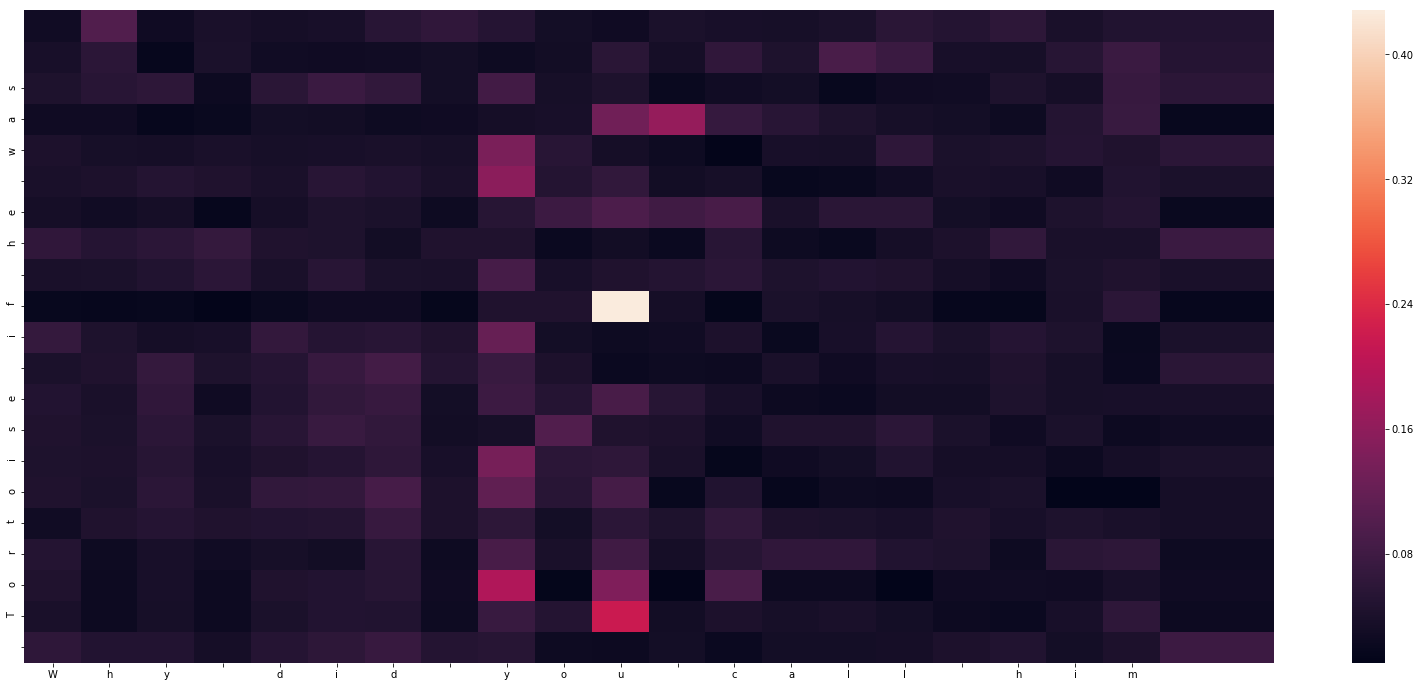

-
Input sentence: Why did you call him
GT sentence:  Tortoise, if he was
Decoded sentence:  Tortoise if he was


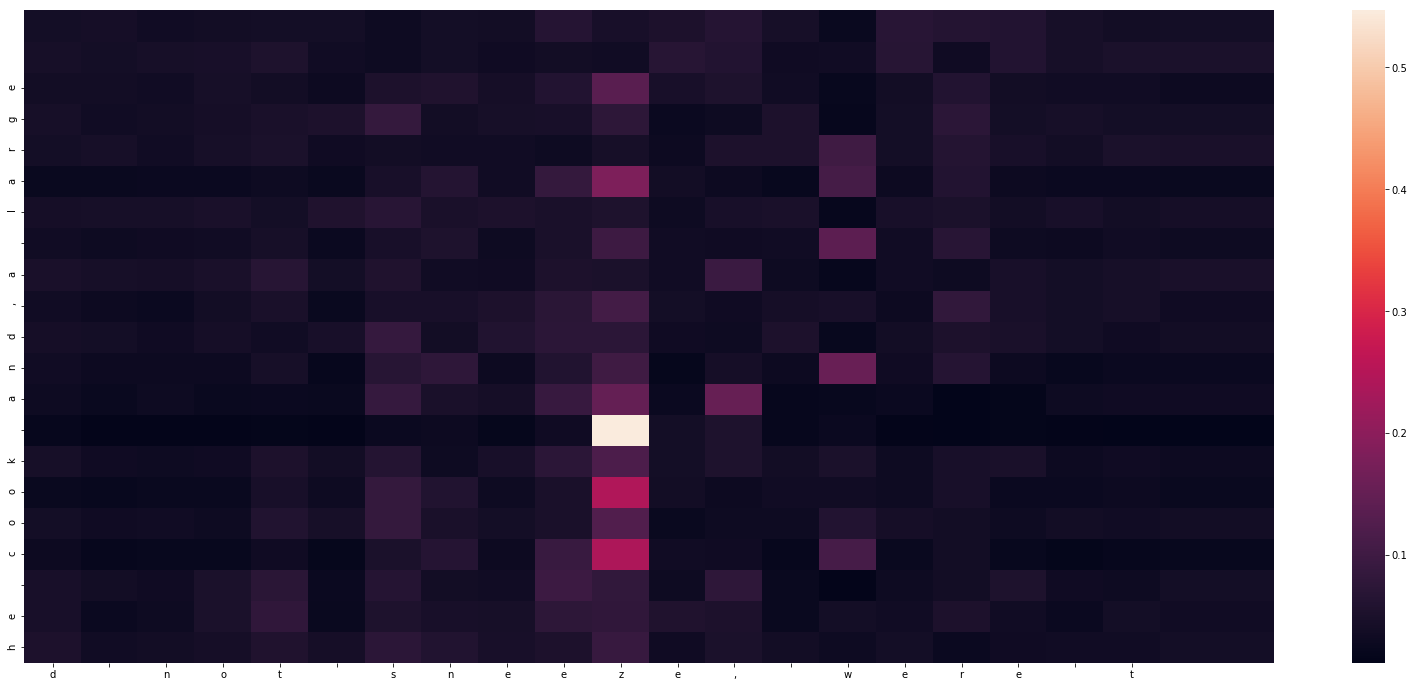

-
Input sentence: d not sneeze, were t
GT sentence: he cook, and a large
Decoded sentence: he cook and,a large


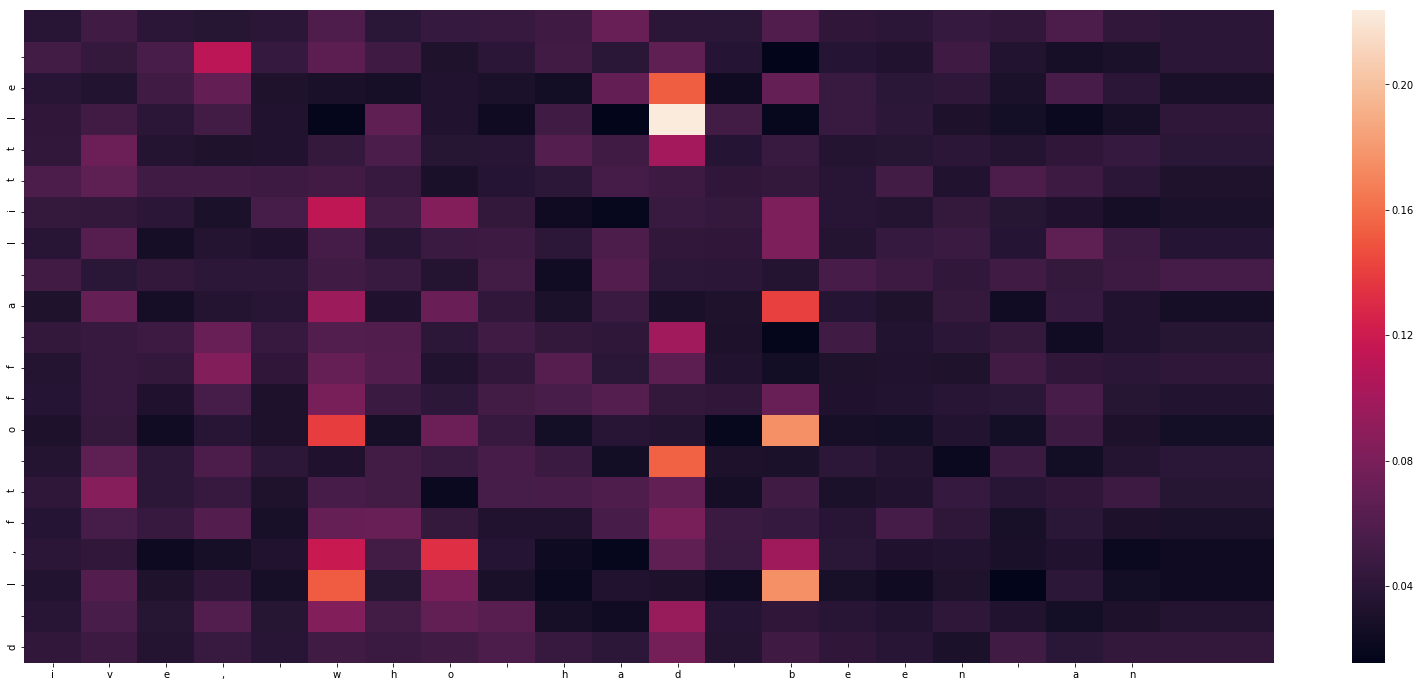

-
Input sentence: ive, who had been an
GT sentence: xiously looking acro
Decoded sentence: d l,ft off a little 


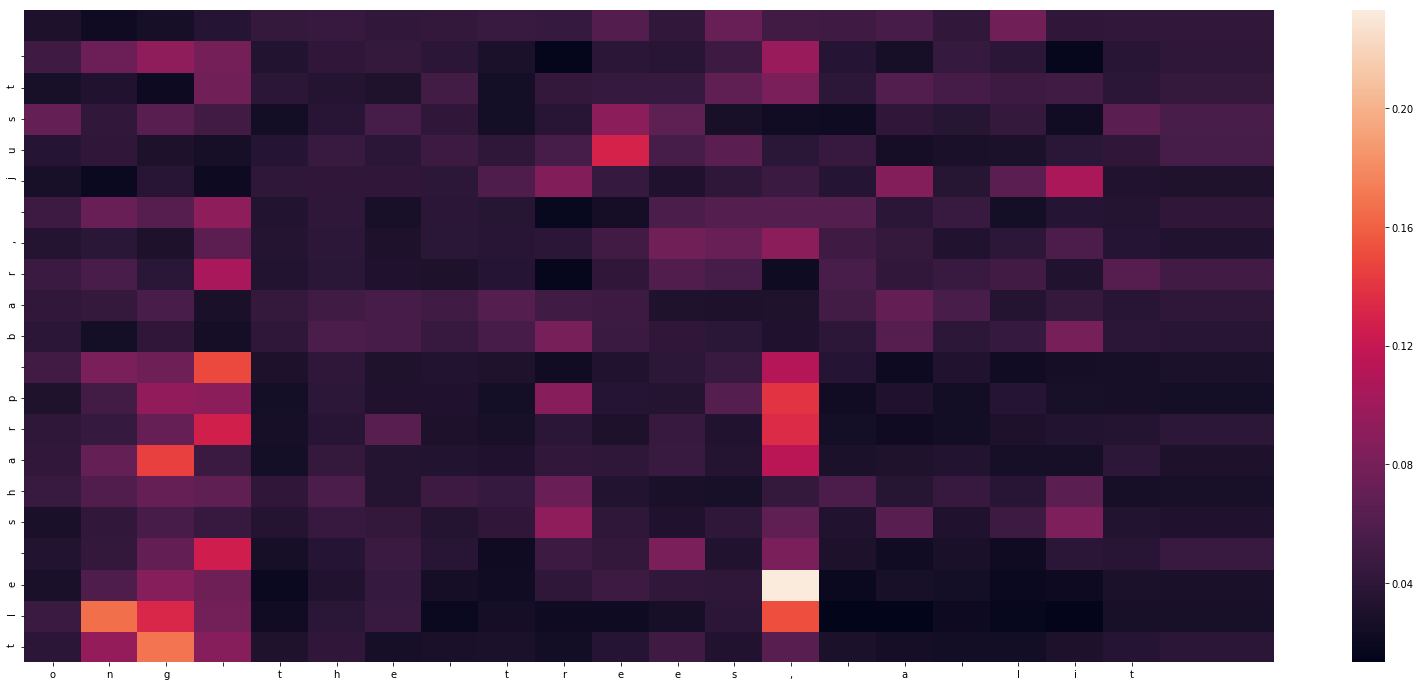

-
Input sentence: ong
the trees, a lit
GT sentence: tle sharp bark just 
Decoded sentence: tle sharp bar, just 


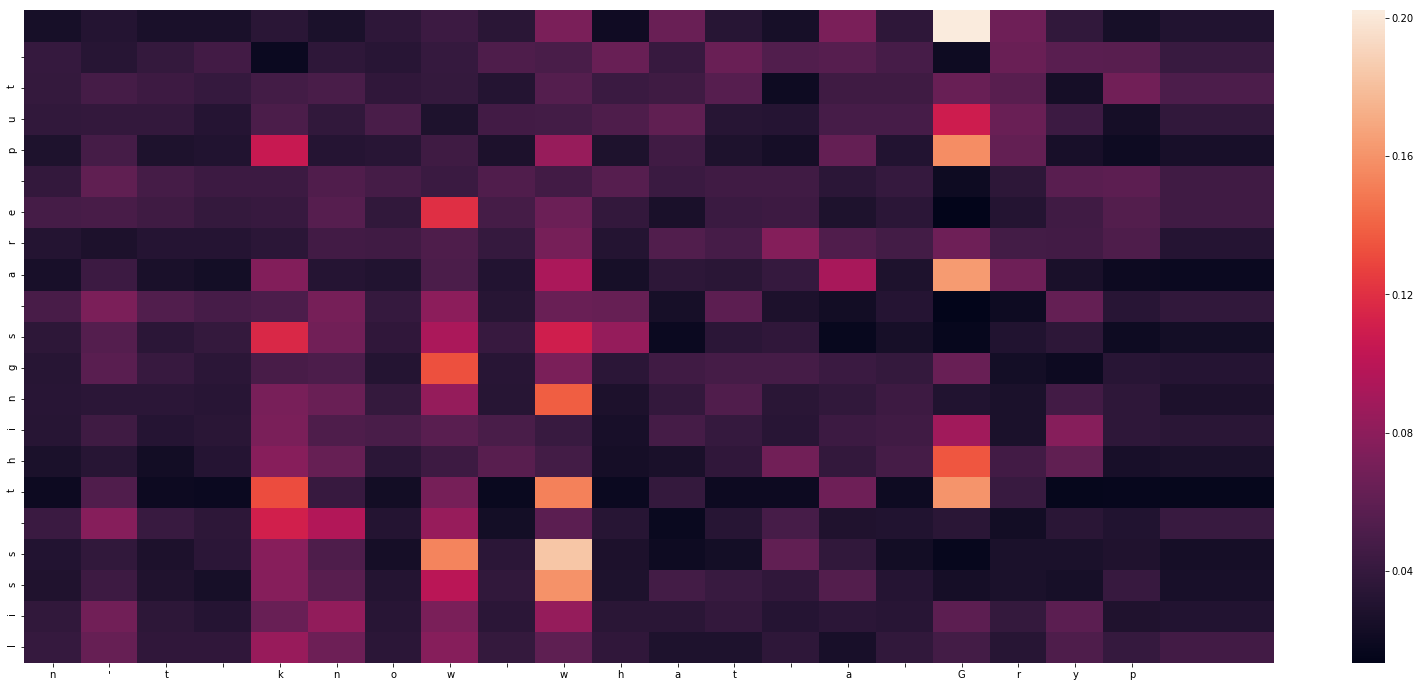

-
Input sentence: n't know what a Gryp
GT sentence: hon is, look at the 
Decoded sentence: liss things are put 


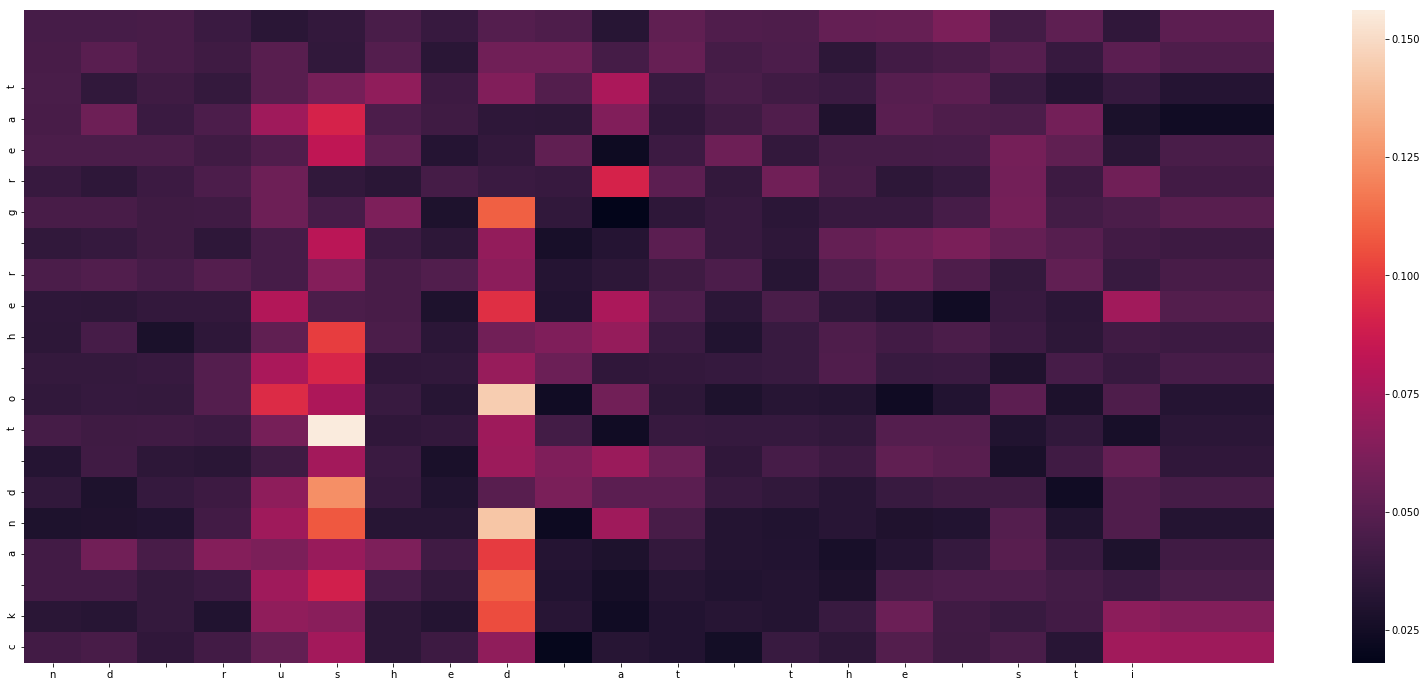

-
Input sentence: nd rushed at the sti
GT sentence: ck,
and made believe
Decoded sentence: ck and to her great


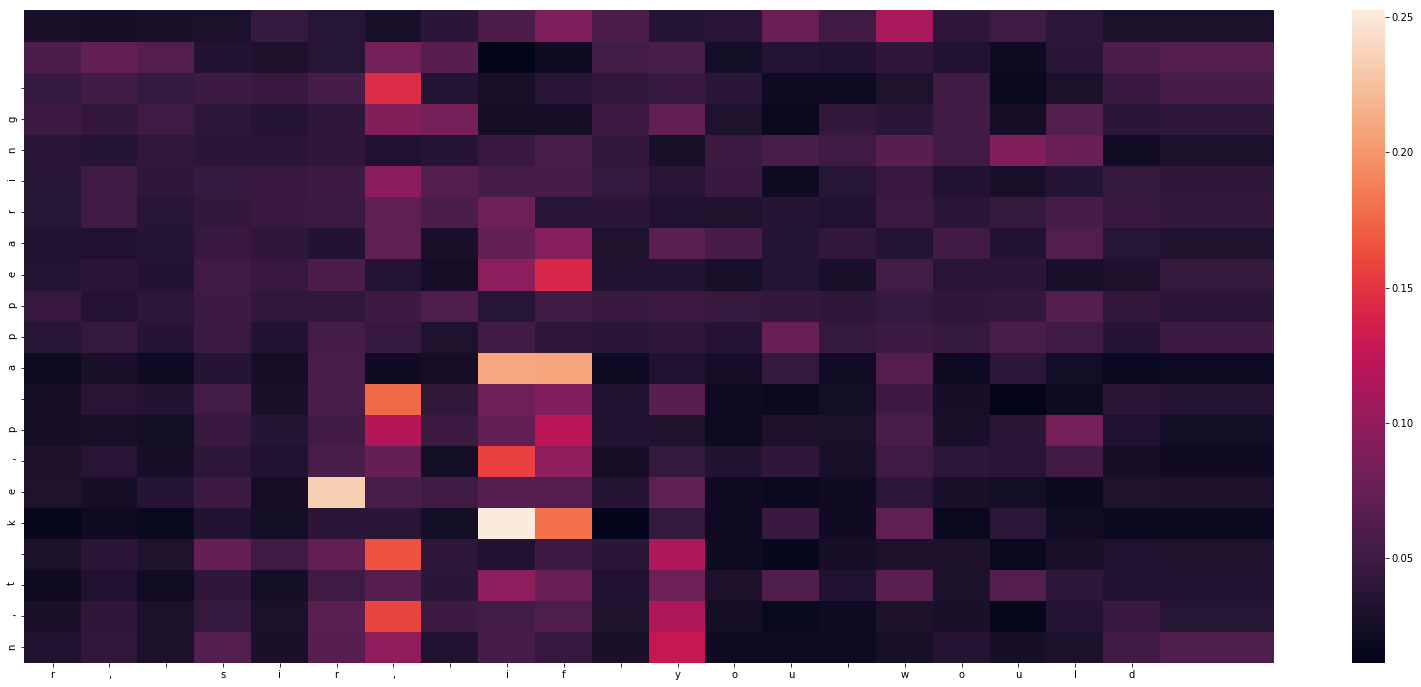

-
Input sentence: r, sir, if you would
GT sentence: n't mind,'
said Alic
Decoded sentence: n,t ke,p appearing 


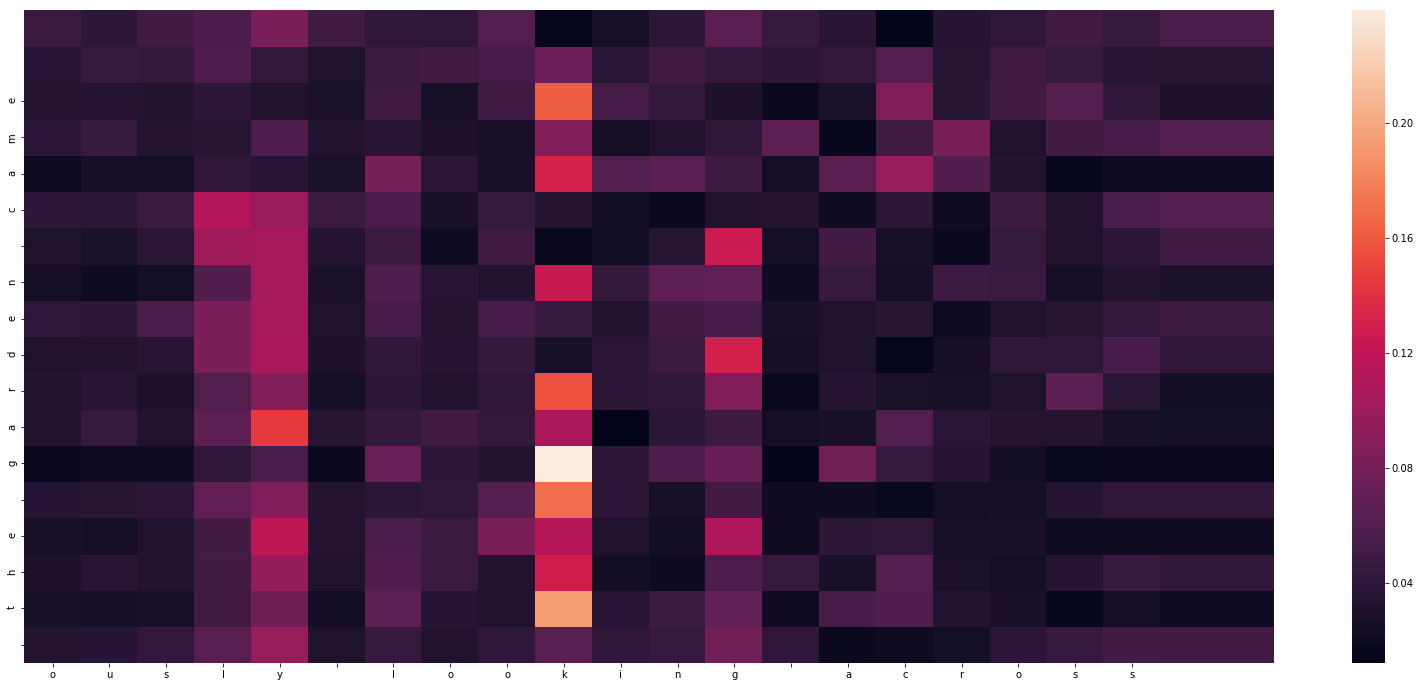

-
Input sentence: ously looking across
GT sentence:  the garden, called

Decoded sentence:  the garden came


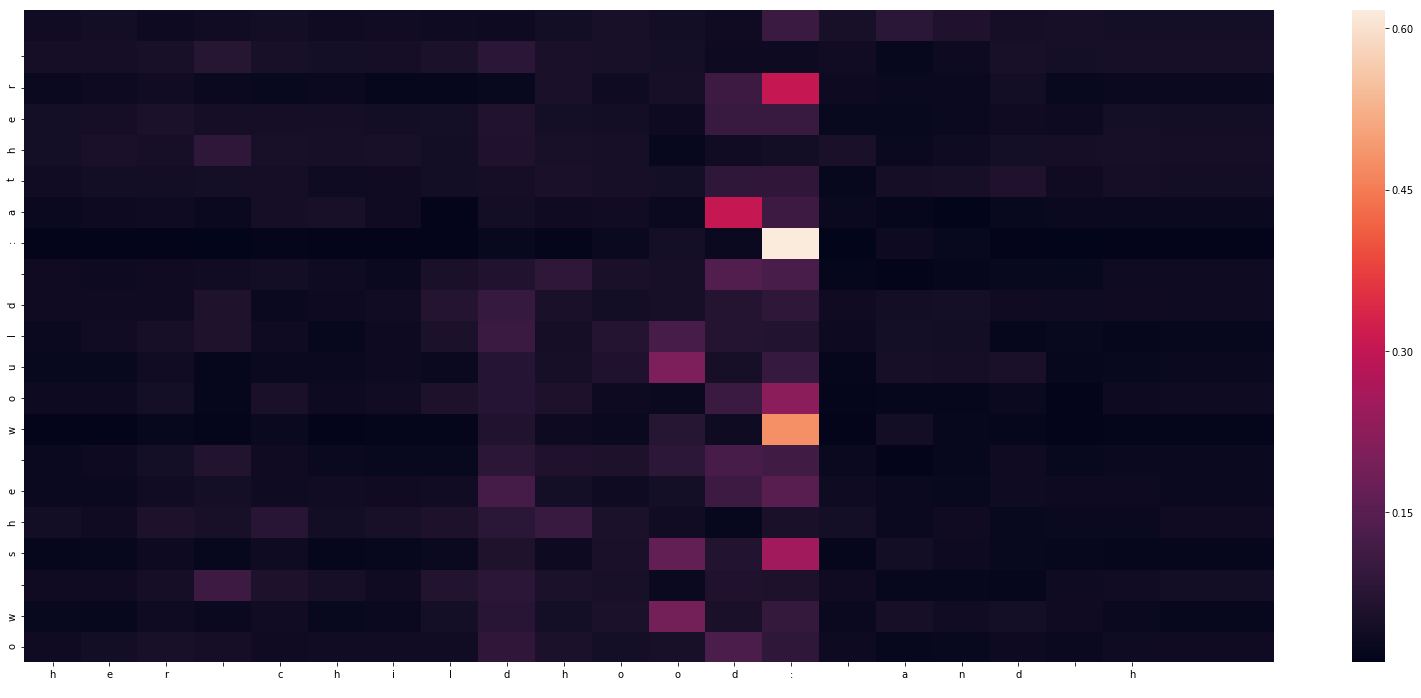

-
Input sentence: her
childhood: and h
GT sentence: ow she would gather 
Decoded sentence: ow she would :ather 


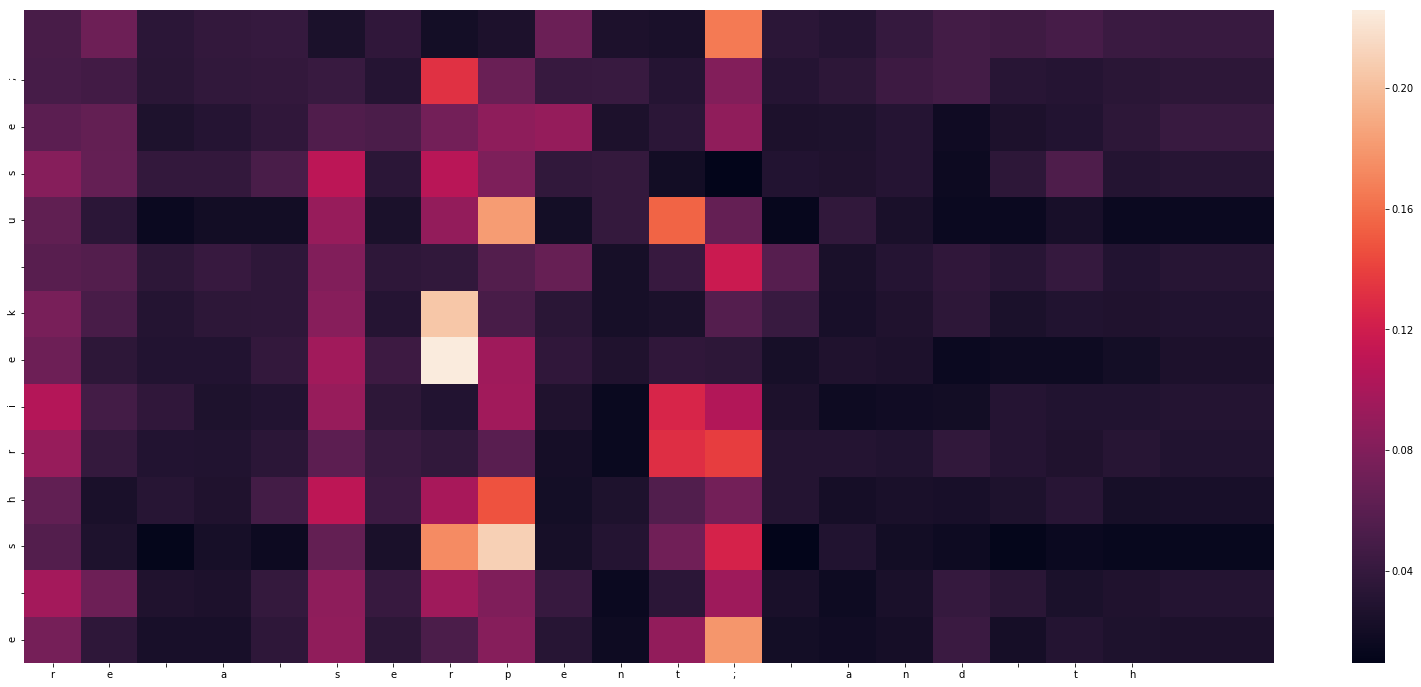

-
Input sentence: re a serpent; and th
GT sentence: ere's no use
denying
Decoded sentence: e shriek use;


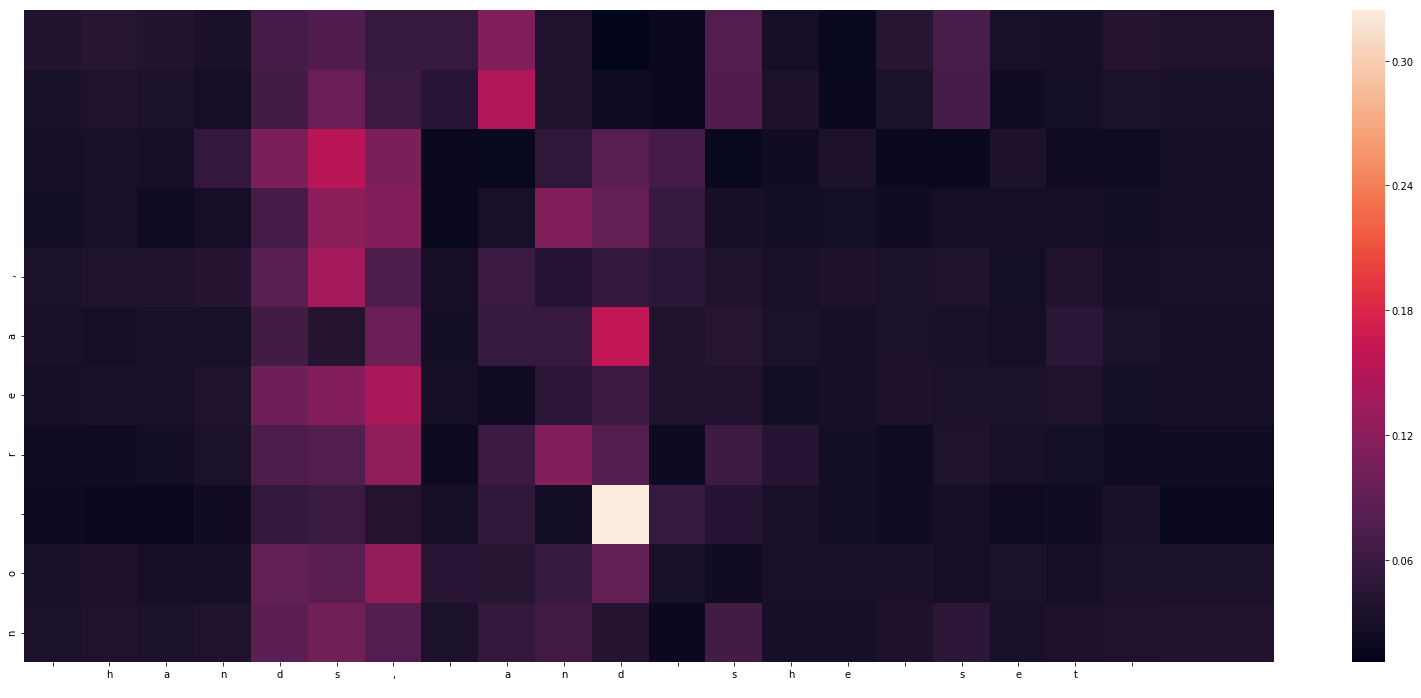

-
Input sentence:  hands, and
she set 
GT sentence: to work very careful
Decoded sentence: no rea,


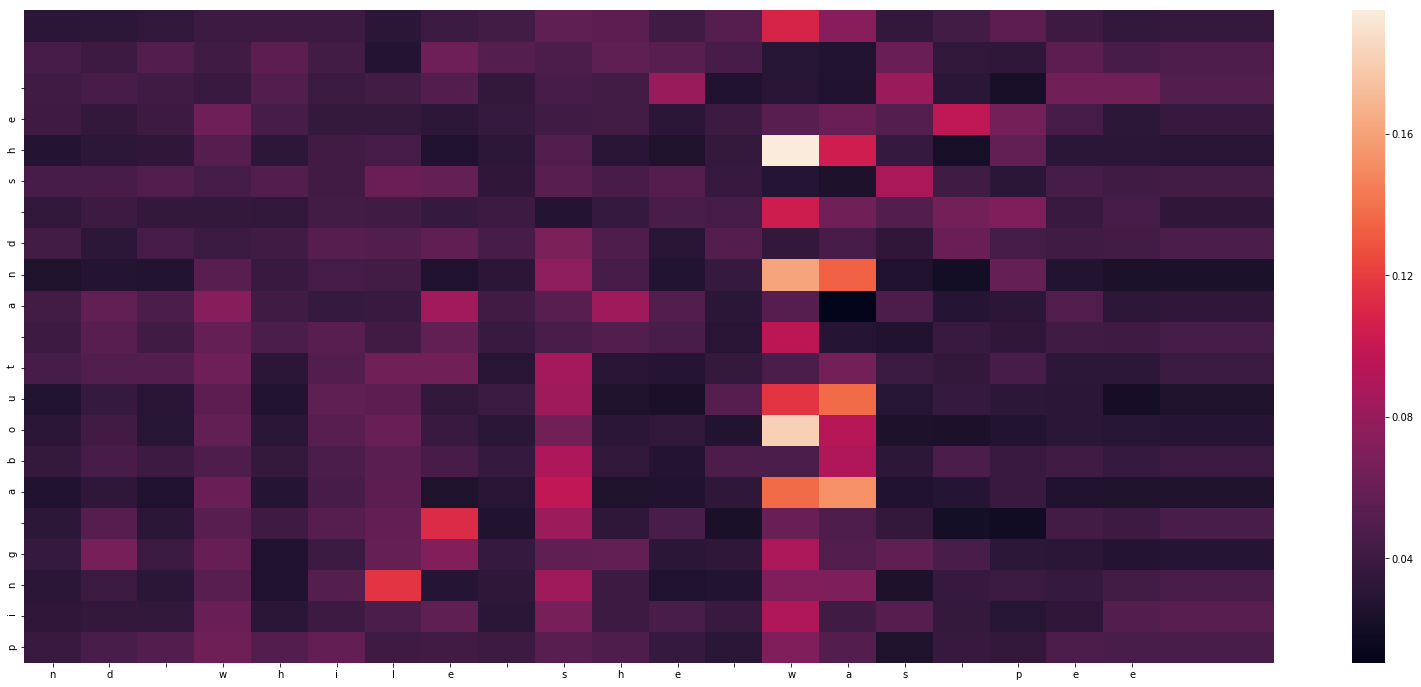

-
Input sentence: nd while she was pee
GT sentence: ring about anxiously
Decoded sentence: ping about and she 


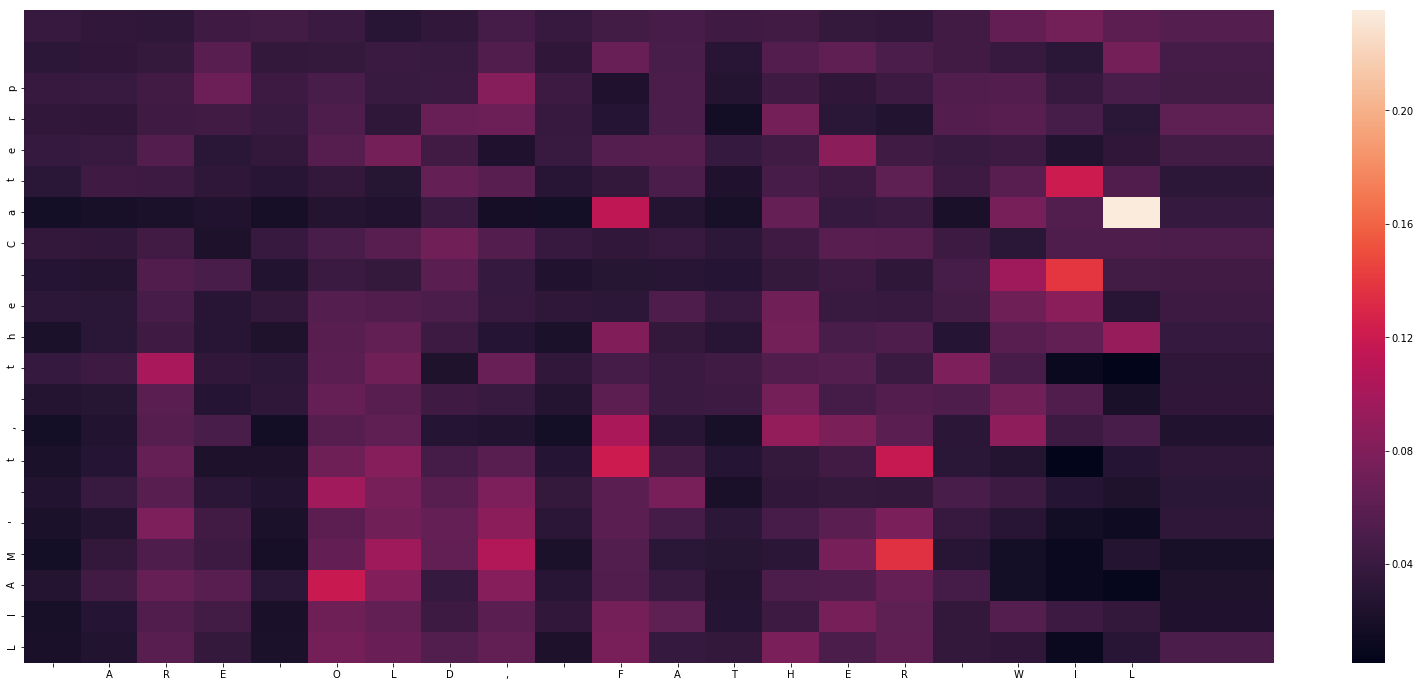

-
Input sentence:  ARE OLD, FATHER WIL
GT sentence: LIAM,"' said the Cat
Decoded sentence: LIAM' t, the Caterp


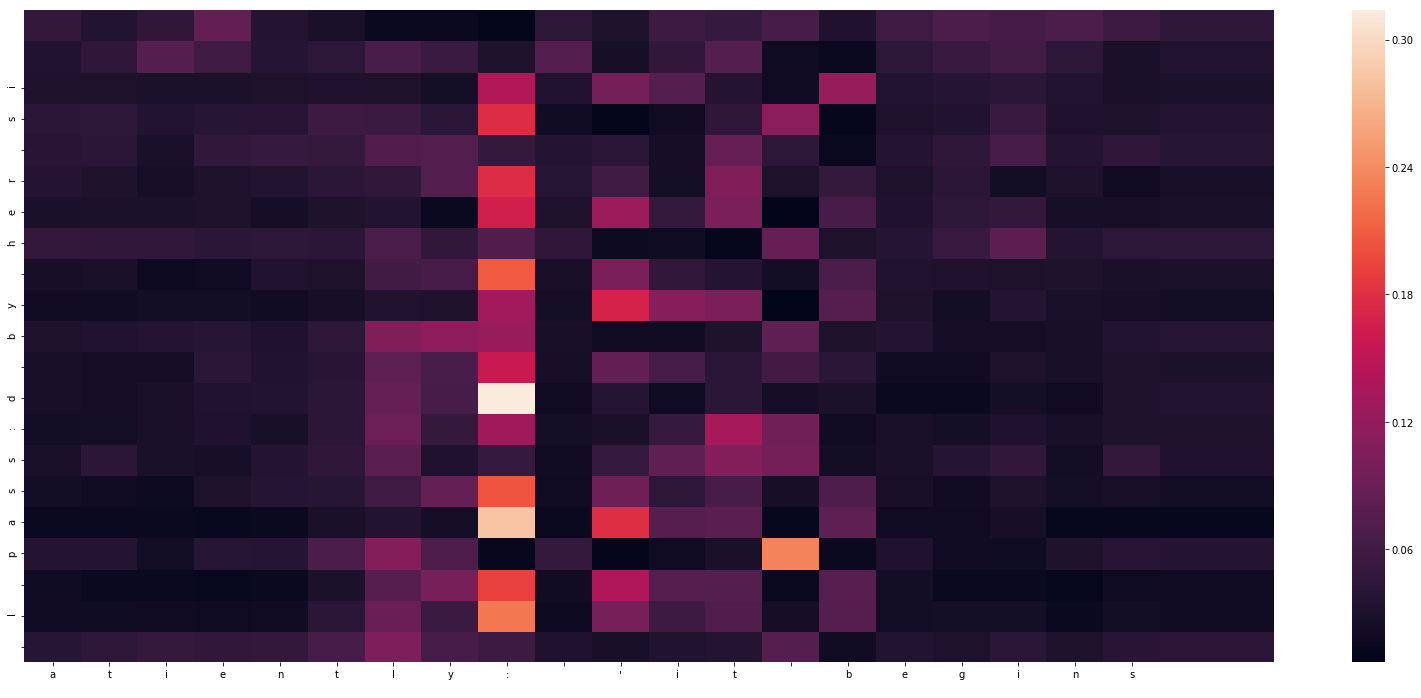

-
Input sentence: atiently: 'it
begins
GT sentence:  "I passed by his ga
Decoded sentence:  I pass:d by her si


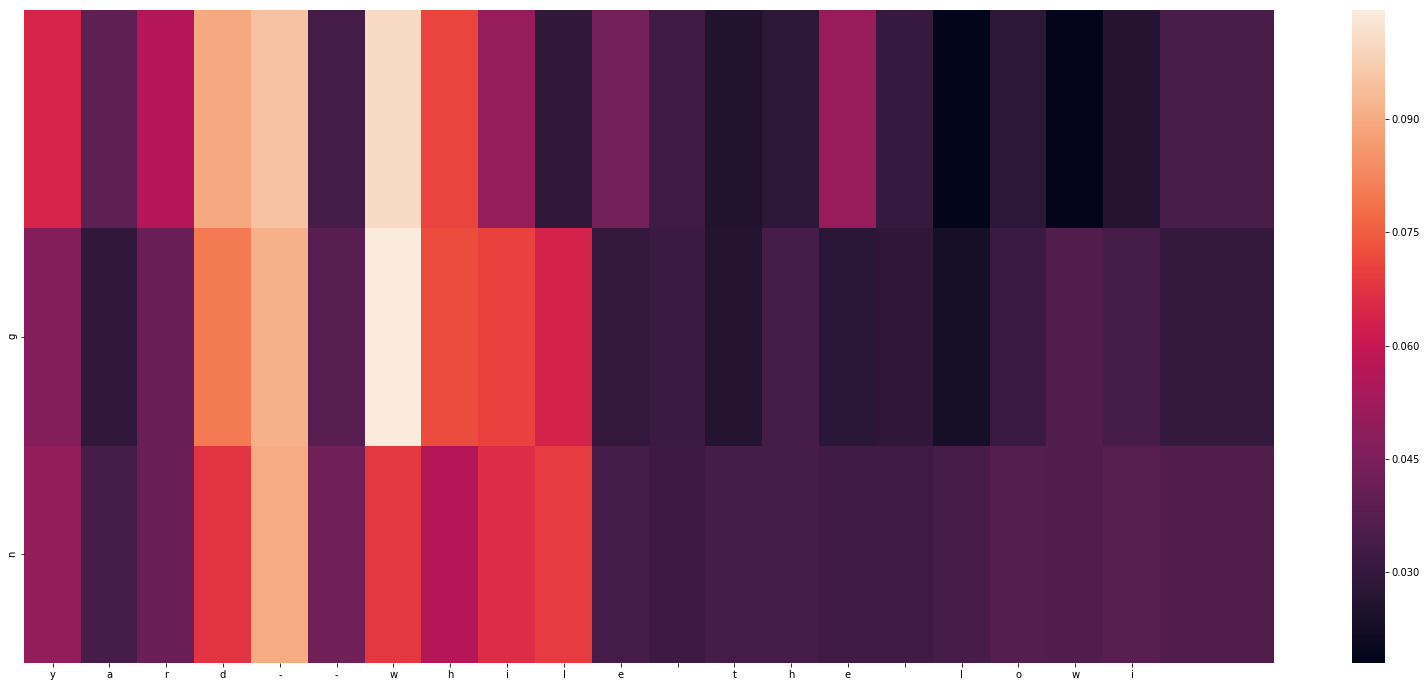

-
Input sentence: yard--while the lowi
GT sentence: ng
of the cattle in 
Decoded sentence: ng


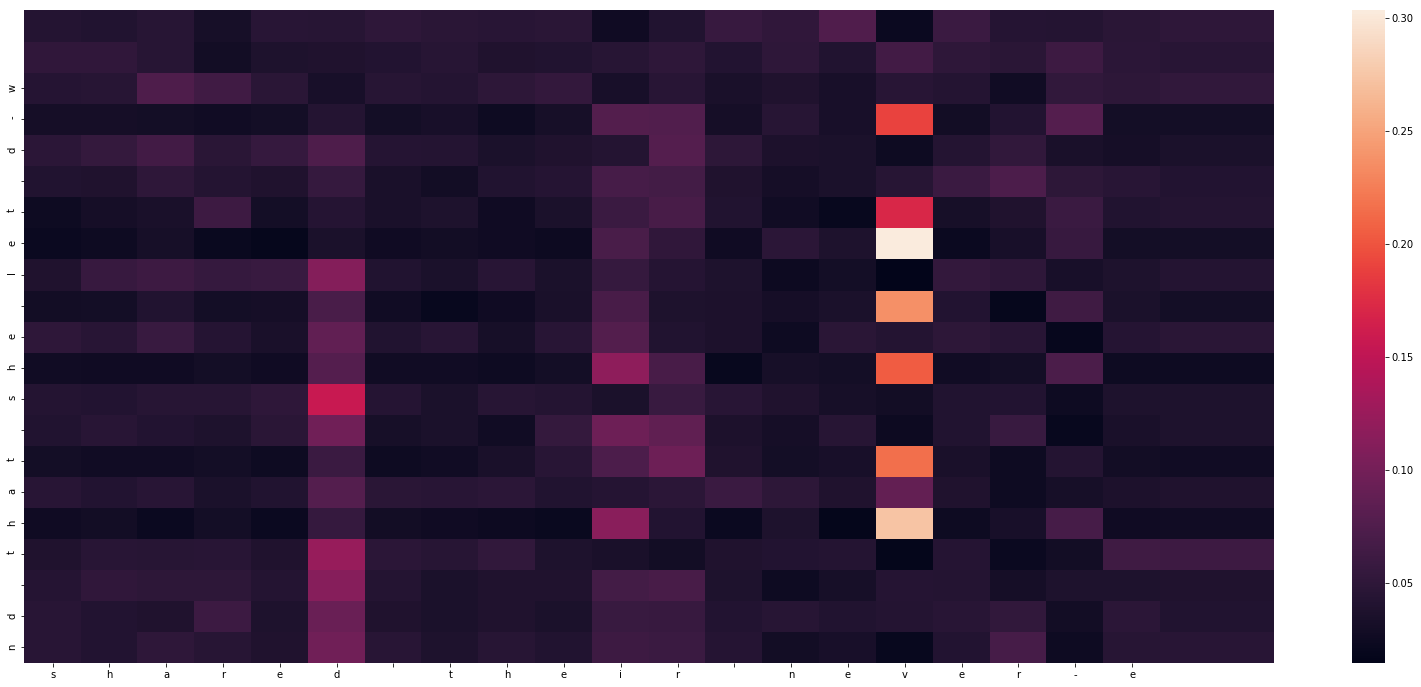

-
Input sentence: shared their never-e
GT sentence: nding meal, and the 
Decoded sentence: nd that she let d-w


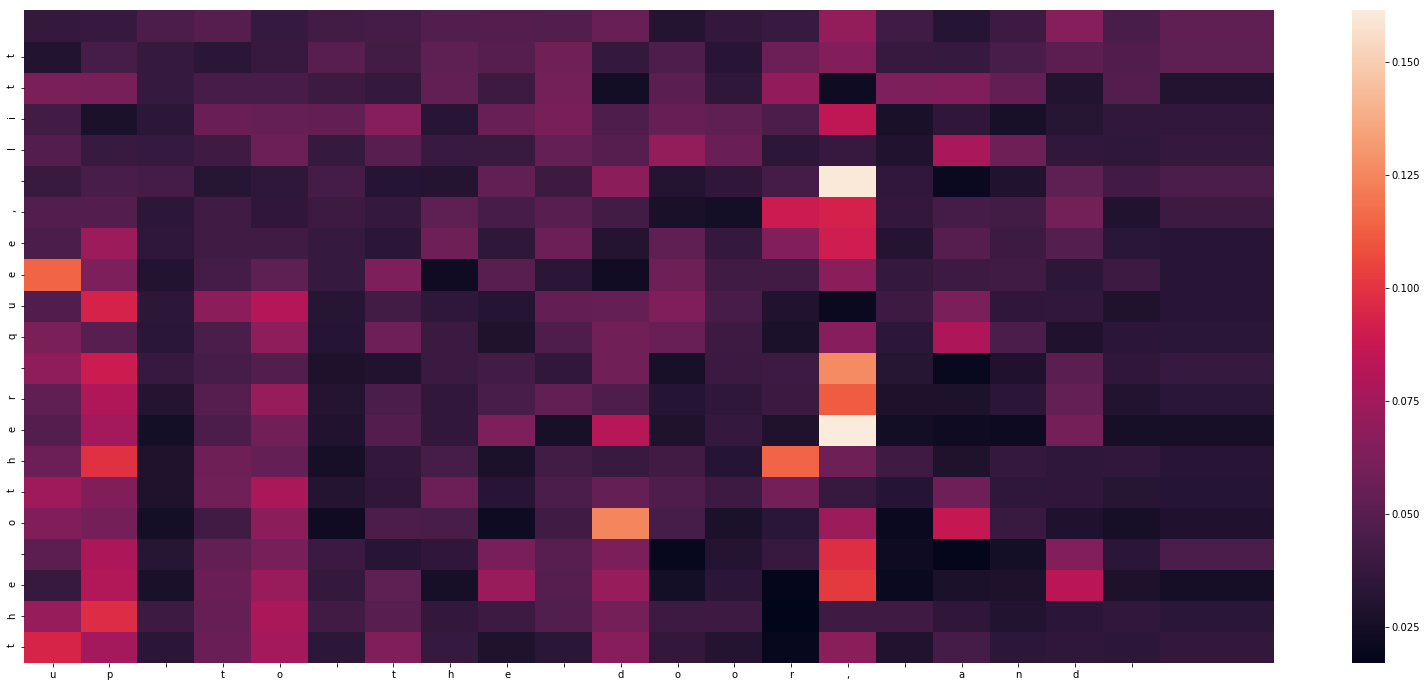

-
Input sentence: up to the door, and 
GT sentence: tried to open it; bu
Decoded sentence: the other quee, litt


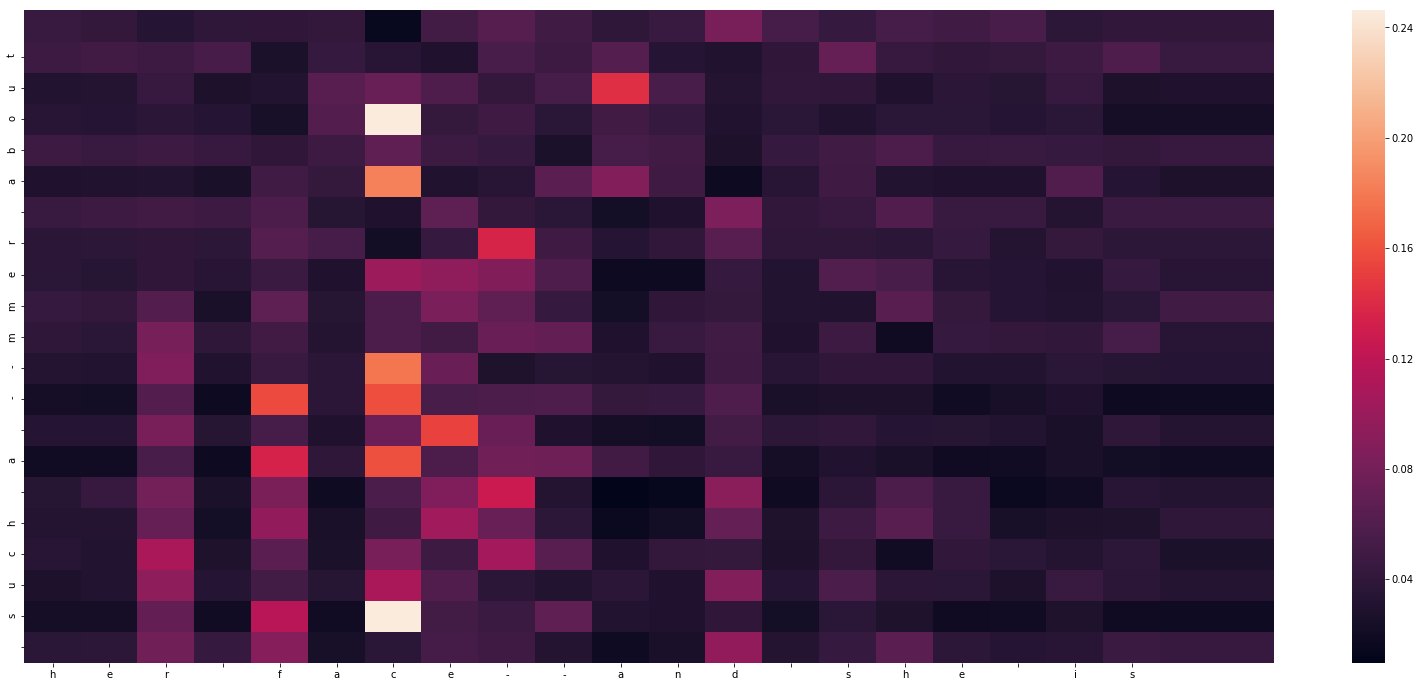

-
Input sentence: her face--and she is
GT sentence:  such a nice soft th
Decoded sentence:  such a --mmer about


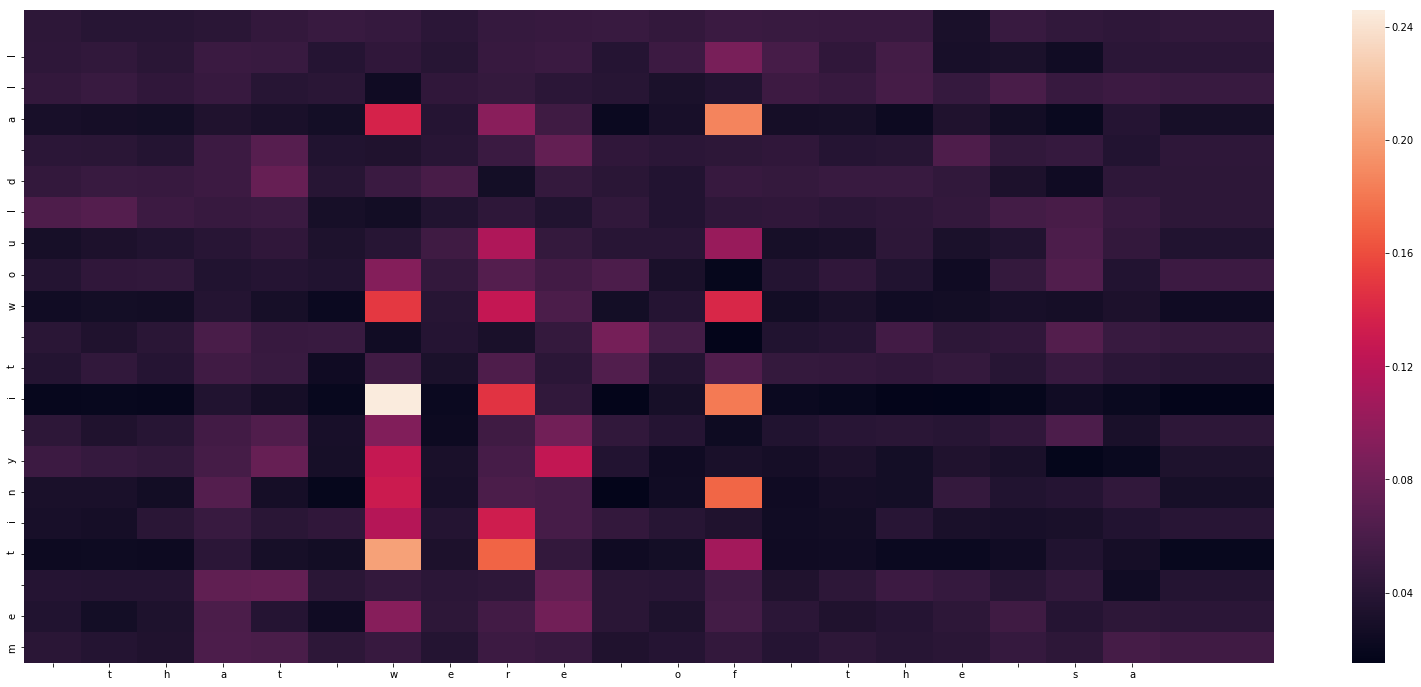

-
Input sentence:  that were of the sa
GT sentence: me age as herself, t
Decoded sentence: me tiny it would all


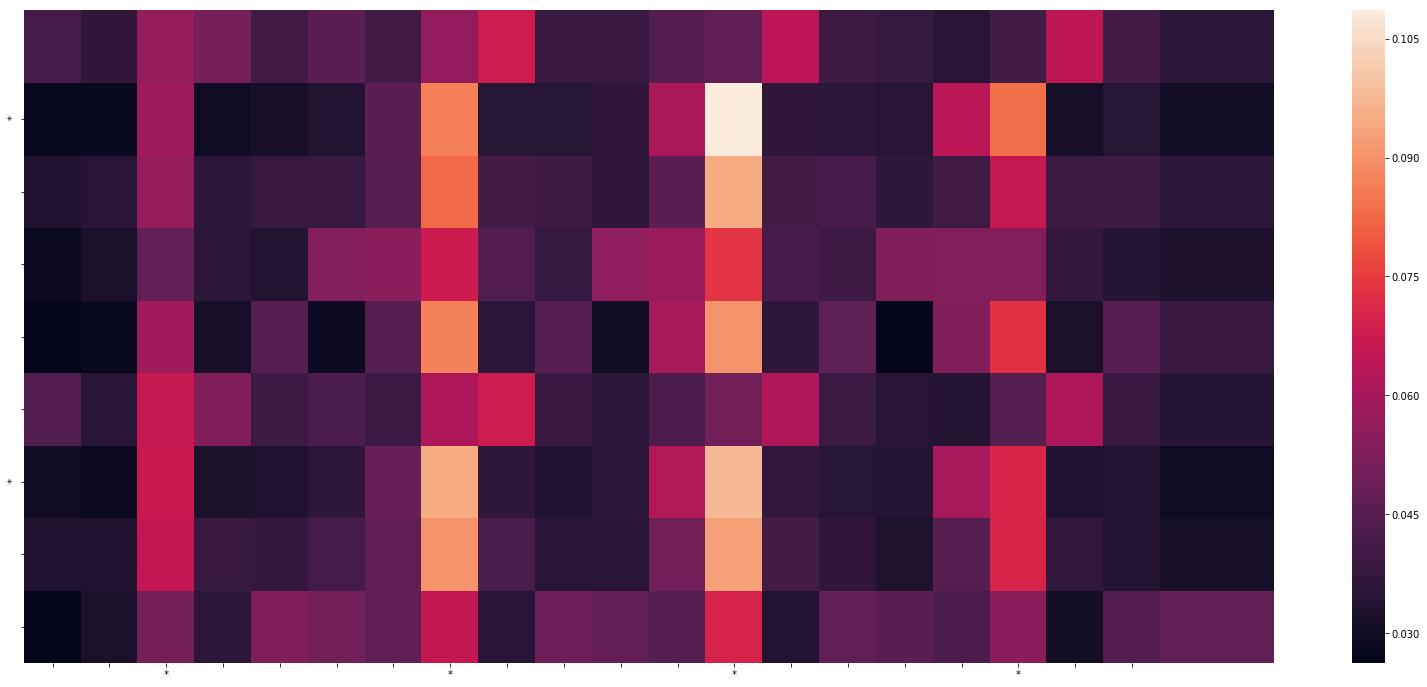

-
Input sentence:   *    *    *    *  
GT sentence:   *    *

  *    *  
Decoded sentence:   *    *


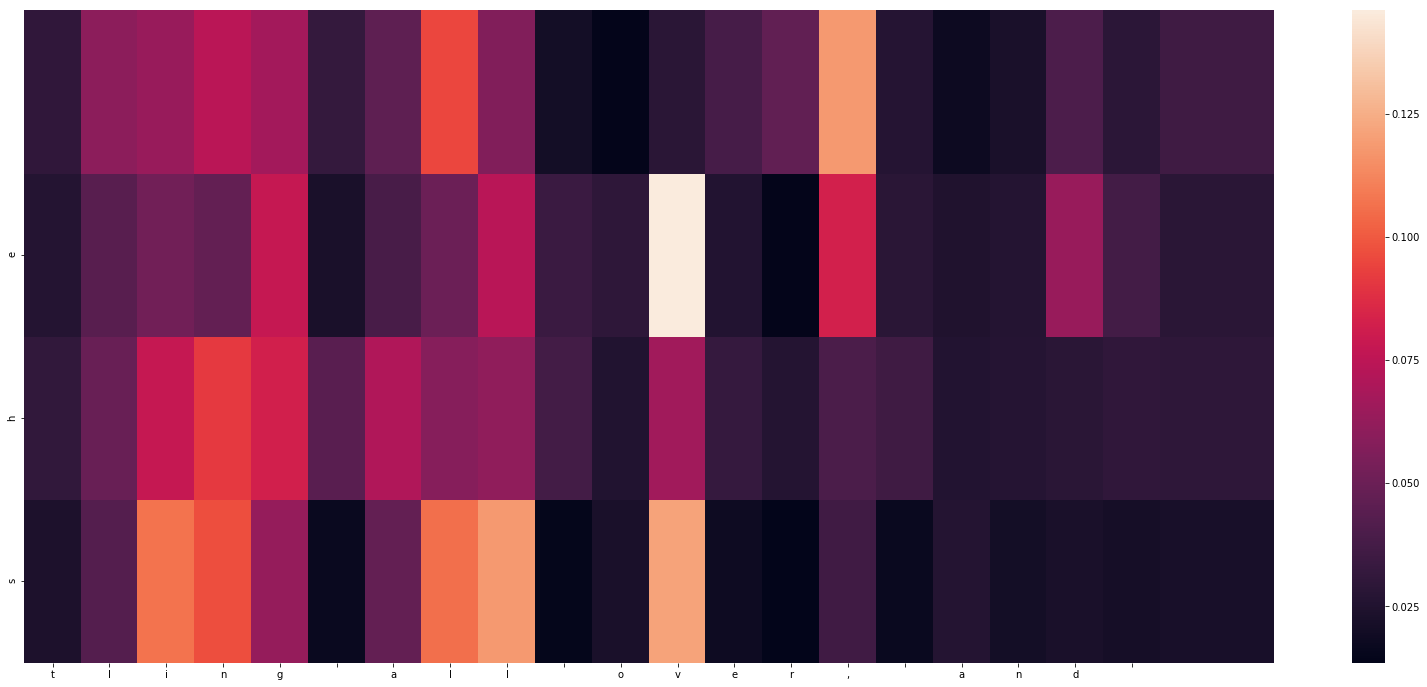

-
Input sentence: tling all over, and 
GT sentence: she
felt certain it 
Decoded sentence: she


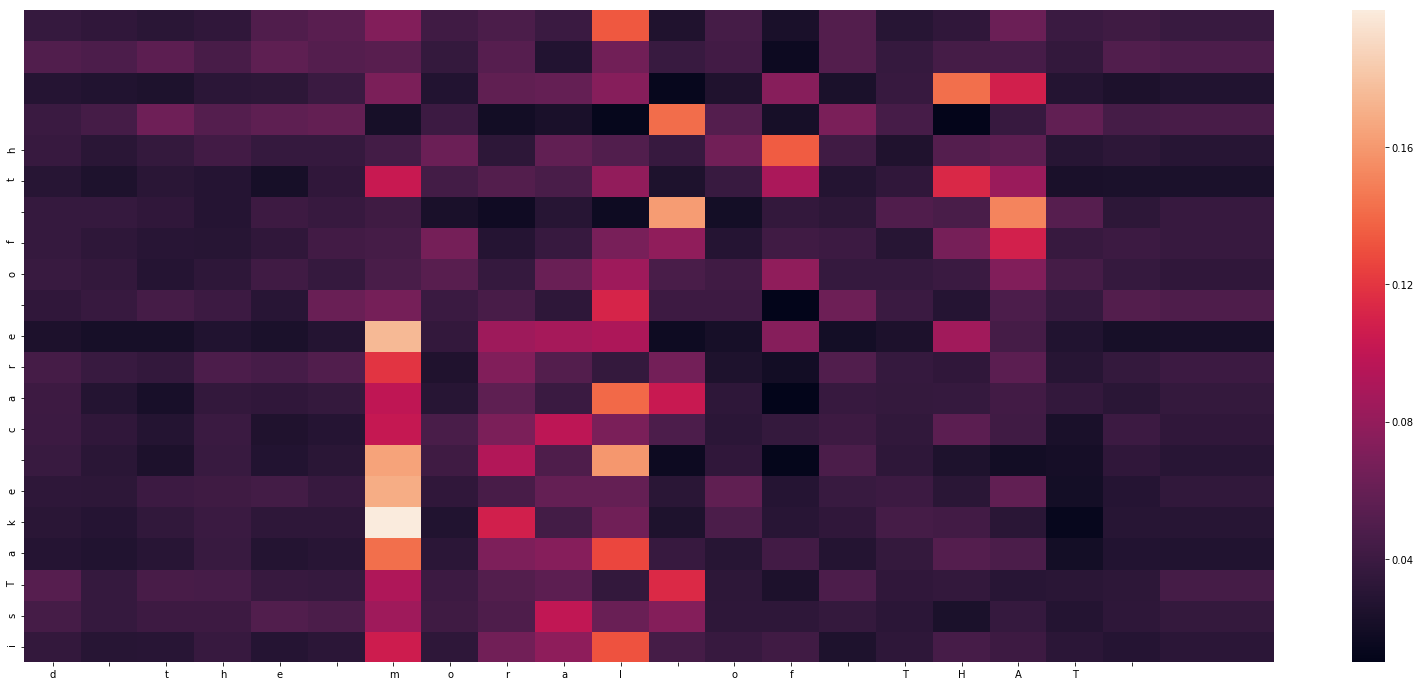

-
Input sentence: d the moral
of THAT 
GT sentence: is--"Take care of th
Decoded sentence: isTake care of th


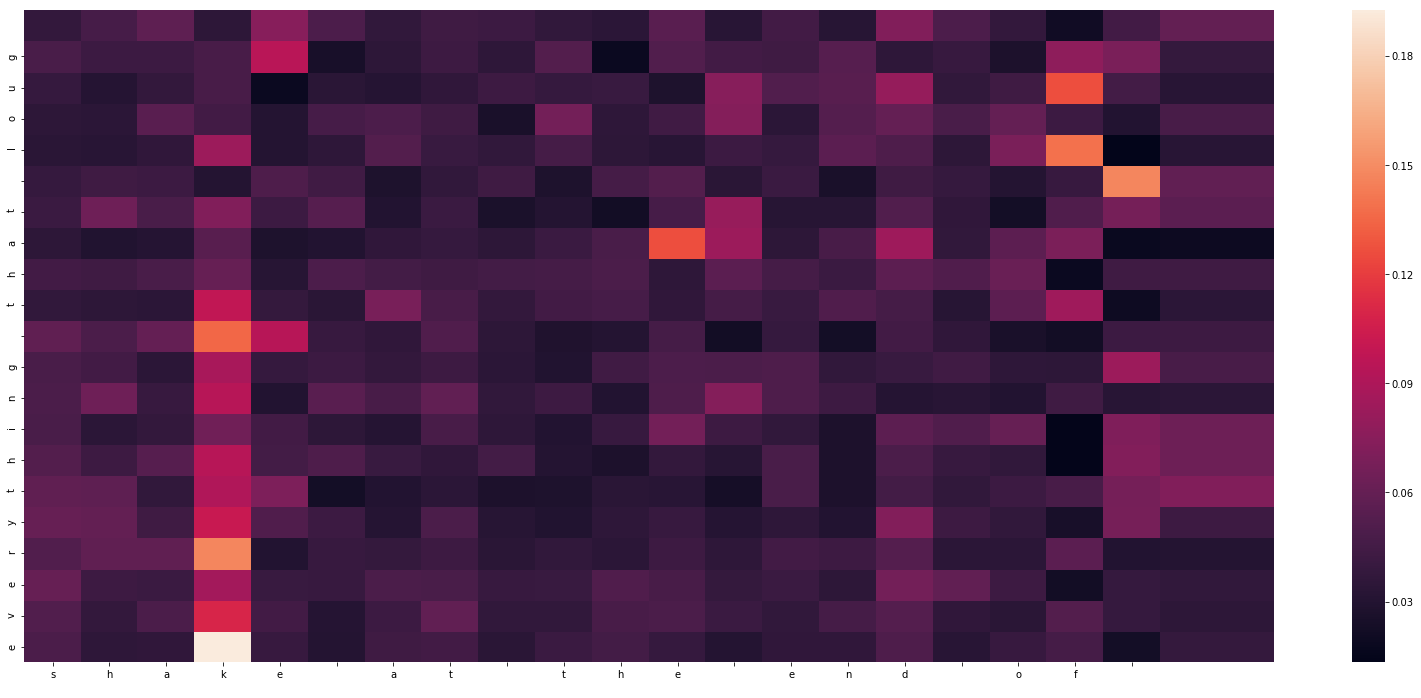

-
Input sentence: shake at the end of

GT sentence: every line:

   'Spe
Decoded sentence: everything that loug


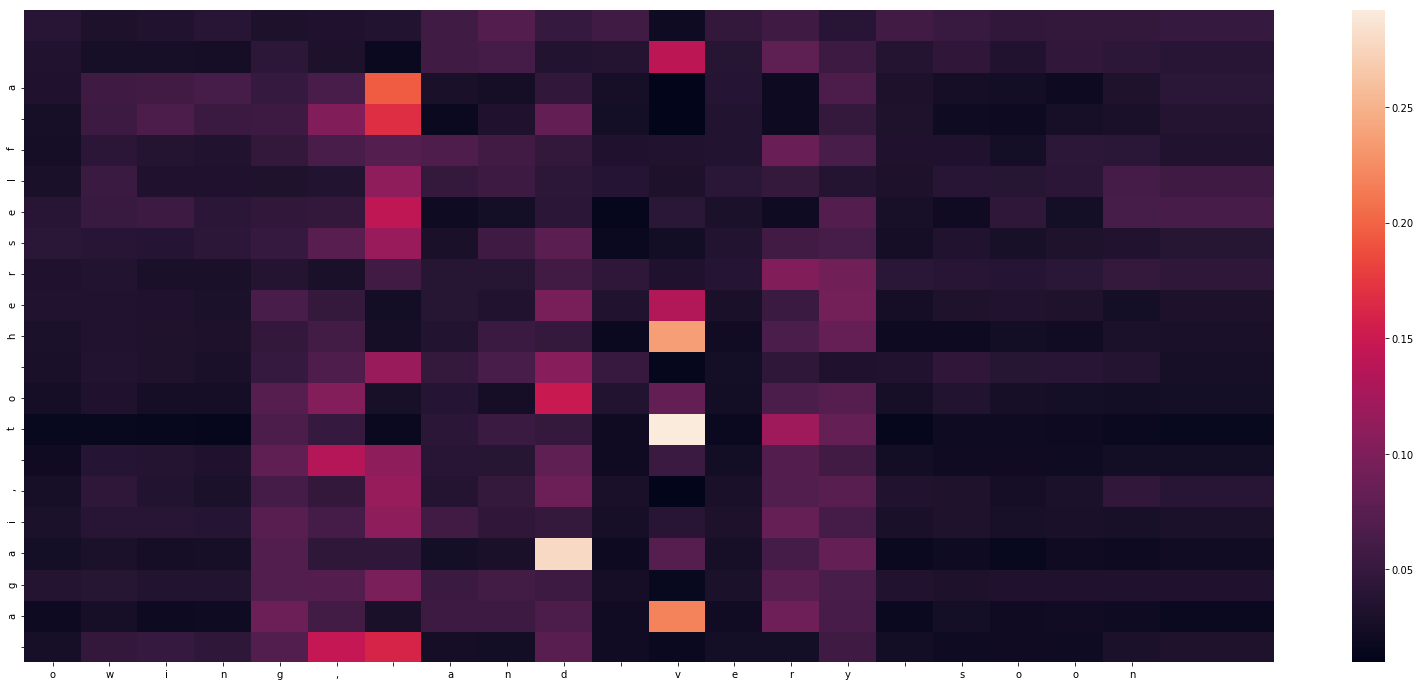

-
Input sentence: owing,
and very soon
GT sentence:  had to kneel down o
Decoded sentence:  agai, to herself a


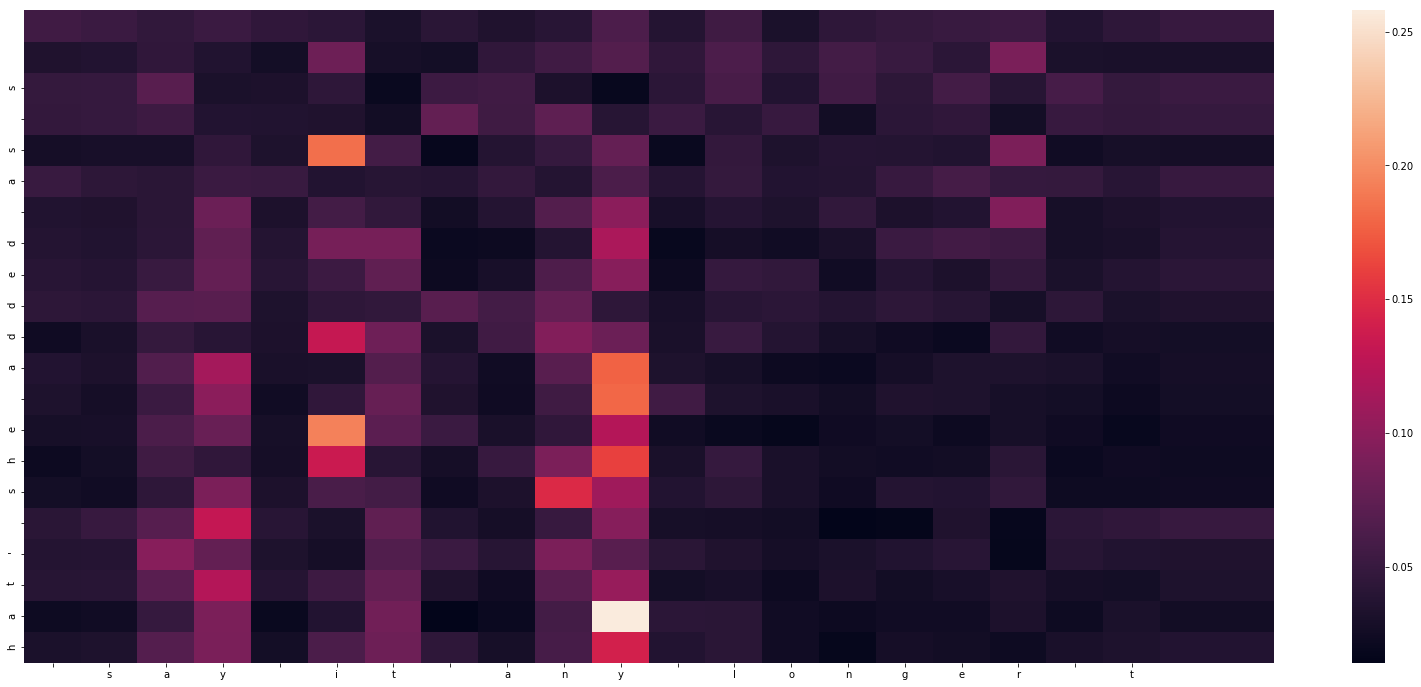

-
Input sentence:  say it any longer t
GT sentence: han that,' said
Alic
Decoded sentence: hat' she added as s


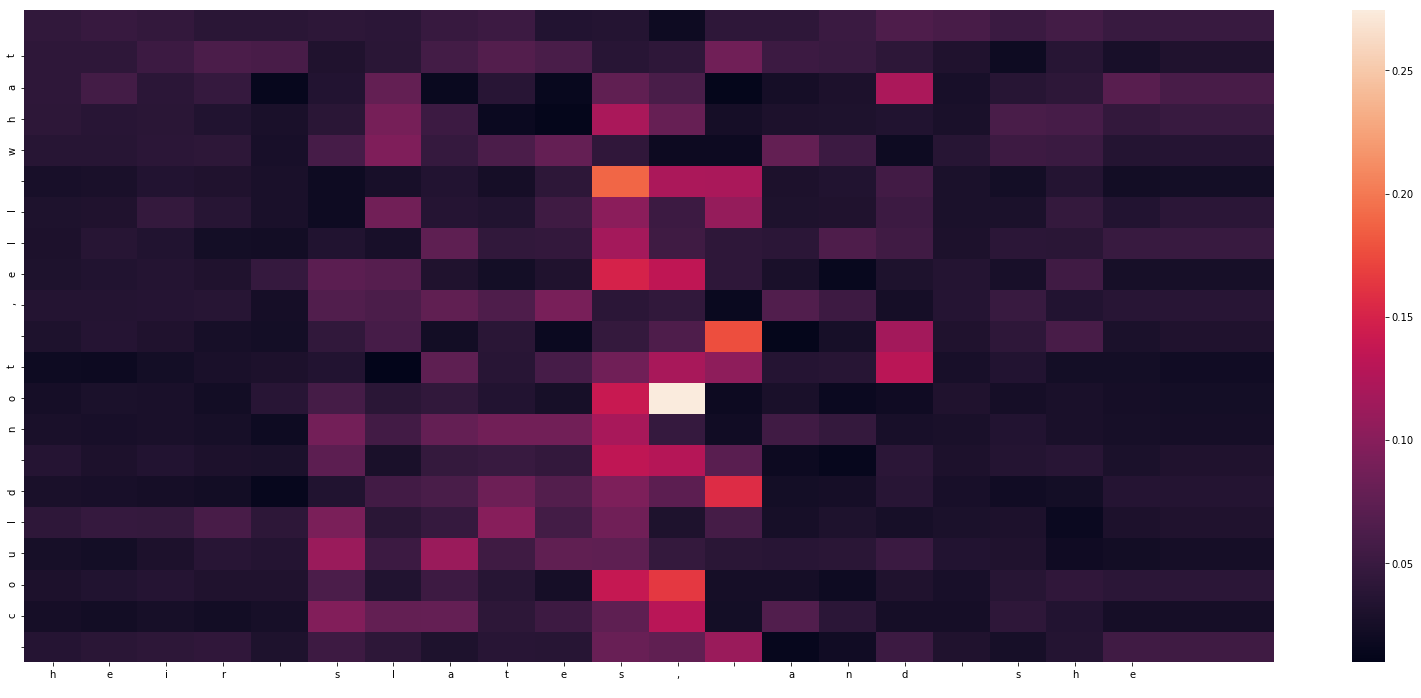

-
Input sentence: heir slates,
and she
GT sentence:  could even make out
Decoded sentence:  could not ,ell what


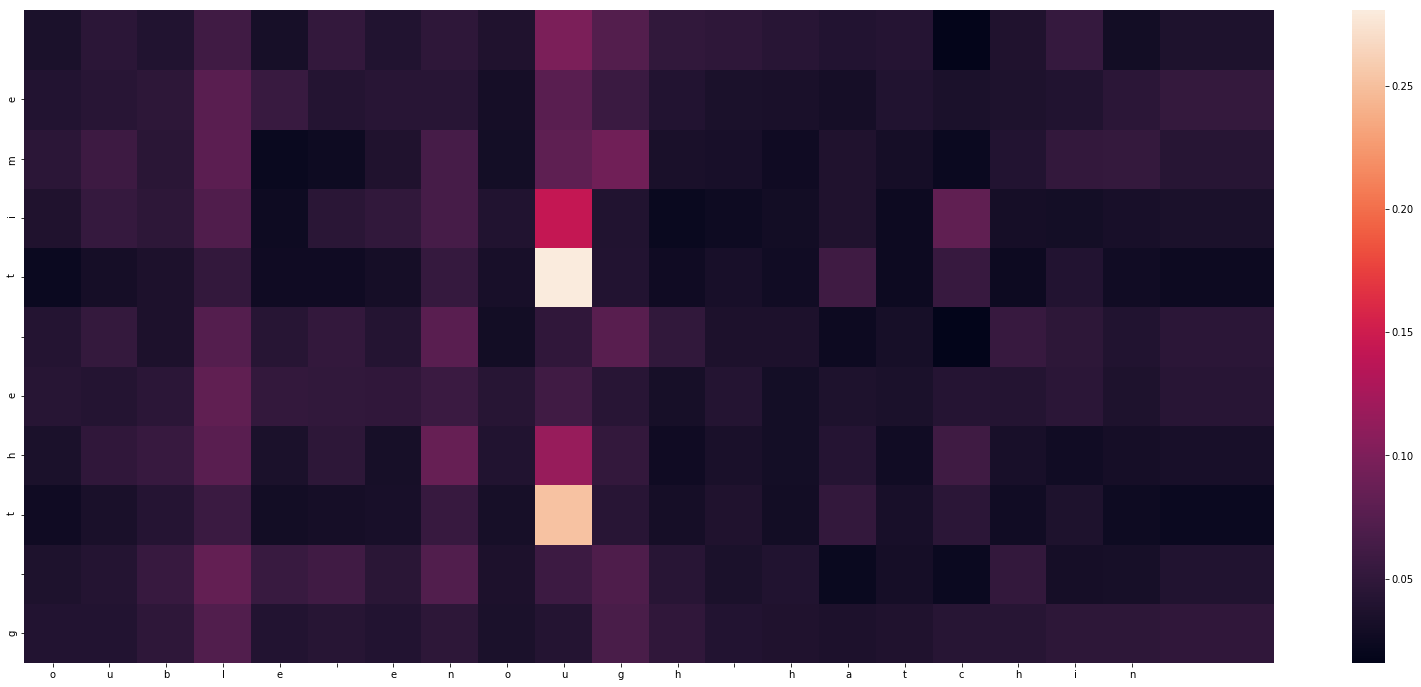

-
Input sentence: ouble enough hatchin
GT sentence: g the eggs,' said th
Decoded sentence: g the time


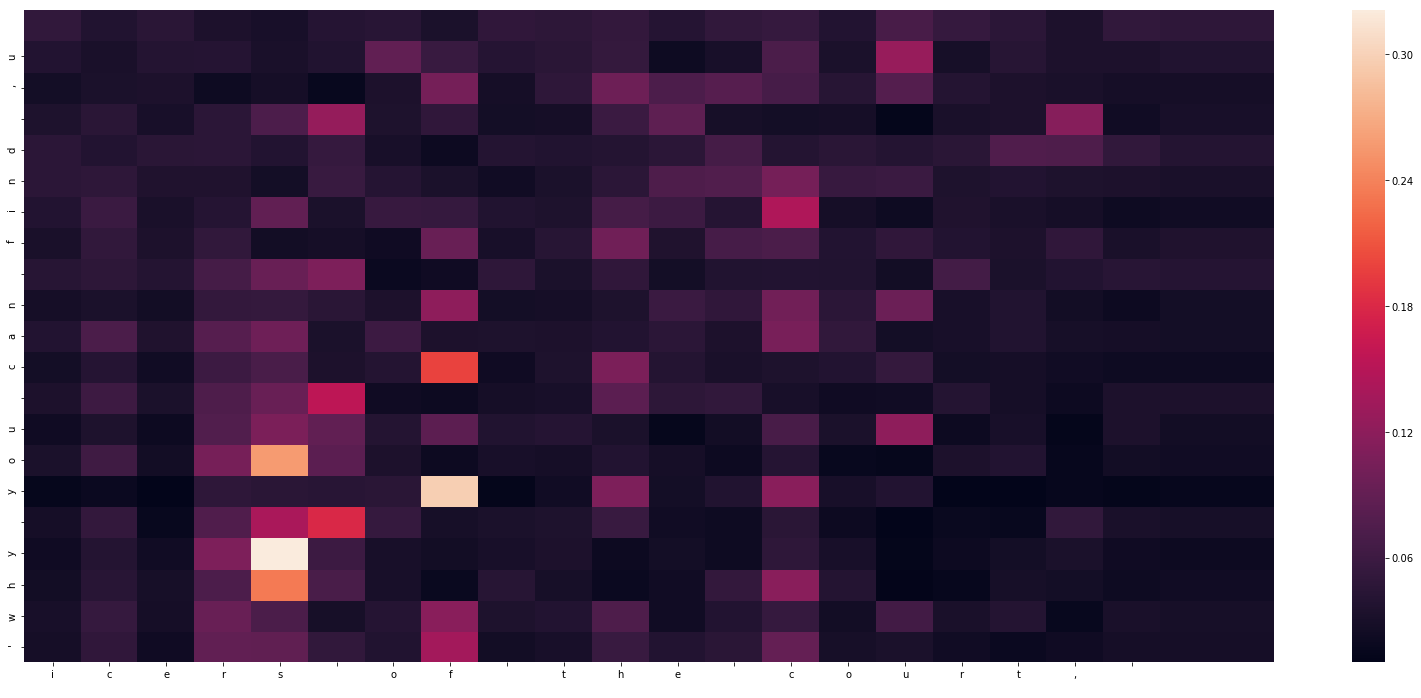

-
Input sentence: icers
of the court, 
GT sentence: 'Bring me the list o
Decoded sentence: 'why you can find ,u


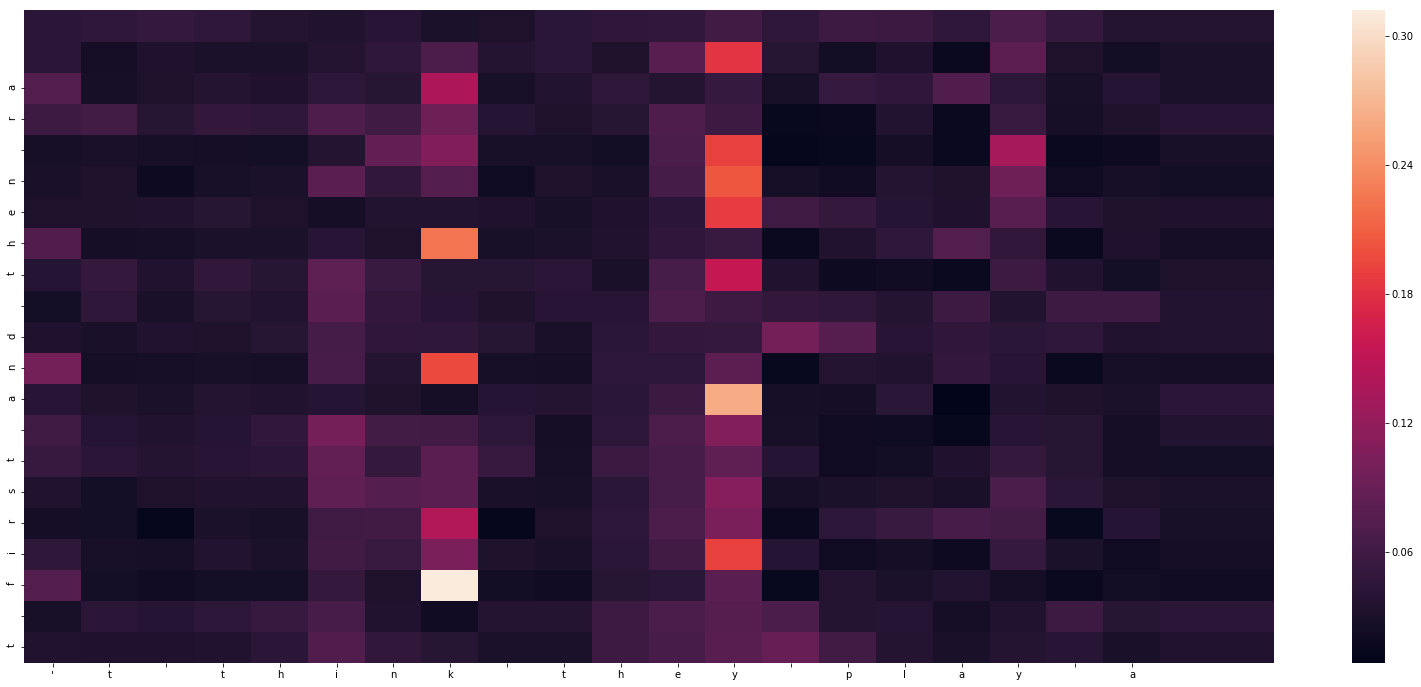

-
Input sentence: 't think they play a
GT sentence: t all fairly,' Alice
Decoded sentence: t first and then ra


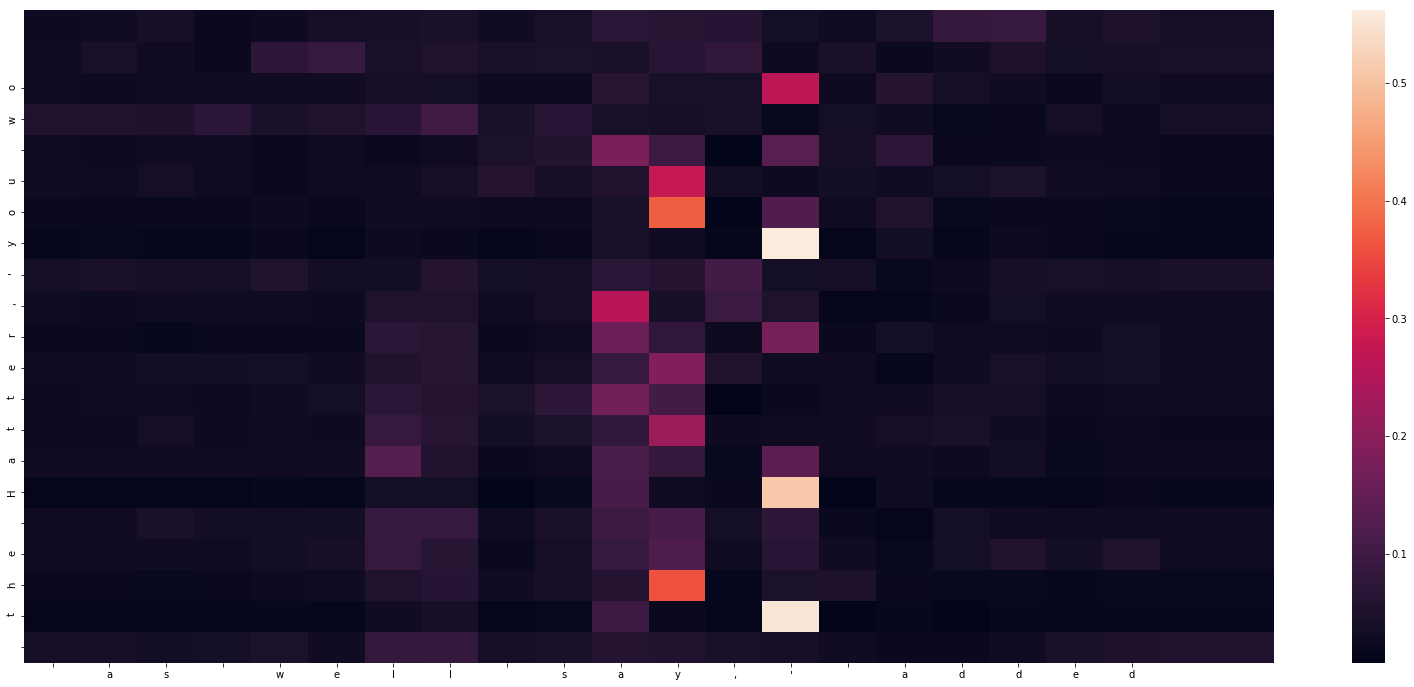

-
Input sentence:  as well say,' added
GT sentence:  the Dormouse, who s
Decoded sentence:  the Hatter,'you wo


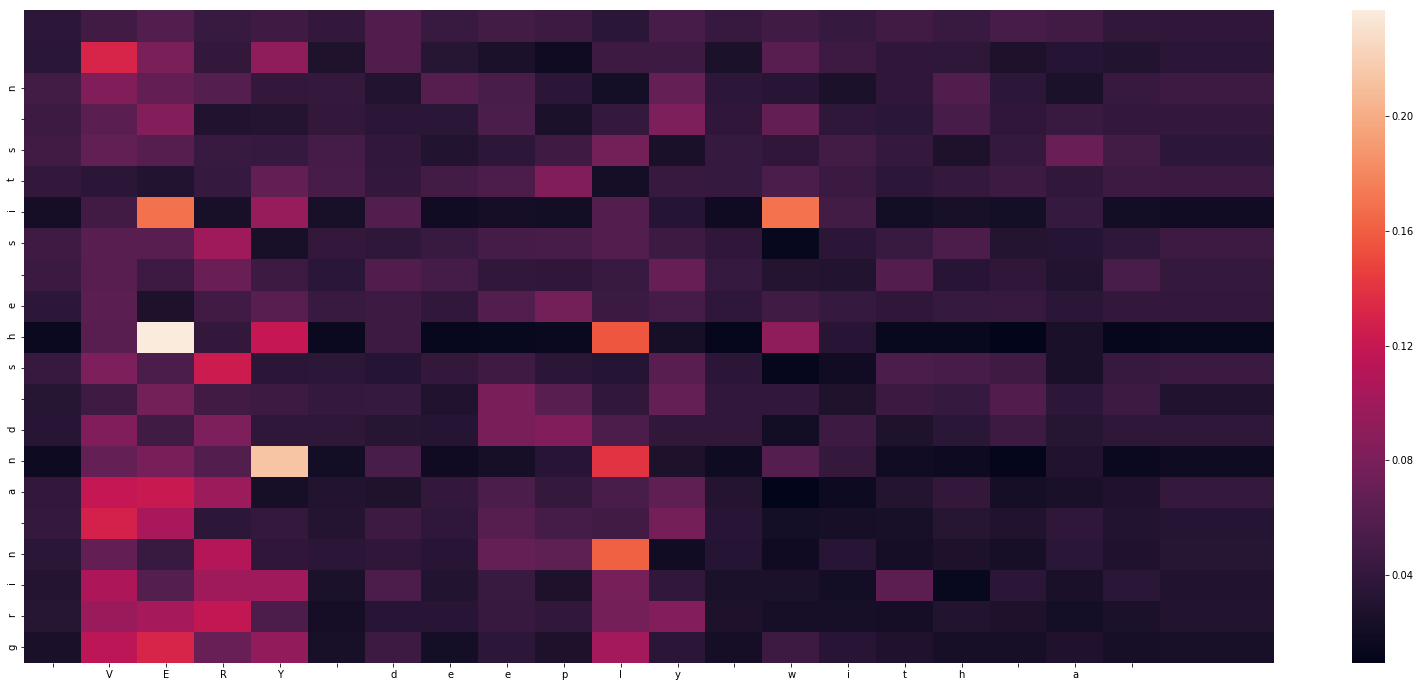

-
Input sentence:  VERY deeply with a 
GT sentence: knife, it usually bl
Decoded sentence: grin and she sits n


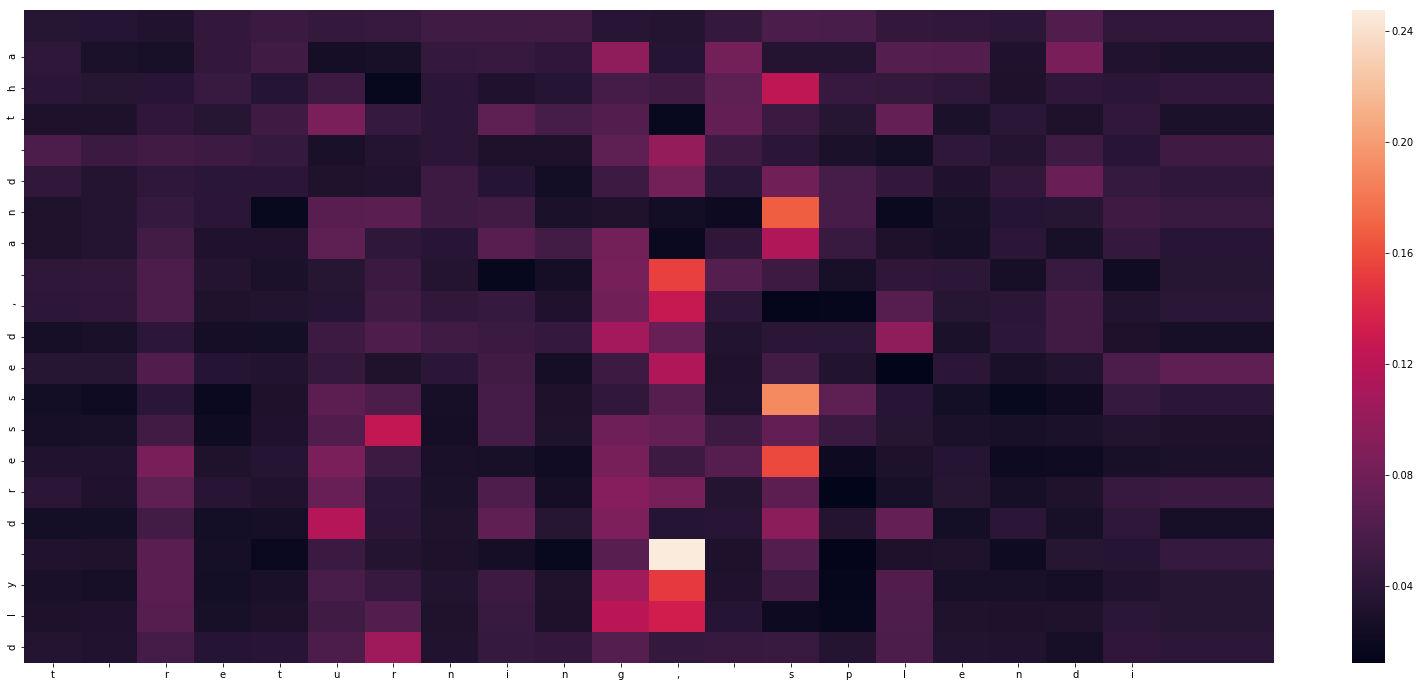

-
Input sentence: t returning, splendi
GT sentence: dly dressed, with a 
Decoded sentence: dly dressed, and tha


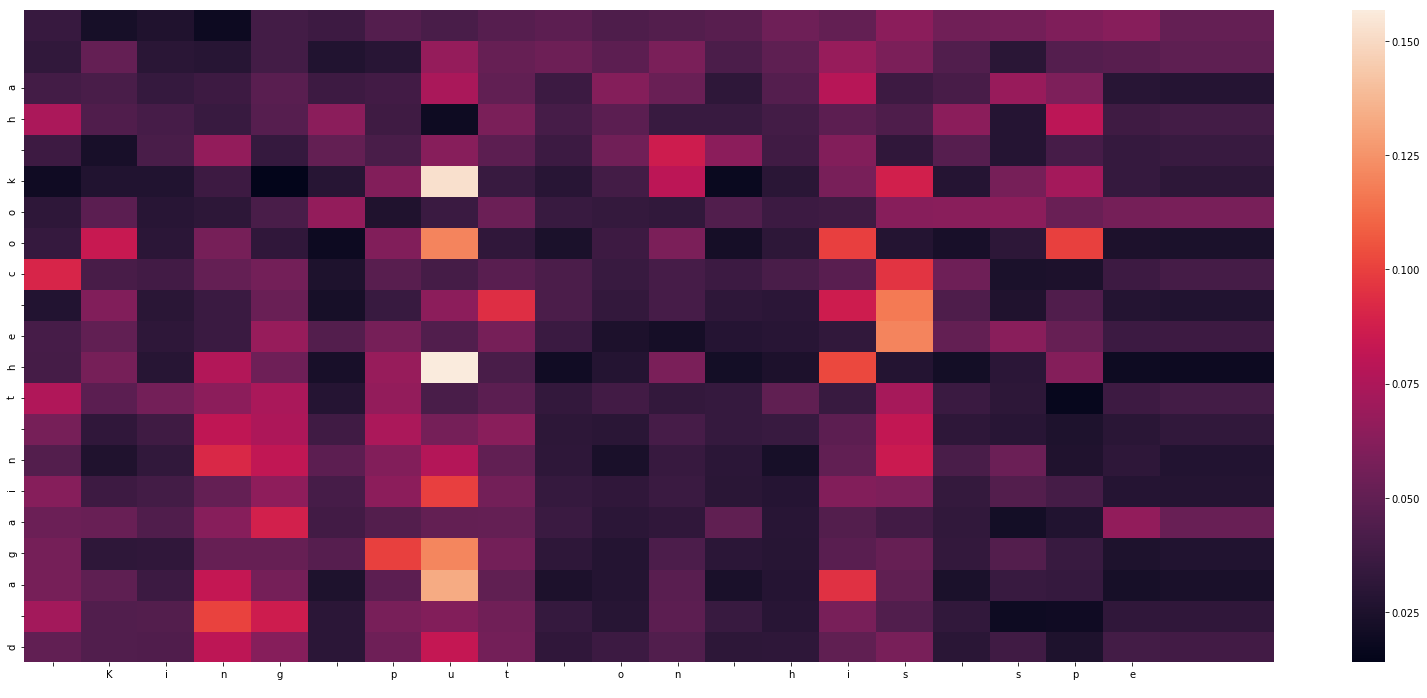

-
Input sentence: 
King put on his spe
GT sentence: ctacles and looked a
Decoded sentence: d again the cook ha


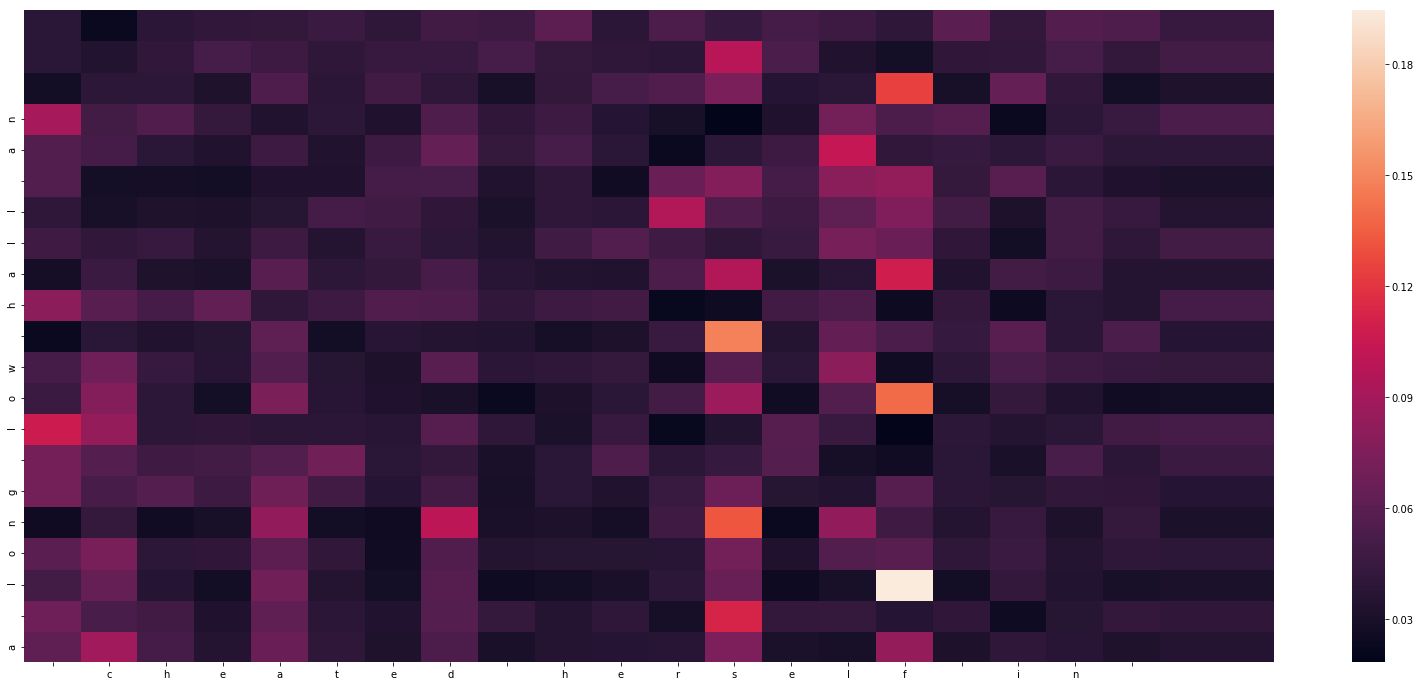

-
Input sentence: 
cheated herself in 
GT sentence: a game of croquet sh
Decoded sentence: a long low hall an


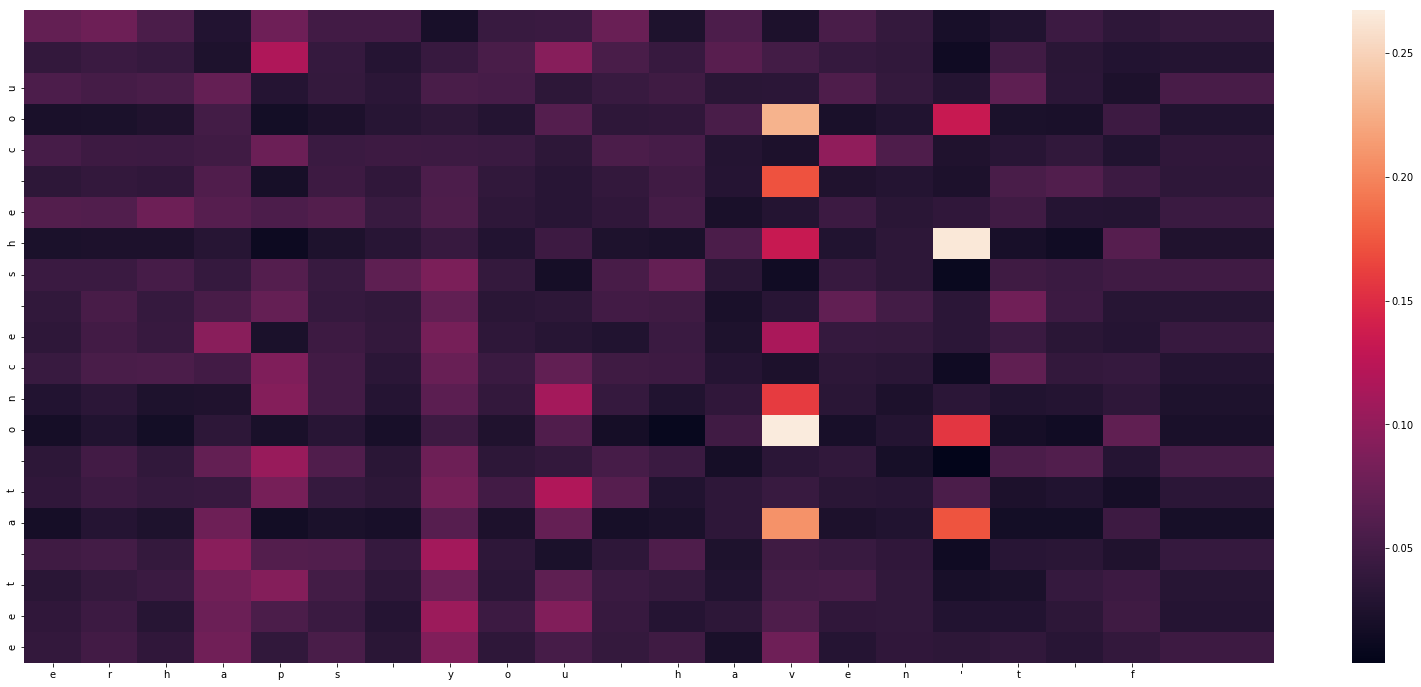

-
Input sentence: erhaps you haven't f
GT sentence: ound it so yet,' sai
Decoded sentence: eet at once she cou


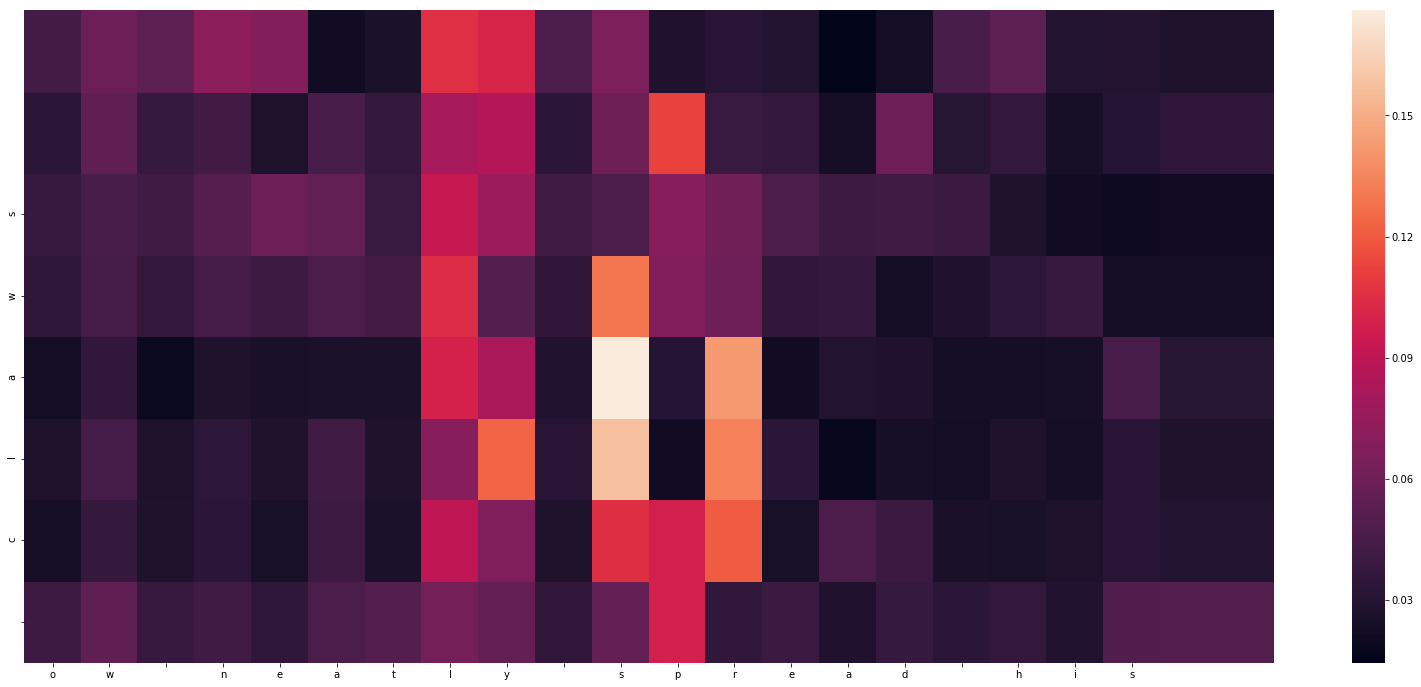

-
Input sentence: ow neatly spread his
GT sentence:  claws,
     And wel
Decoded sentence:  claws


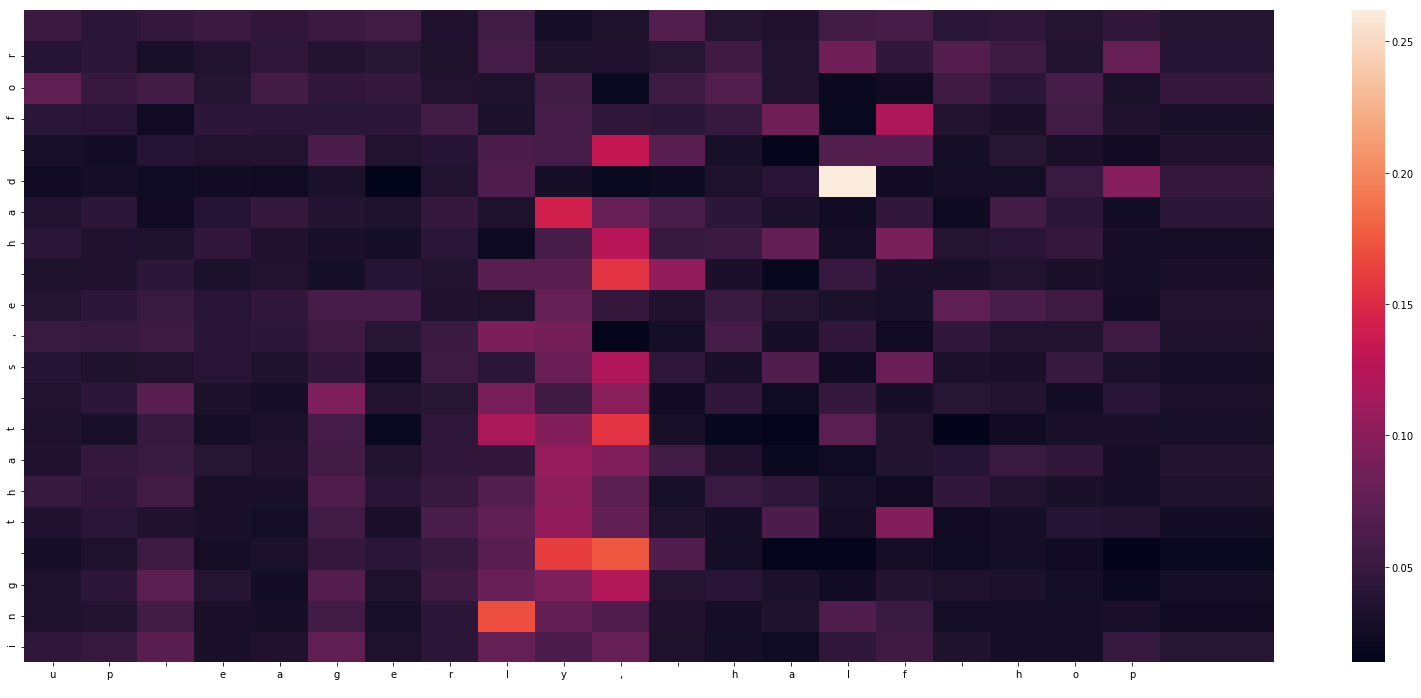

-
Input sentence: up
eagerly, half hop
GT sentence: ing that the Mouse h
Decoded sentence: ing that s,e had for


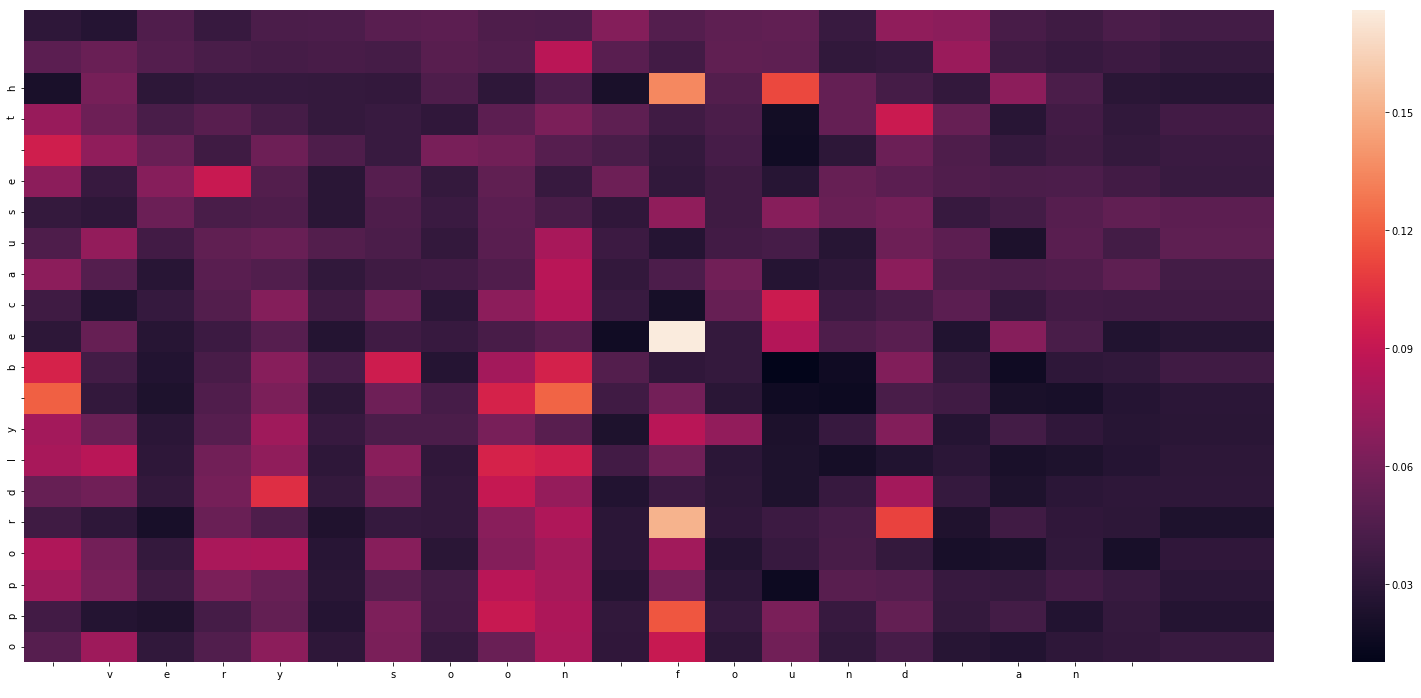

-
Input sentence: 
very soon found an 
GT sentence: opportunity of takin
Decoded sentence: oppordly because th


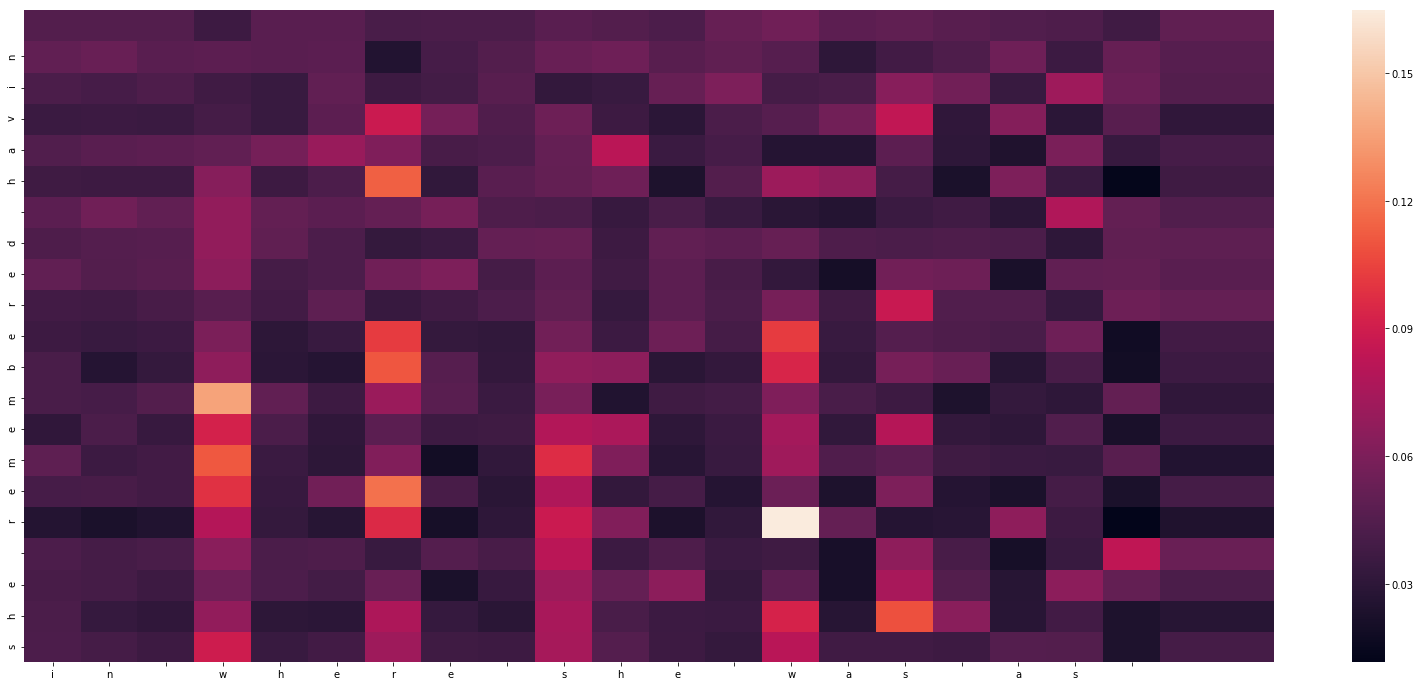

-
Input sentence: in where she was as

GT sentence: long as there was ro
Decoded sentence: she remembered havin


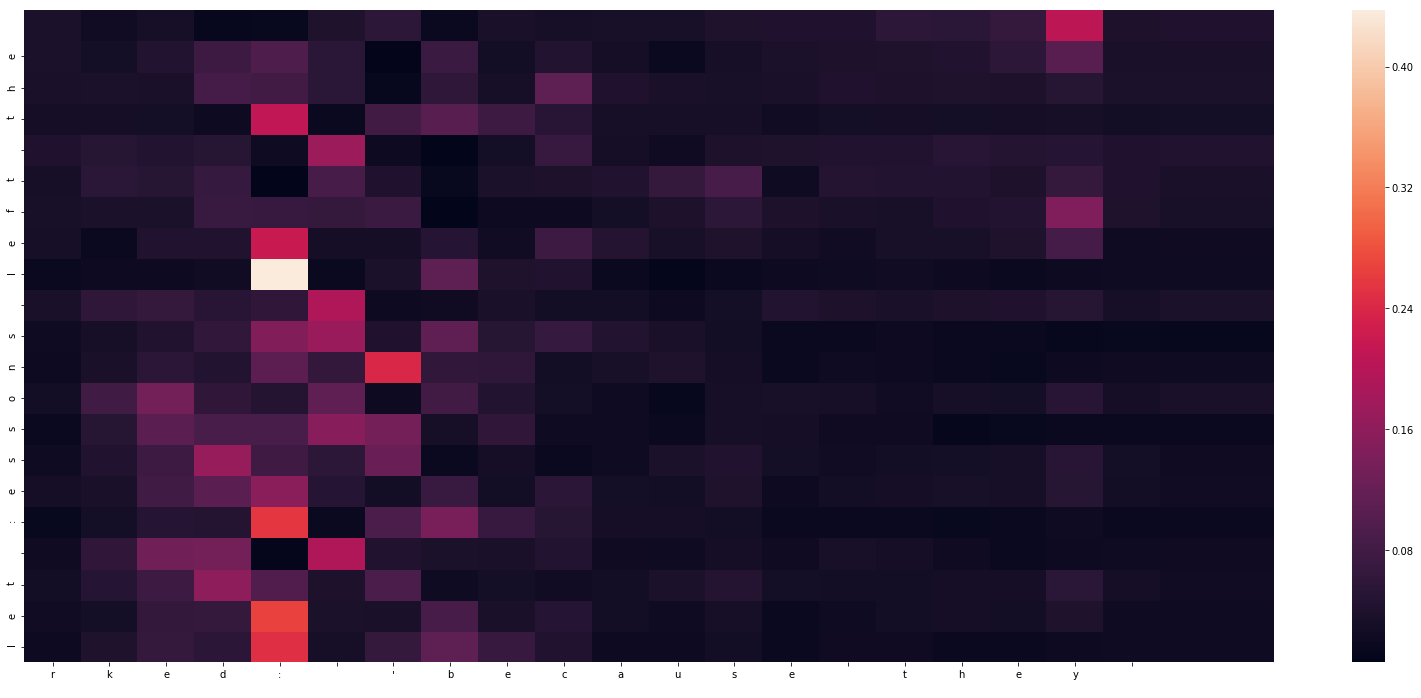

-
Input sentence: rked:
'because they 
GT sentence: lessen from day to d
Decoded sentence: let :essons left the


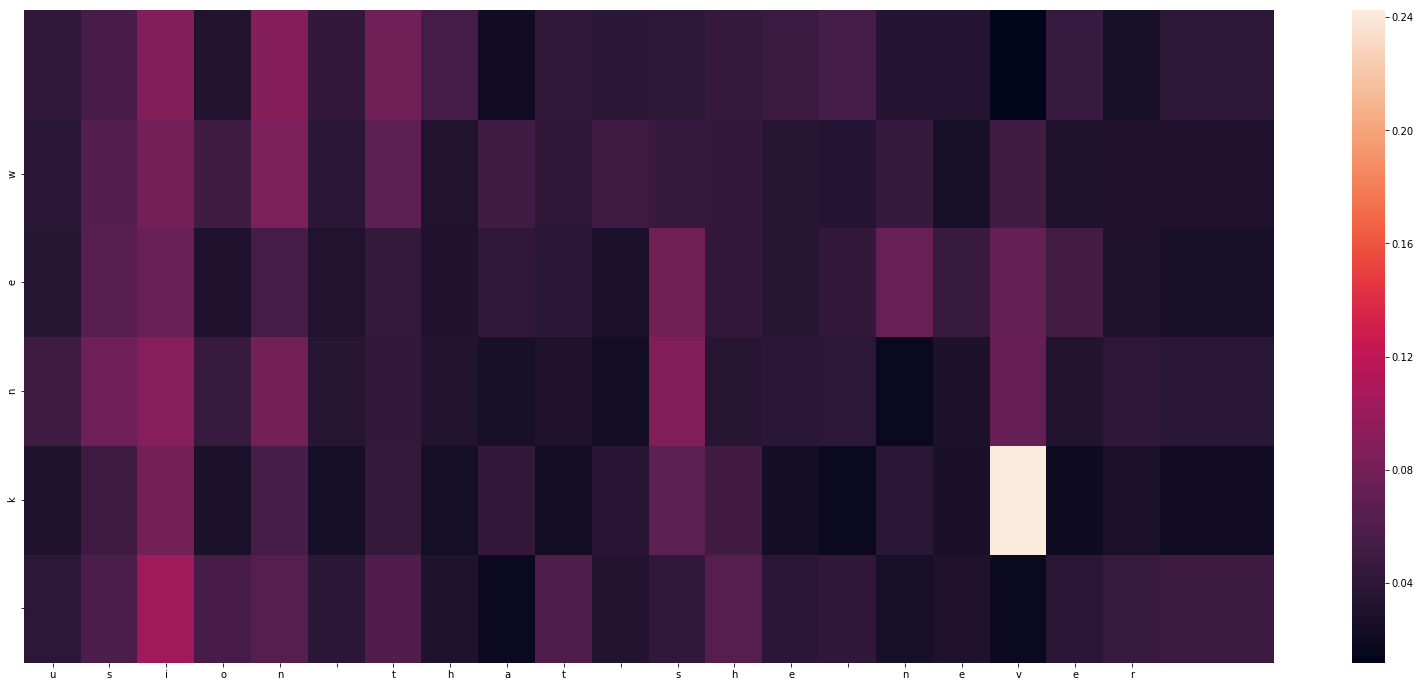

-
Input sentence: usion that she never
GT sentence:  knew
whether it was
Decoded sentence:  knew


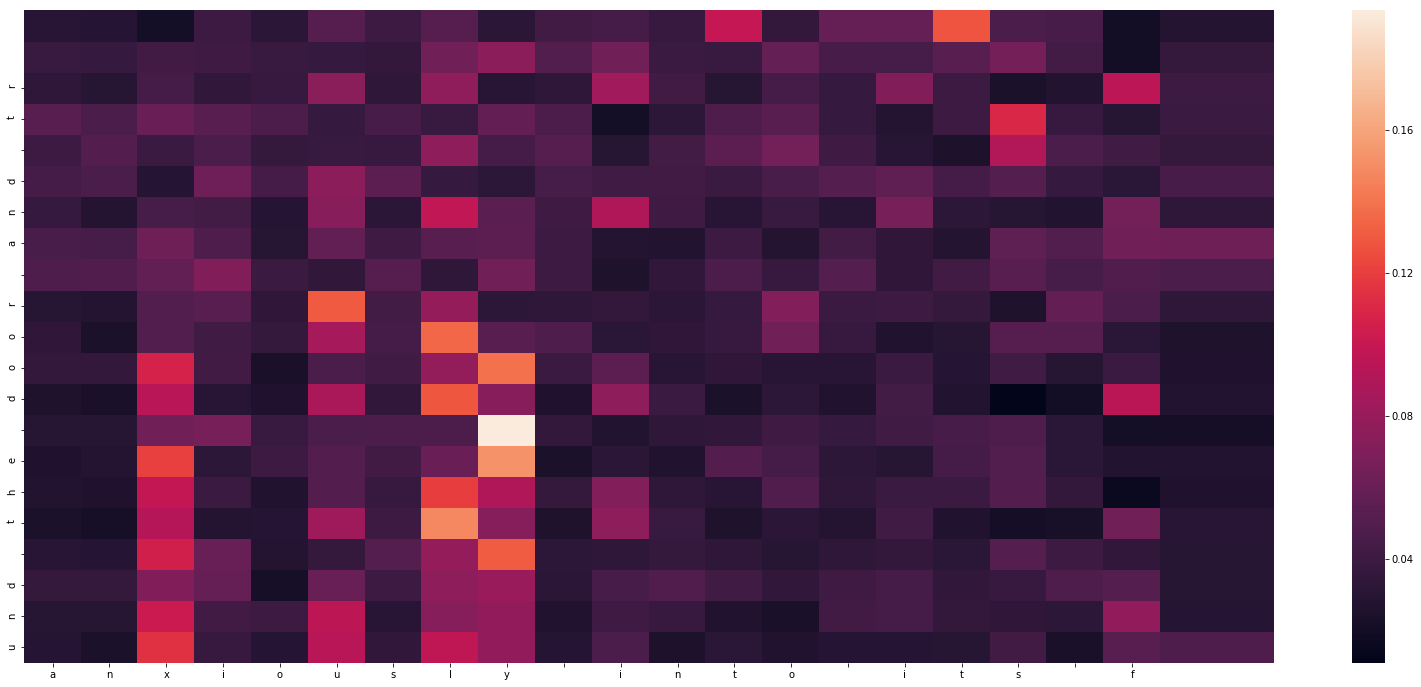

-
Input sentence: anxiously into its f
GT sentence: ace to
see what was 
Decoded sentence: und the door and tr


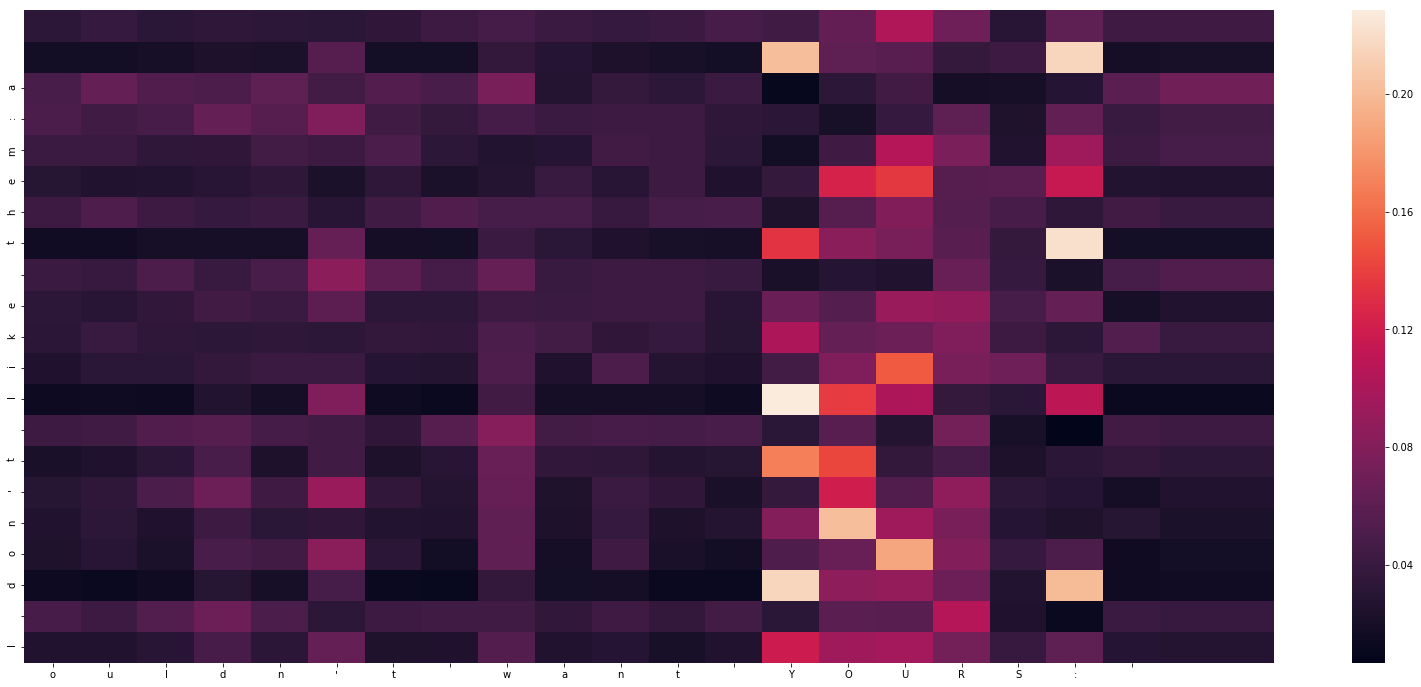

-
Input sentence: ouldn't want YOURS: 
GT sentence: I don't
like them ra
Decoded sentence: I don't like them:a


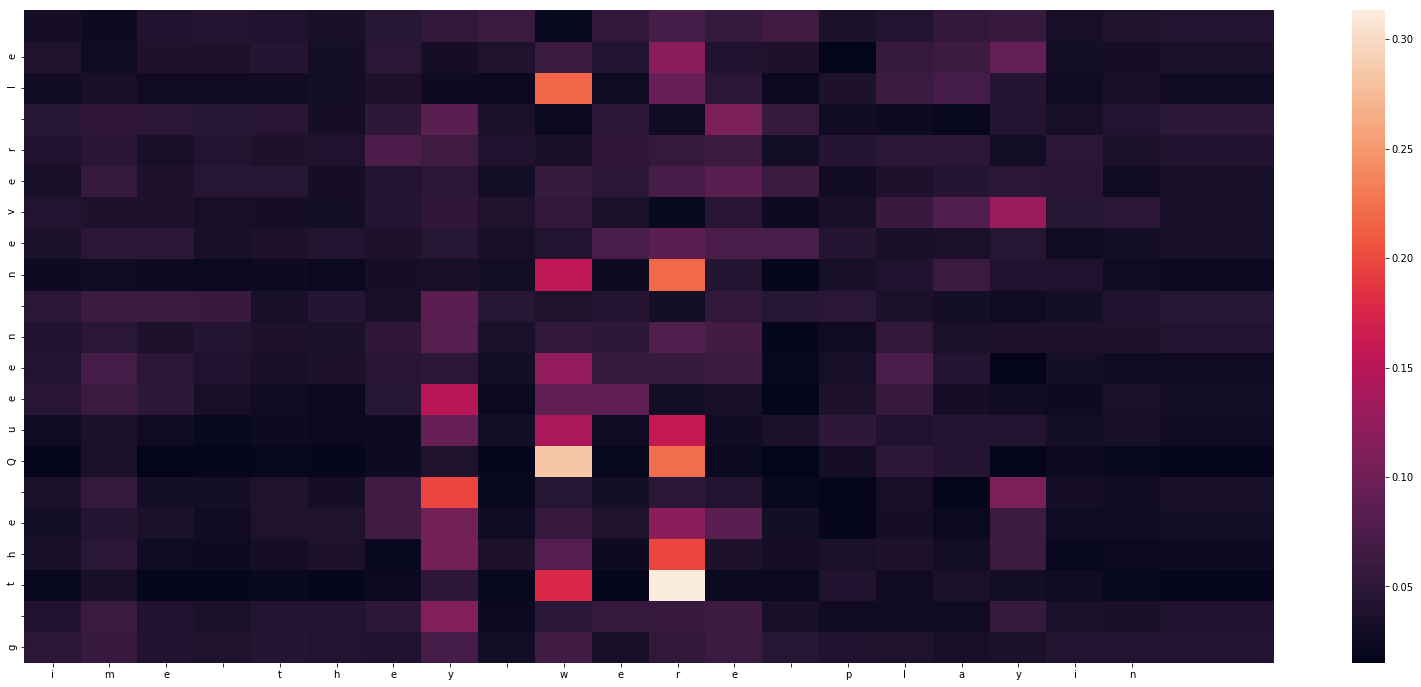

-
Input sentence: ime they were playin
GT sentence: g the Queen never le
Decoded sentence: g the Queen never le


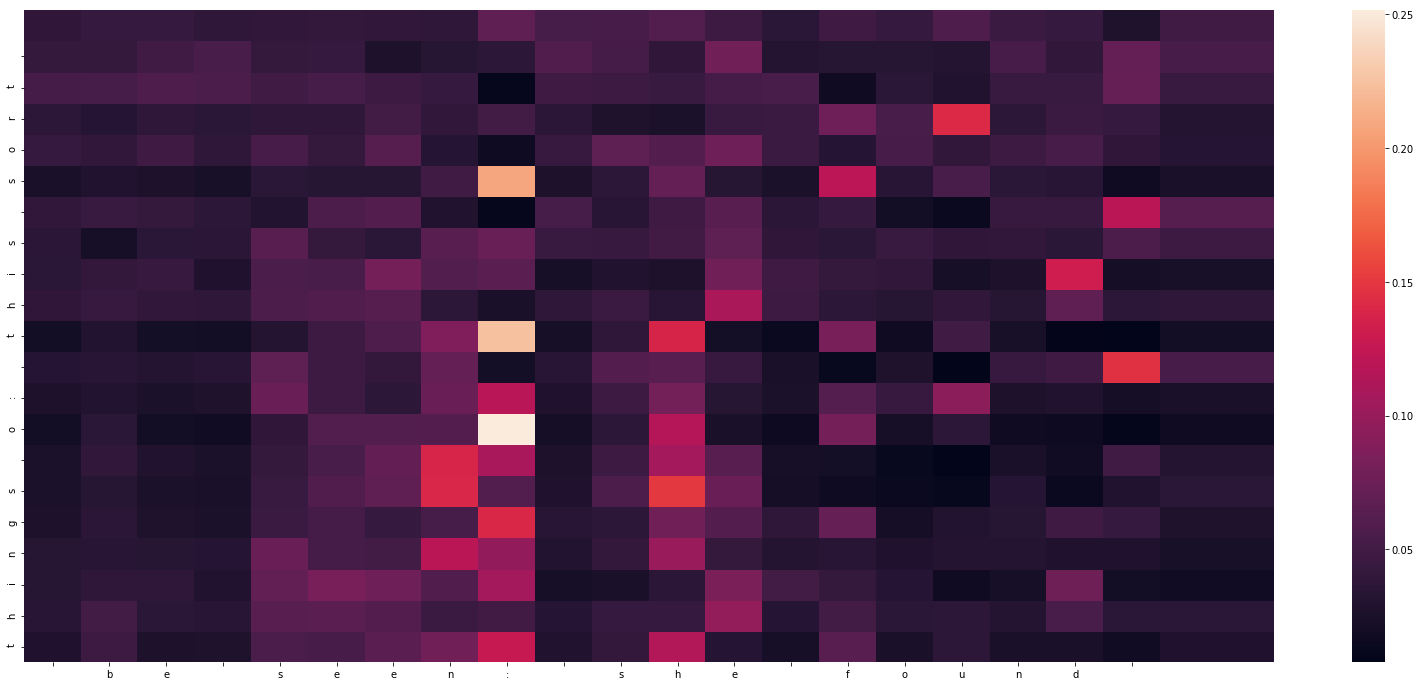

-
Input sentence:  be seen: she found

GT sentence: herself in a long, l
Decoded sentence: things o: this sort 


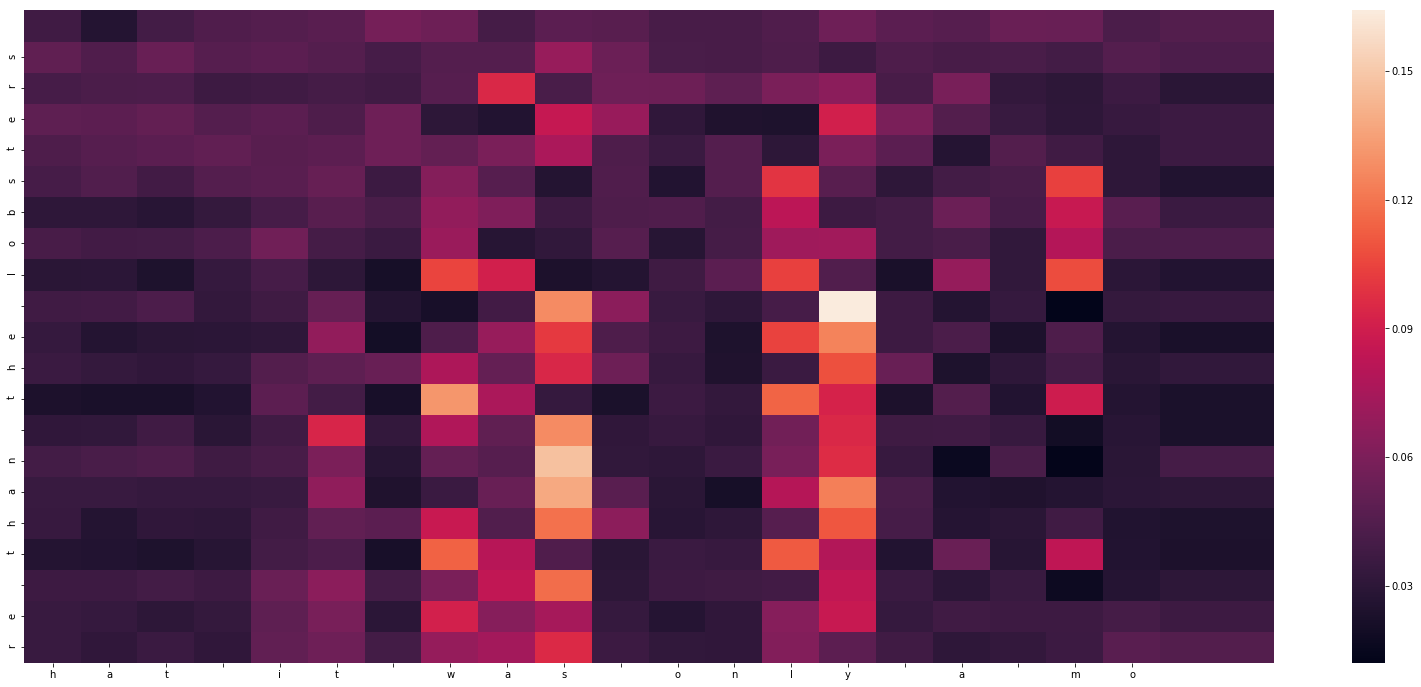

-
Input sentence: hat it was only a mo
GT sentence: use that had
slipped
Decoded sentence: re than the lobsters


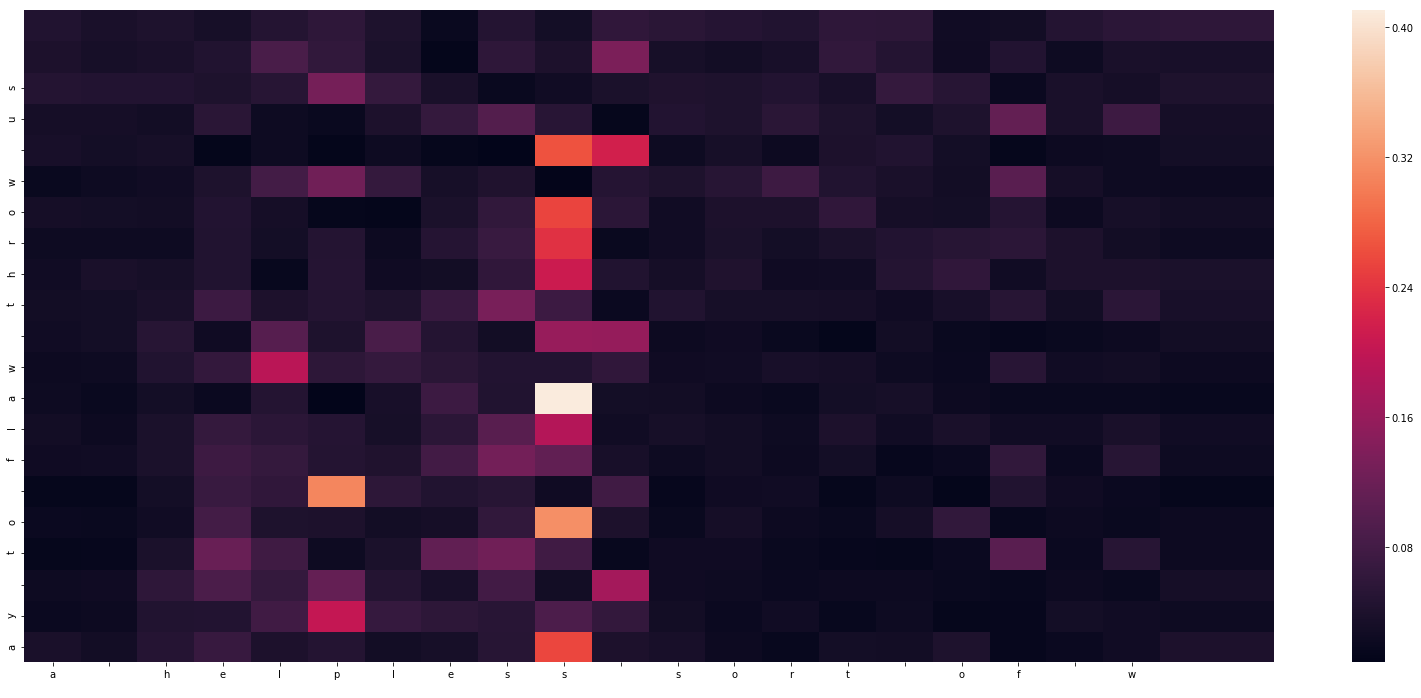

-
Input sentence: a helpless
sort of w
GT sentence: ay to fly up into a 
Decoded sentence: ay to flaw throw us


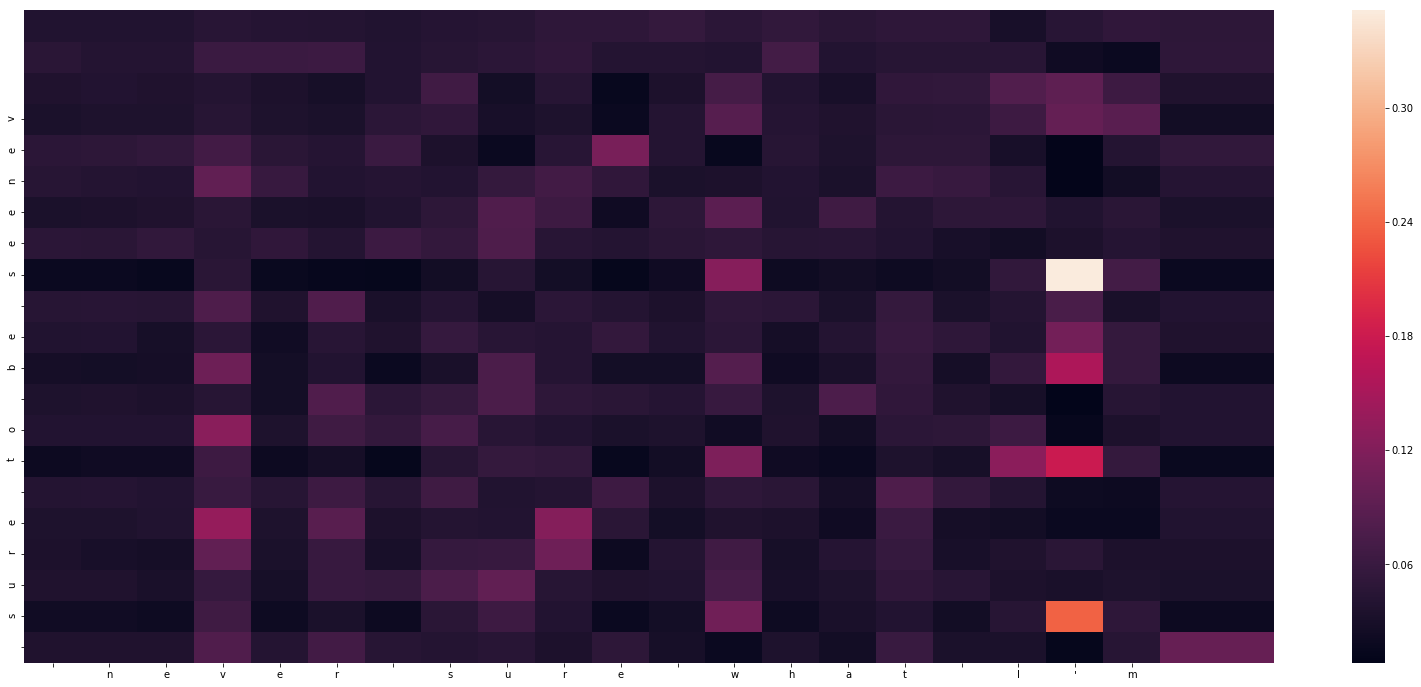

-
Input sentence:  never sure what I'm
GT sentence:  going
to be, from o
Decoded sentence:  sure to be seenev


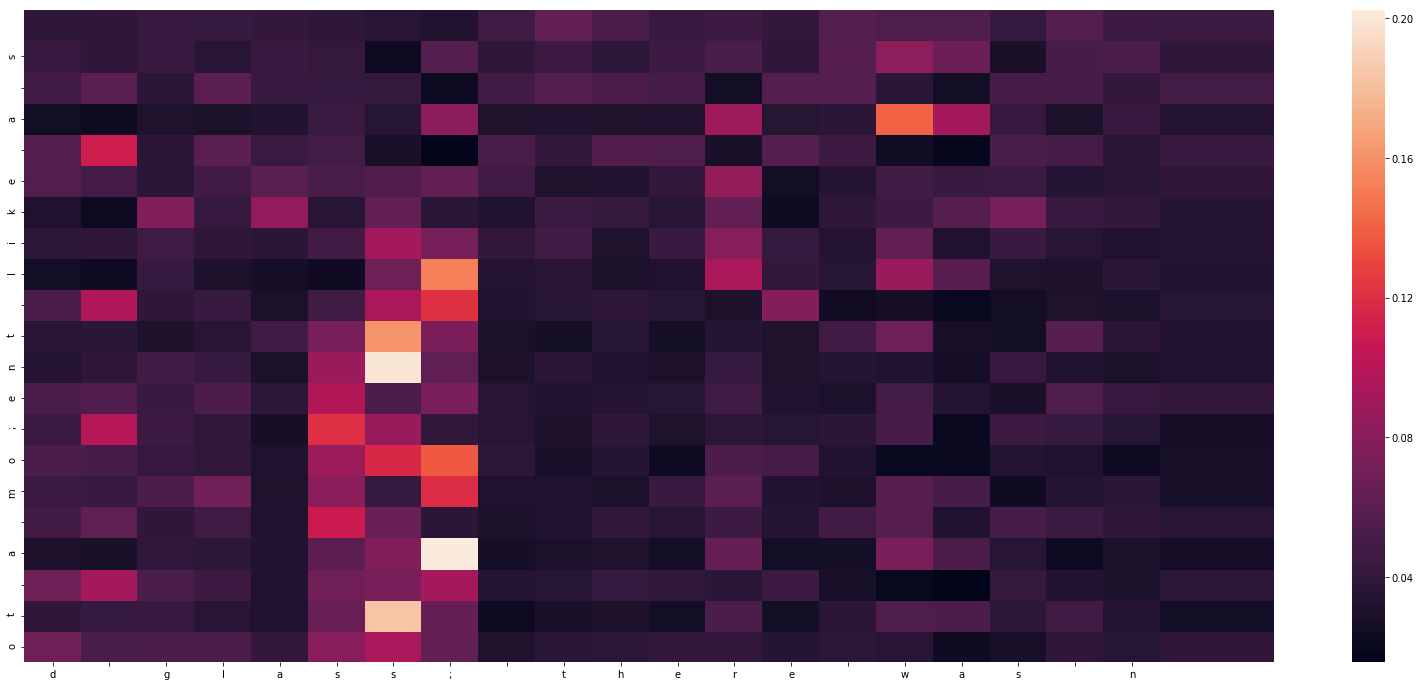

-
Input sentence: d
glass; there was n
GT sentence: othing on it except 
Decoded sentence: ot a mo;ent like a s


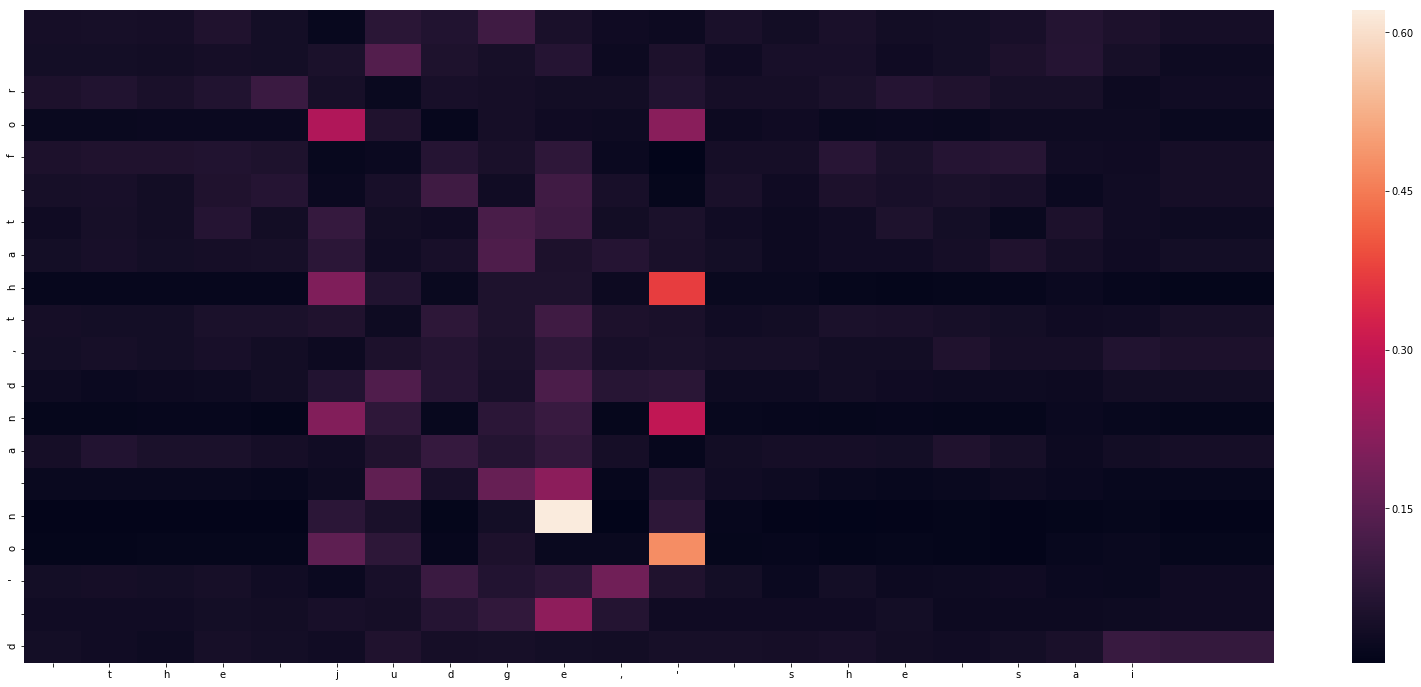

-
Input sentence:  the judge,' she sai
GT sentence: d to
herself, 'becau
Decoded sentence: d 'on and,that for


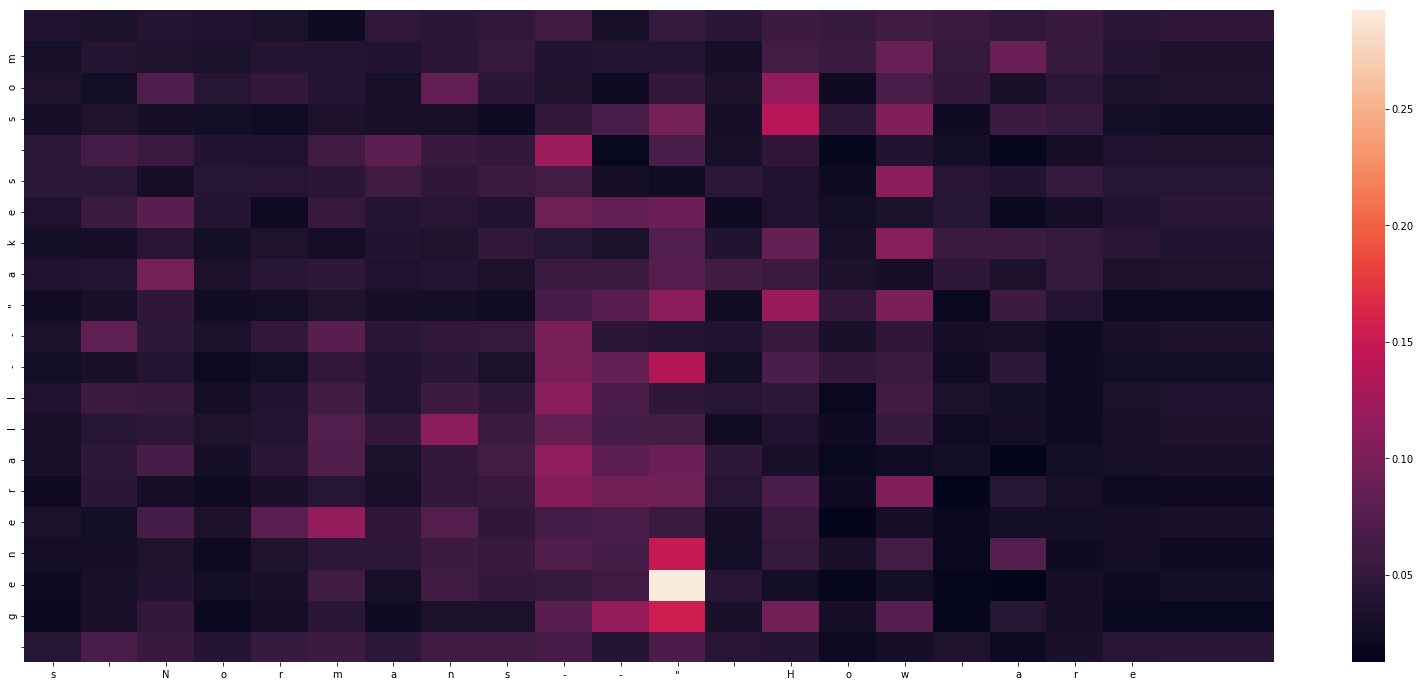

-
Input sentence: s
Normans--" How are
GT sentence:  you getting on now,
Decoded sentence:  generall--"akes som


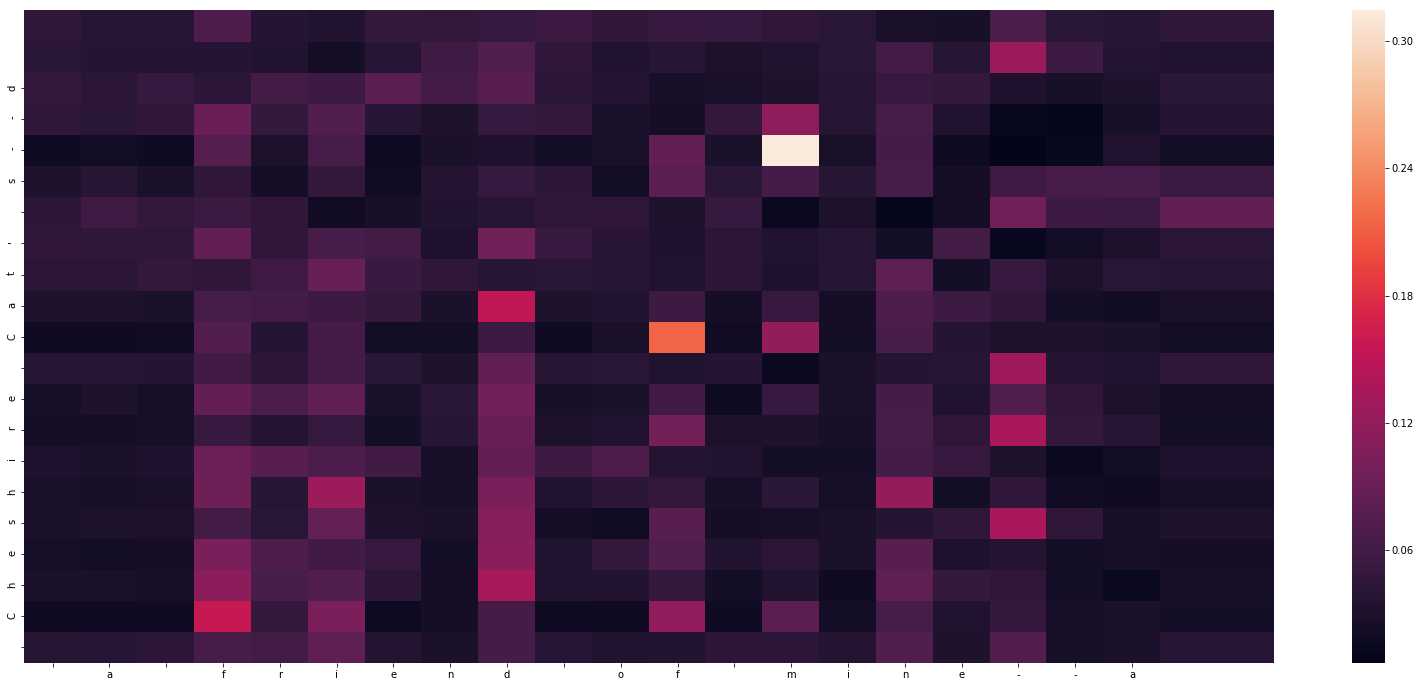

-
Input sentence:  a friend of mine--a
GT sentence:  Cheshire Cat,' said
Decoded sentence:  Cheshire Cat' s--d


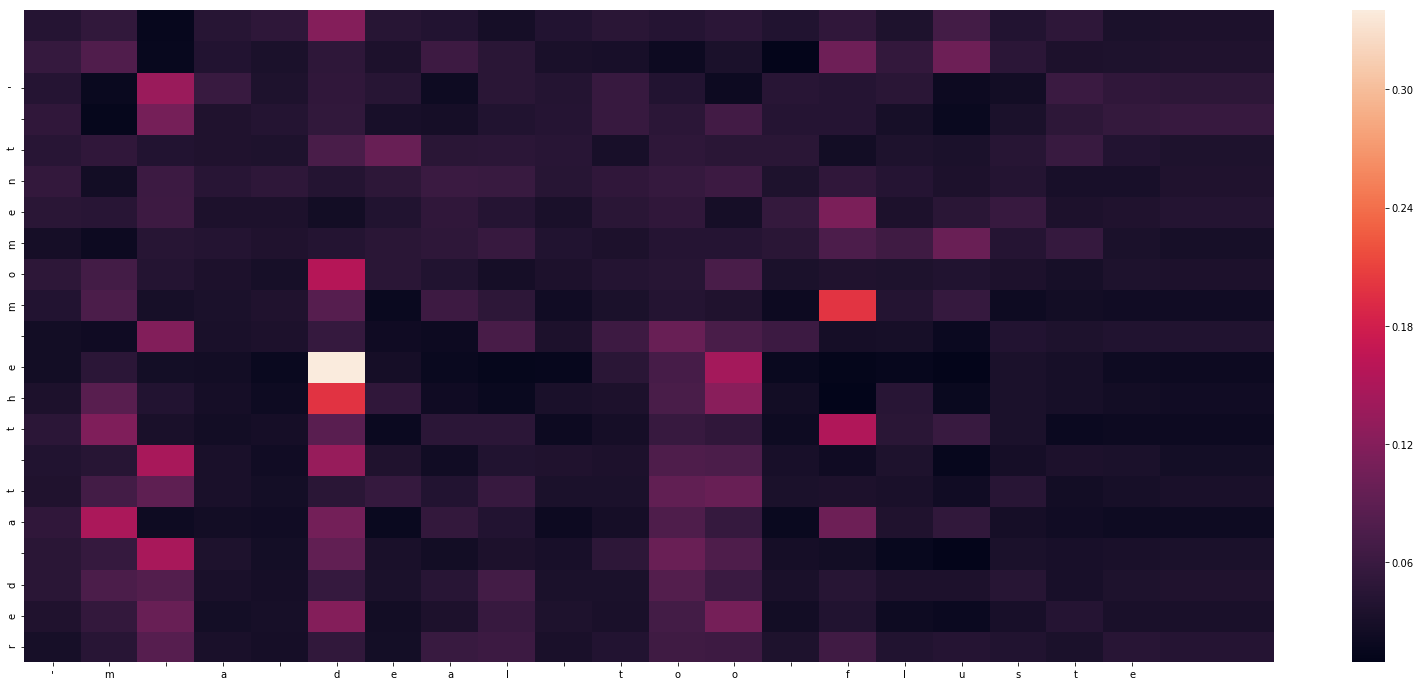

-
Input sentence: 'm
a deal too fluste
GT sentence: red to tell you--all
Decoded sentence: red at the moment '


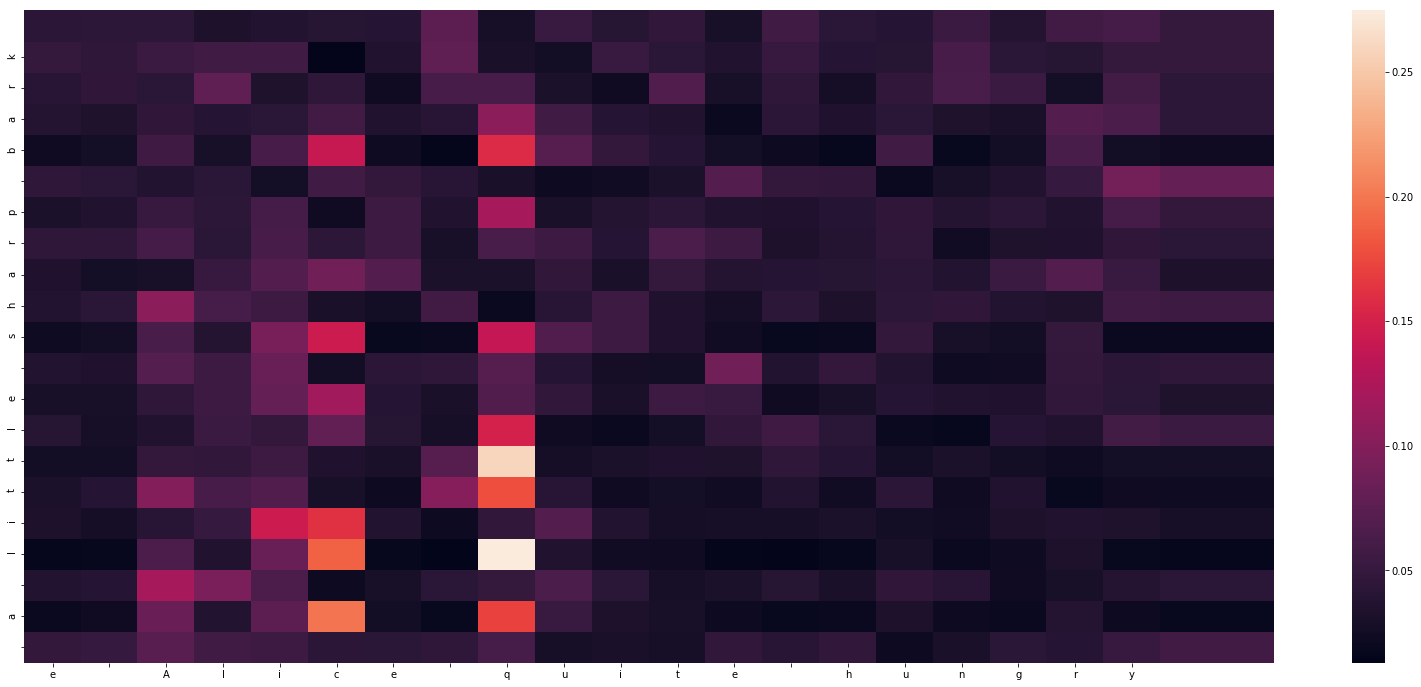

-
Input sentence: e Alice quite hungry
GT sentence:  to look at them--'I
Decoded sentence:  a little sharp bark


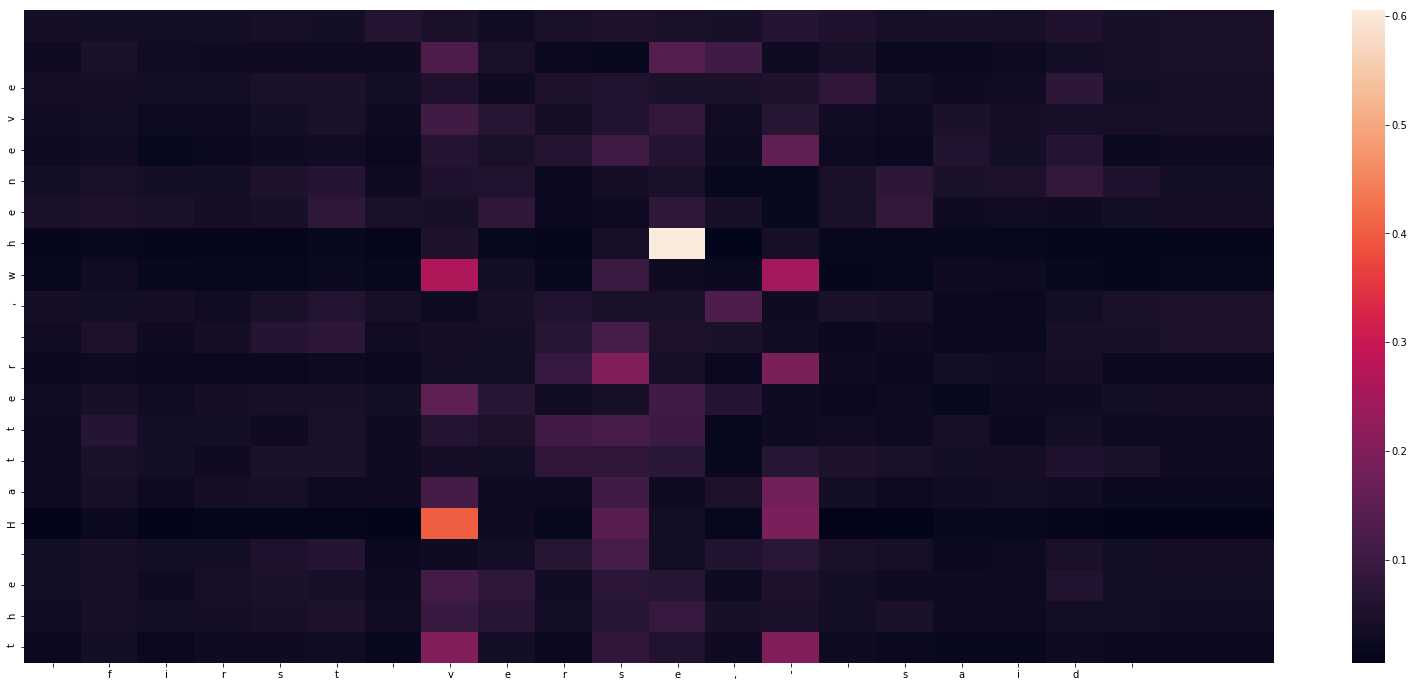

-
Input sentence:  first verse,' said 
GT sentence: the Hatter, 'when th
Decoded sentence: the Hatter ,wheneve


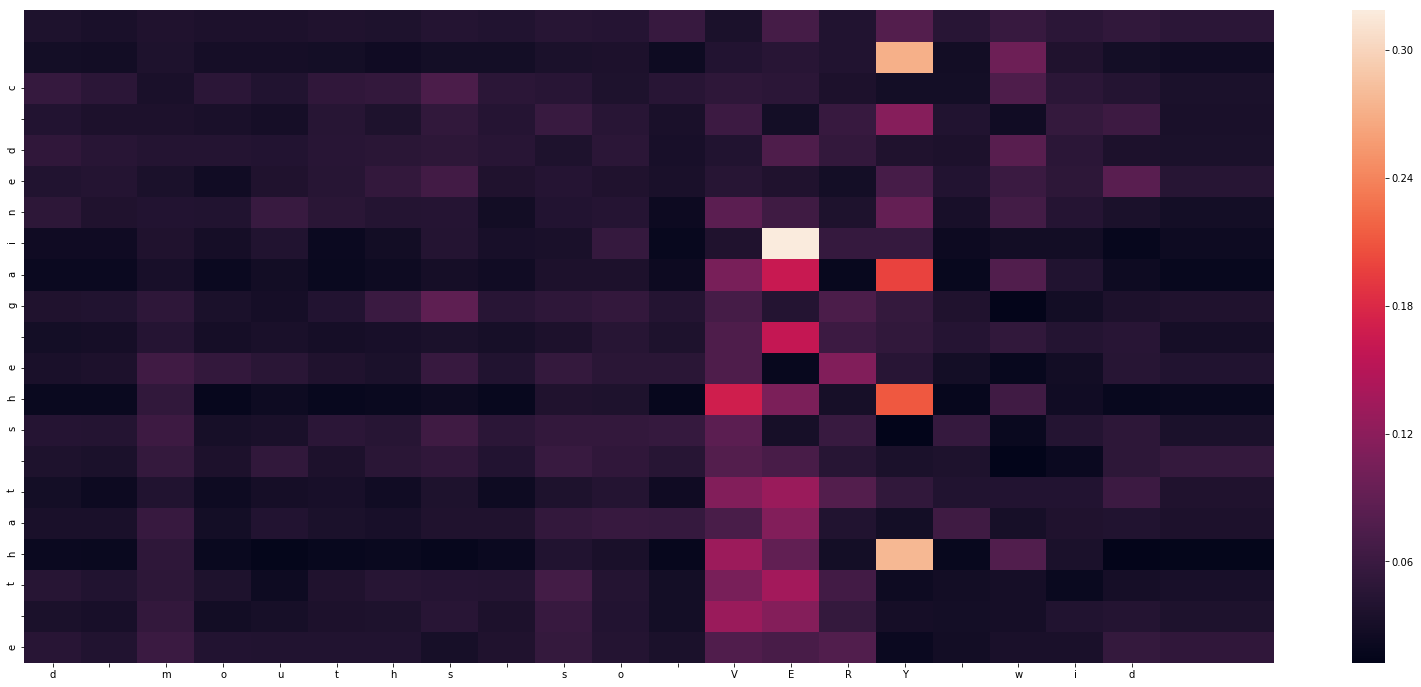

-
Input sentence: d mouths so VERY wid
GT sentence: e, but she gained co
Decoded sentence: e that she gained c


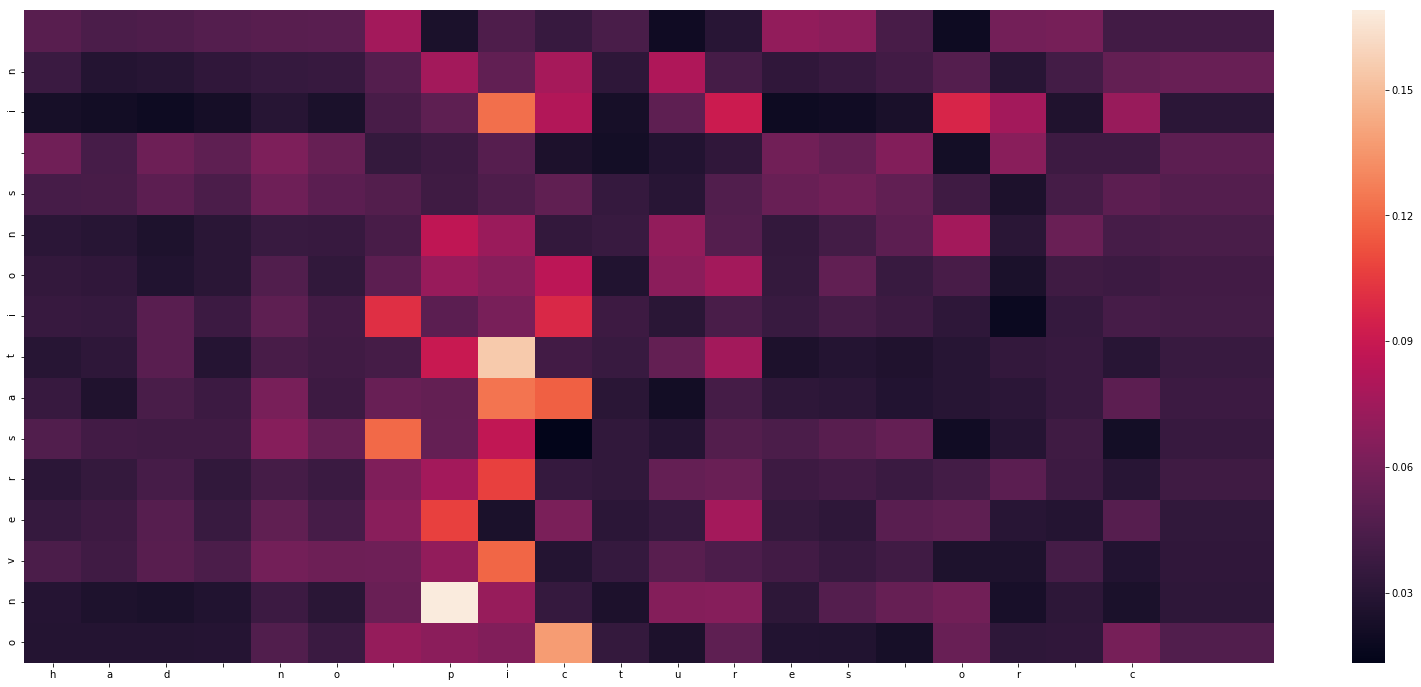

-
Input sentence: had no pictures or c
GT sentence: onversations in
it, 
Decoded sentence: onversations in


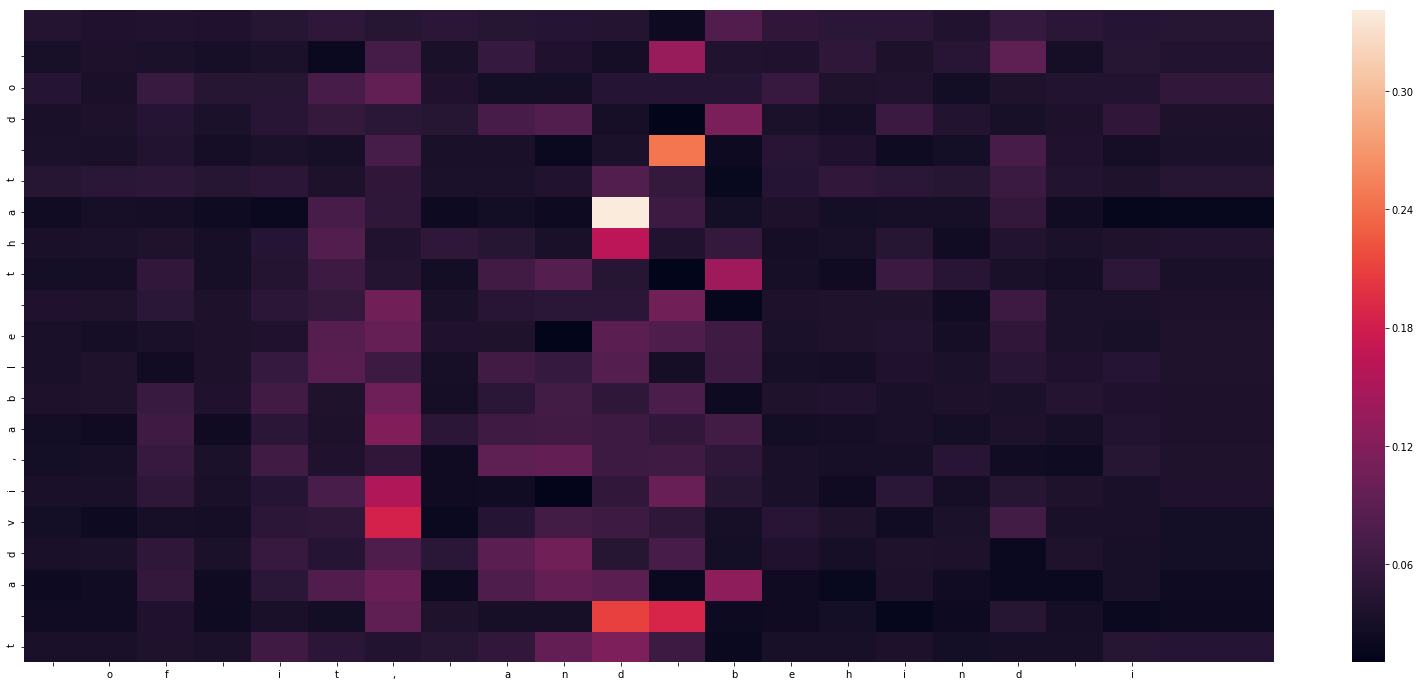

-
Input sentence:  of it, and
behind i
GT sentence: t, it occurred to he
Decoded sentence: t advi,able that do 


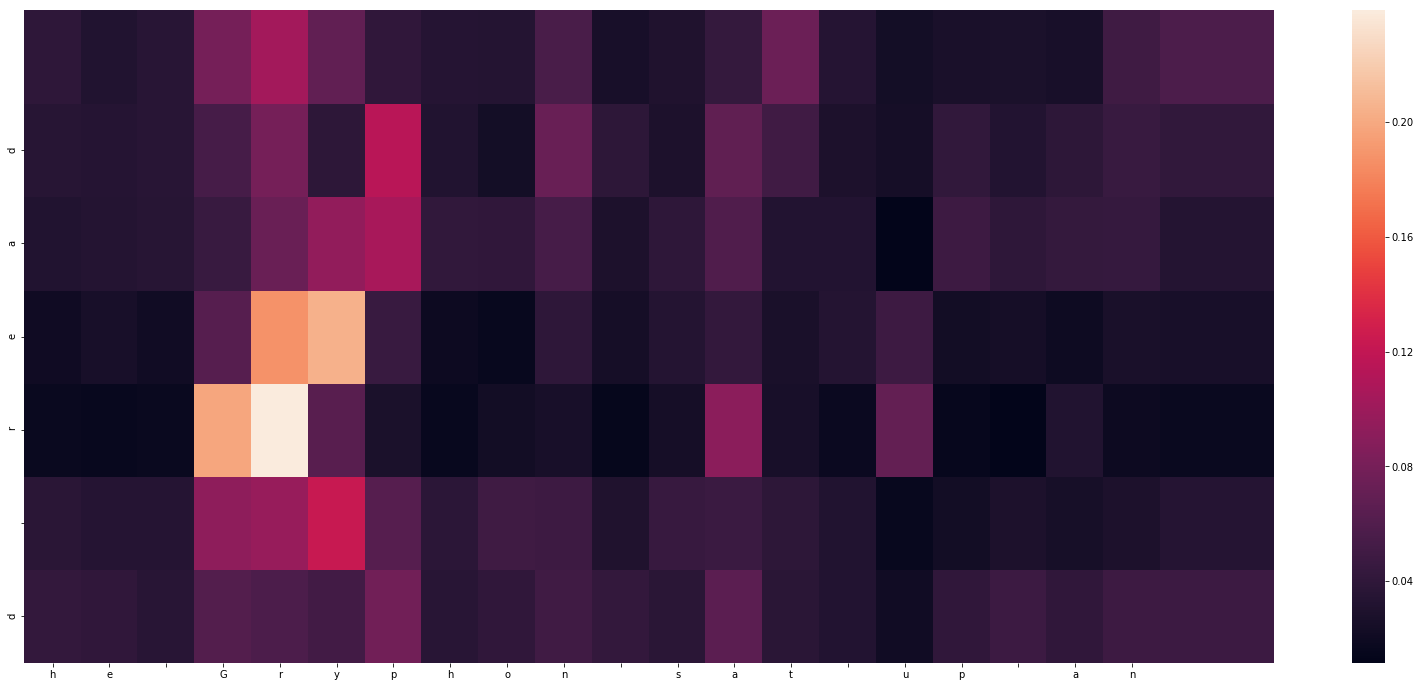

-
Input sentence: he Gryphon sat up an
GT sentence: d rubbed its eyes: t
Decoded sentence: d read


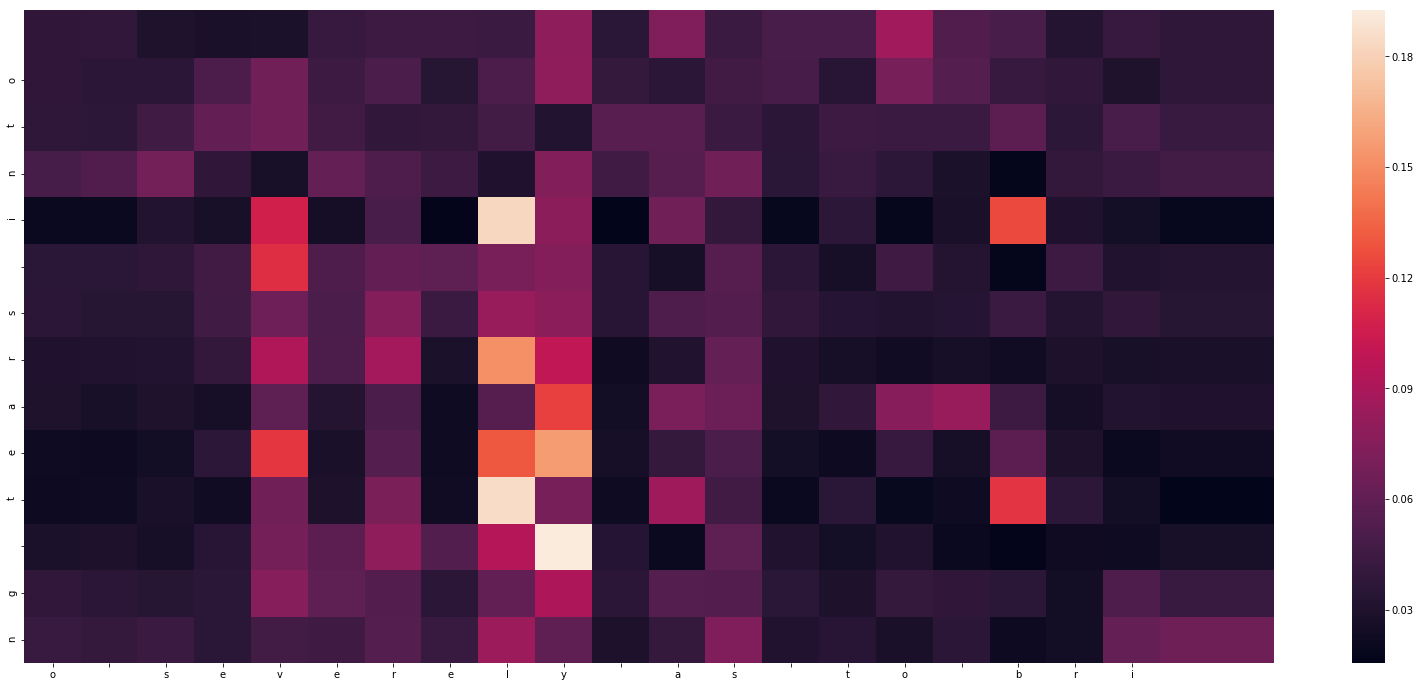

-
Input sentence: o severely as to bri
GT sentence: ng tears into
her ey
Decoded sentence: ng tears into


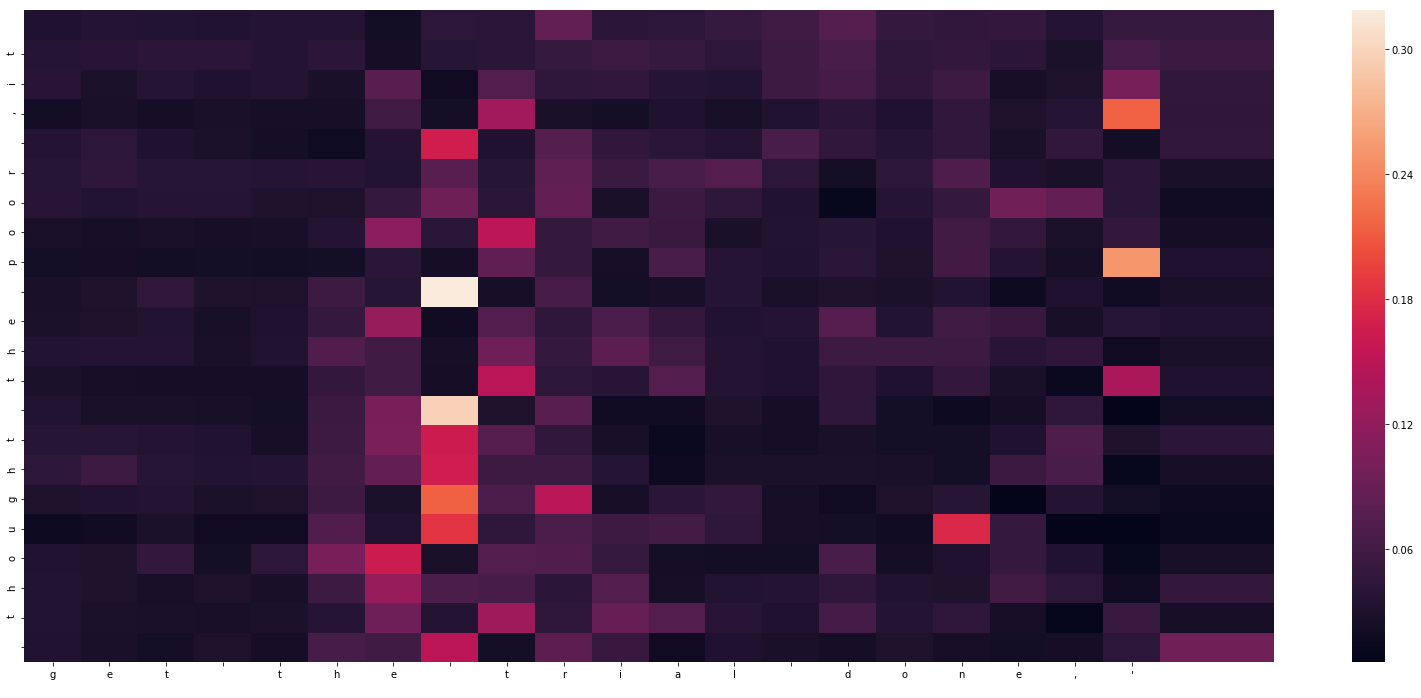

-
Input sentence: get the
trial done,'
GT sentence:  she thought, 'and h
Decoded sentence:  thought the poor ,it


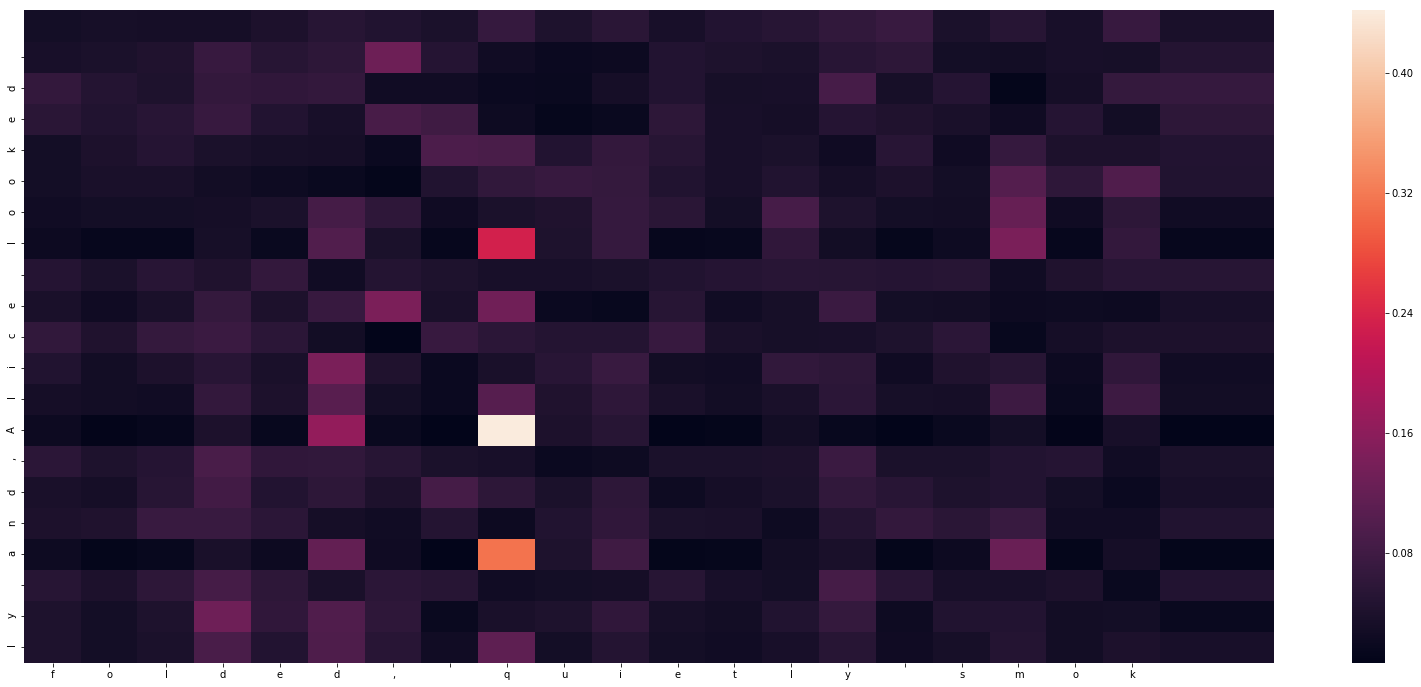

-
Input sentence: folded, quietly smok
GT sentence: ing a long
hookah, a
Decoded sentence: ly and,Alice looked 


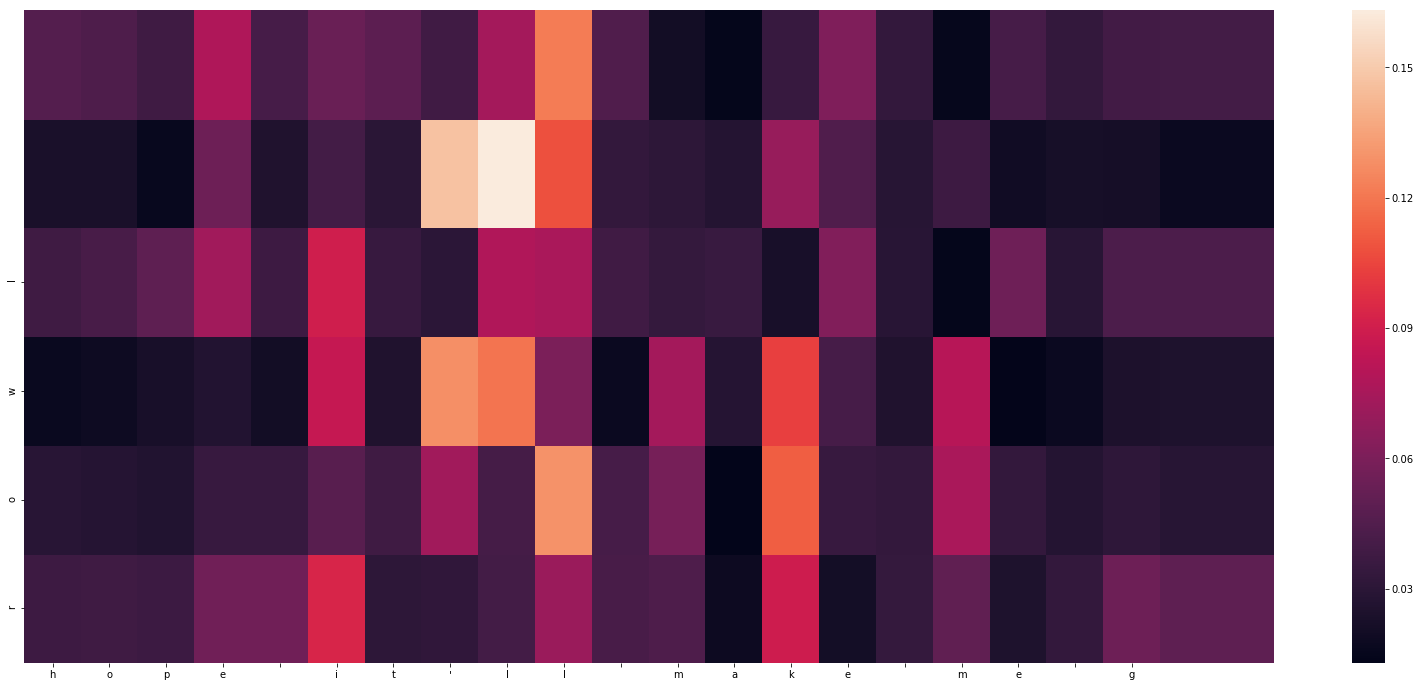

-
Input sentence: hope it'll make me g
GT sentence: row large again, for
Decoded sentence: rowl


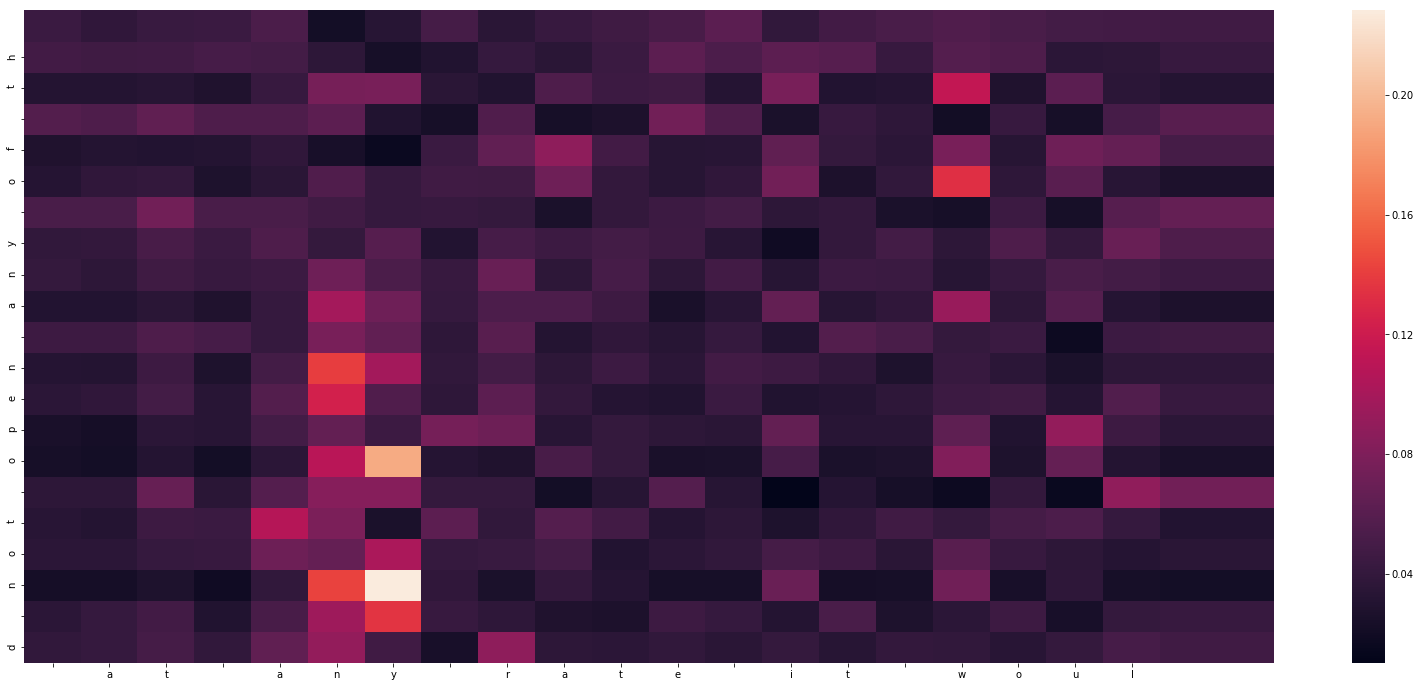

-
Input sentence:  at any rate it woul
GT sentence: d not open any of th
Decoded sentence: d not open any of th


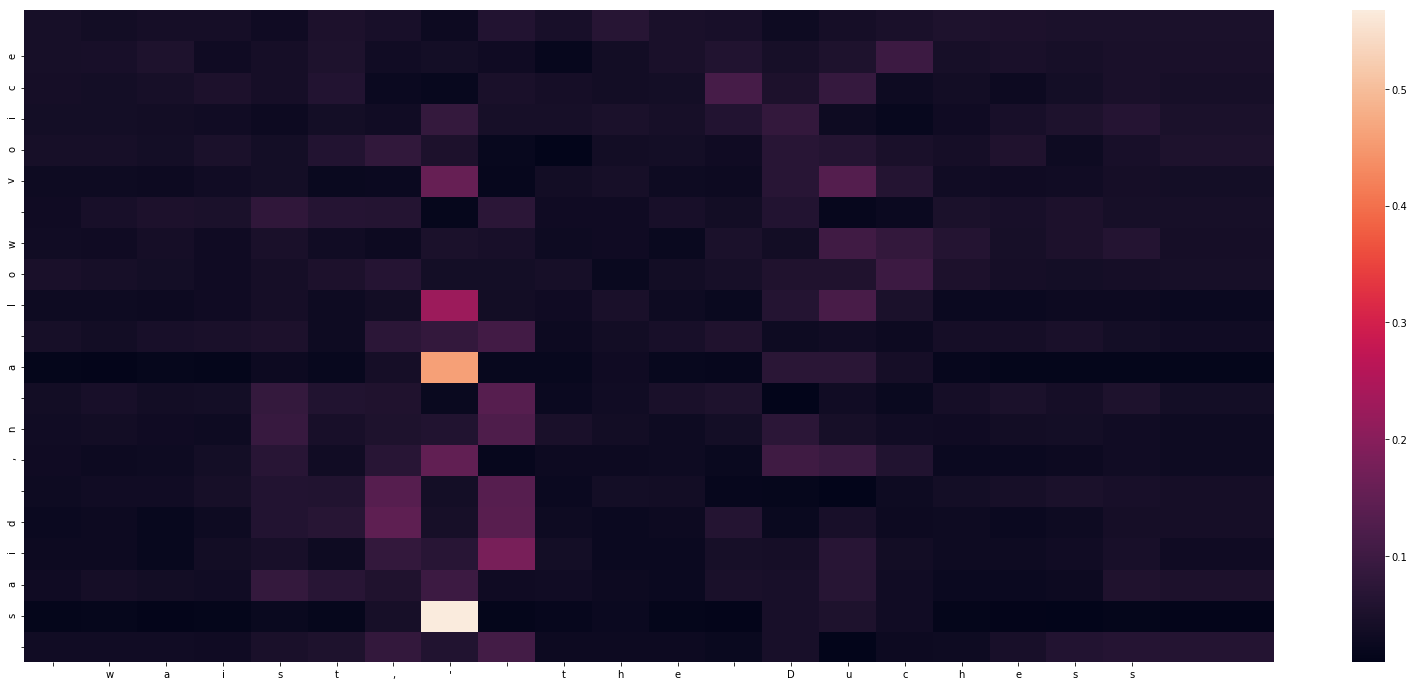

-
Input sentence:  waist,'
the Duchess
GT sentence:  said after a pause:
Decoded sentence:  said ,n a low voice


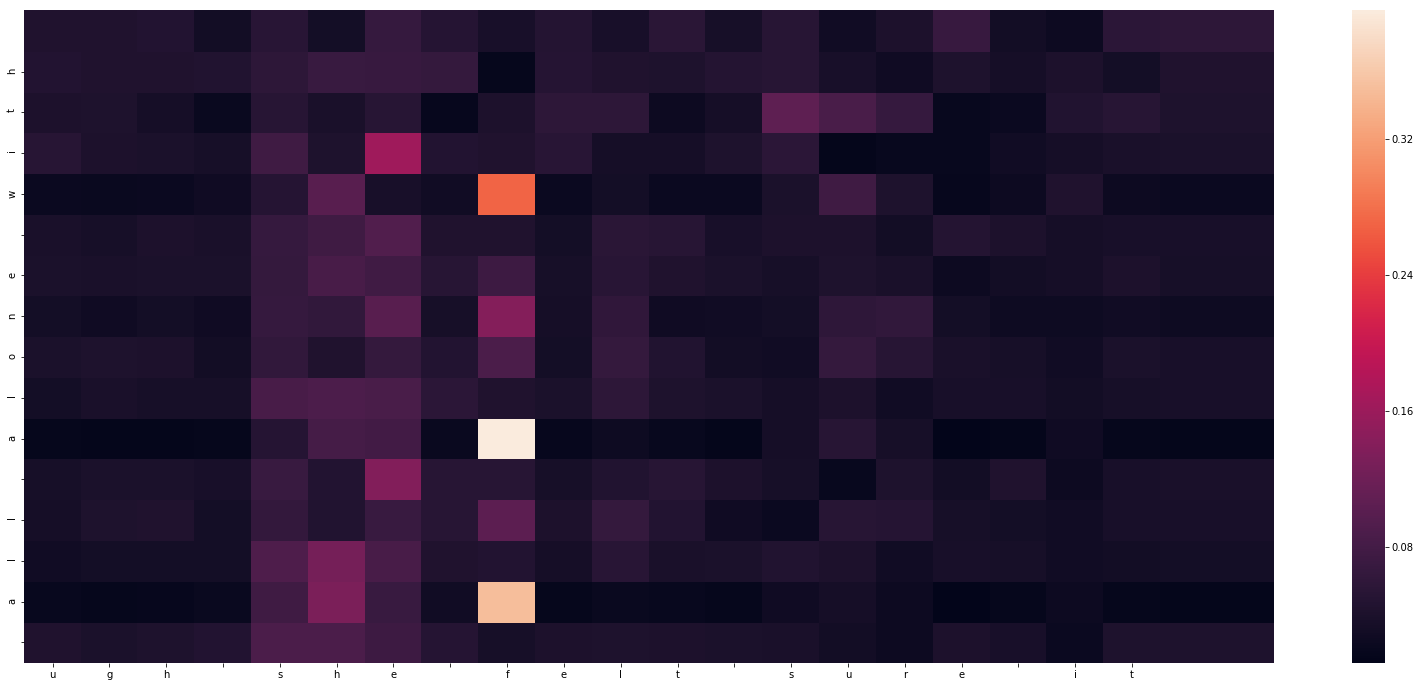

-
Input sentence: ugh she felt sure it
GT sentence:  would all come
wron
Decoded sentence:  all alone with


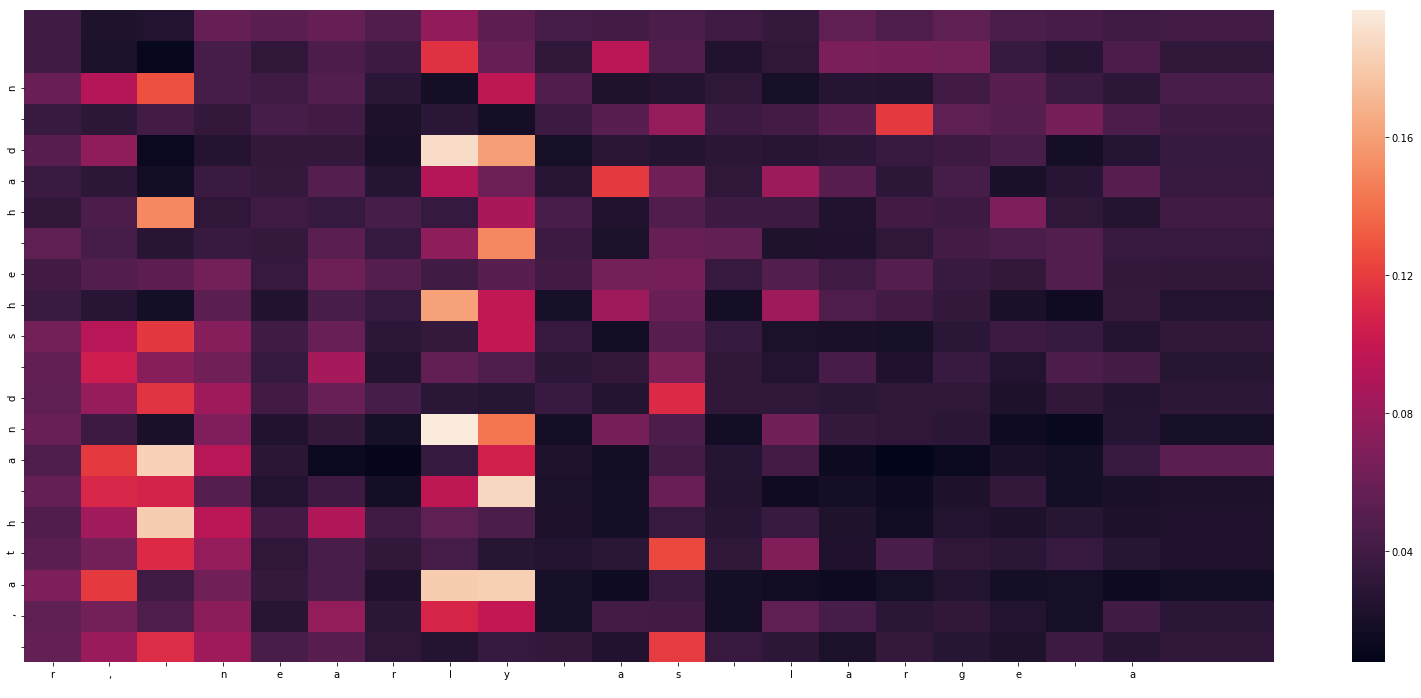

-
Input sentence: r,
nearly as large a
GT sentence: s himself, and this 
Decoded sentence:  ,ath and she had n


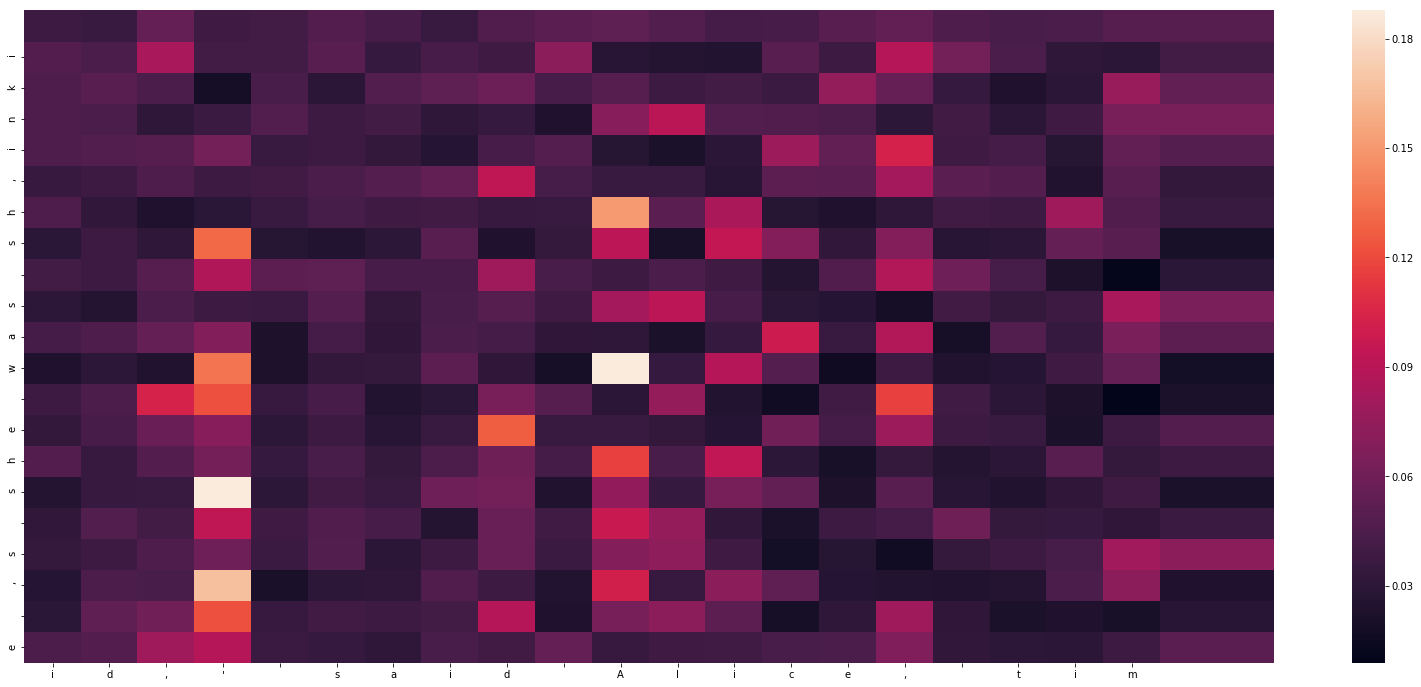

-
Input sentence: id,' said Alice, tim
GT sentence: idly; 'some of the w
Decoded sentence: e ,s she was sh,inki


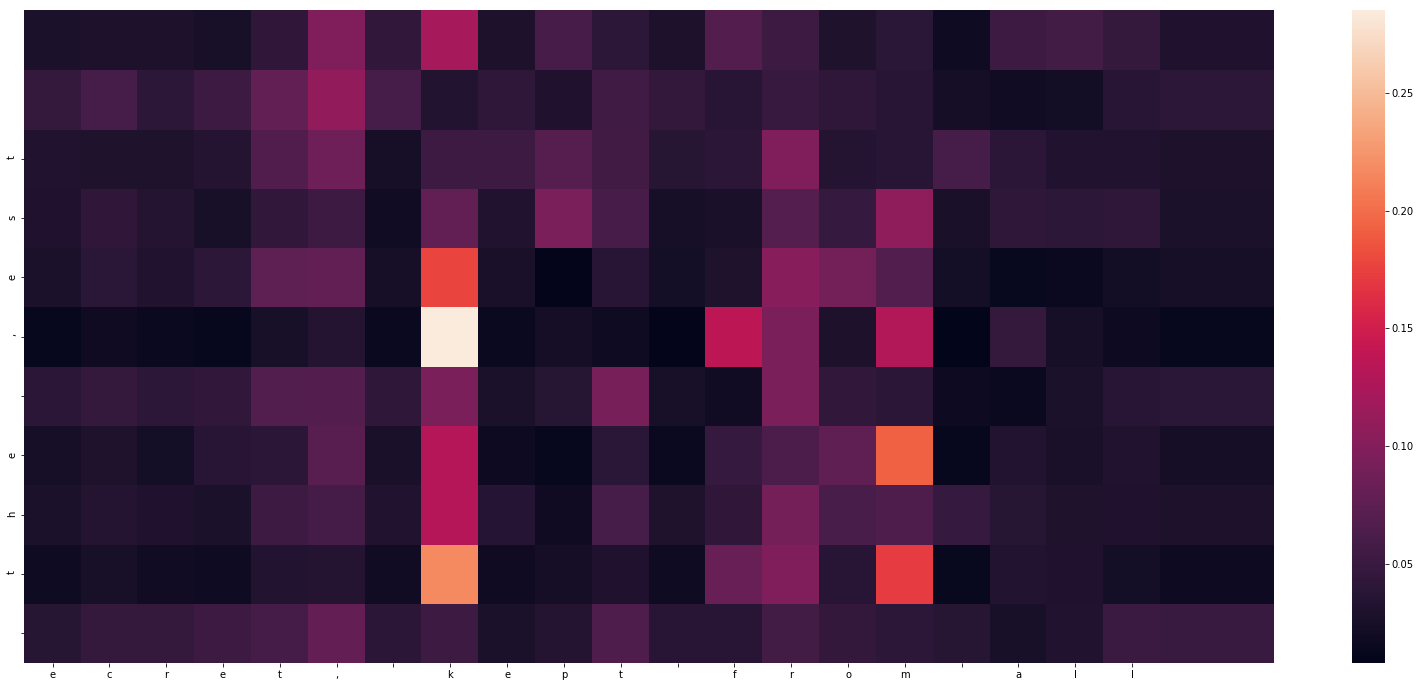

-
Input sentence: ecret, kept from all
GT sentence:  the rest,
    Betwe
Decoded sentence:  the ,est


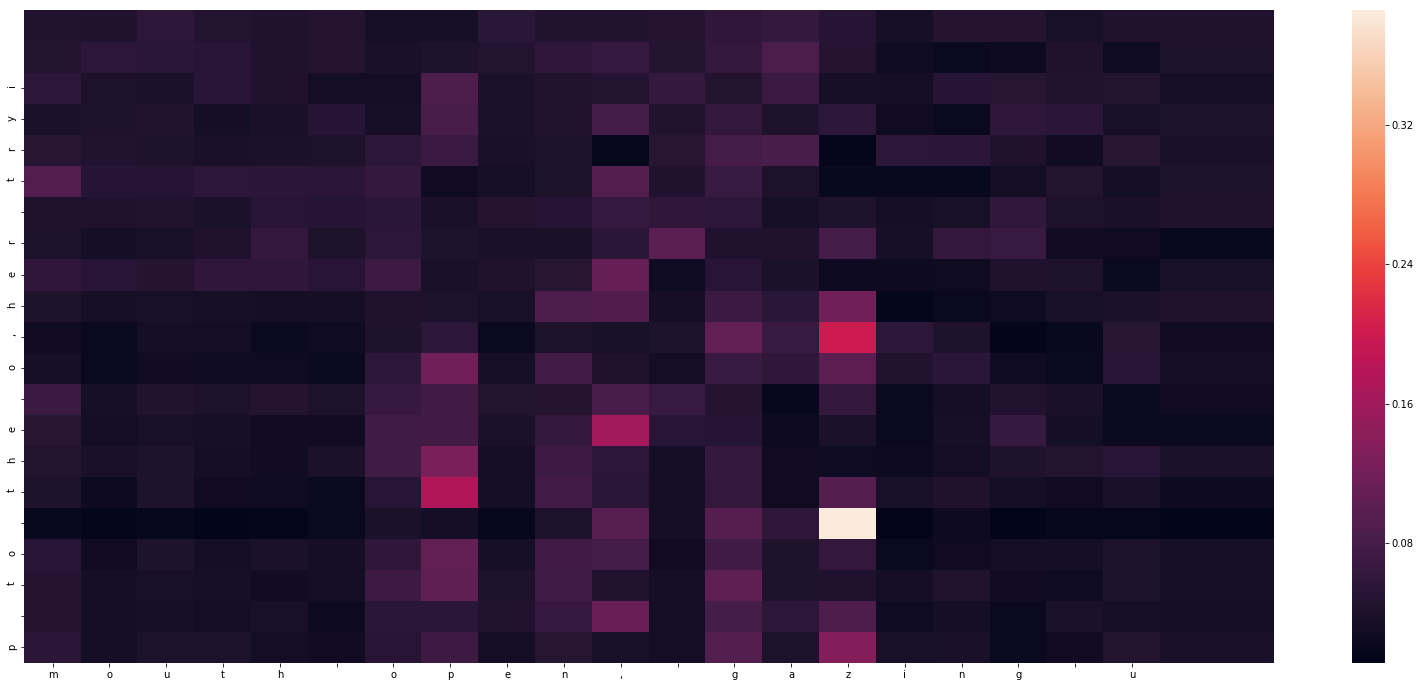

-
Input sentence: mouth open, gazing u
GT sentence: p into the roof of t
Decoded sentence: p to the o,her tryi


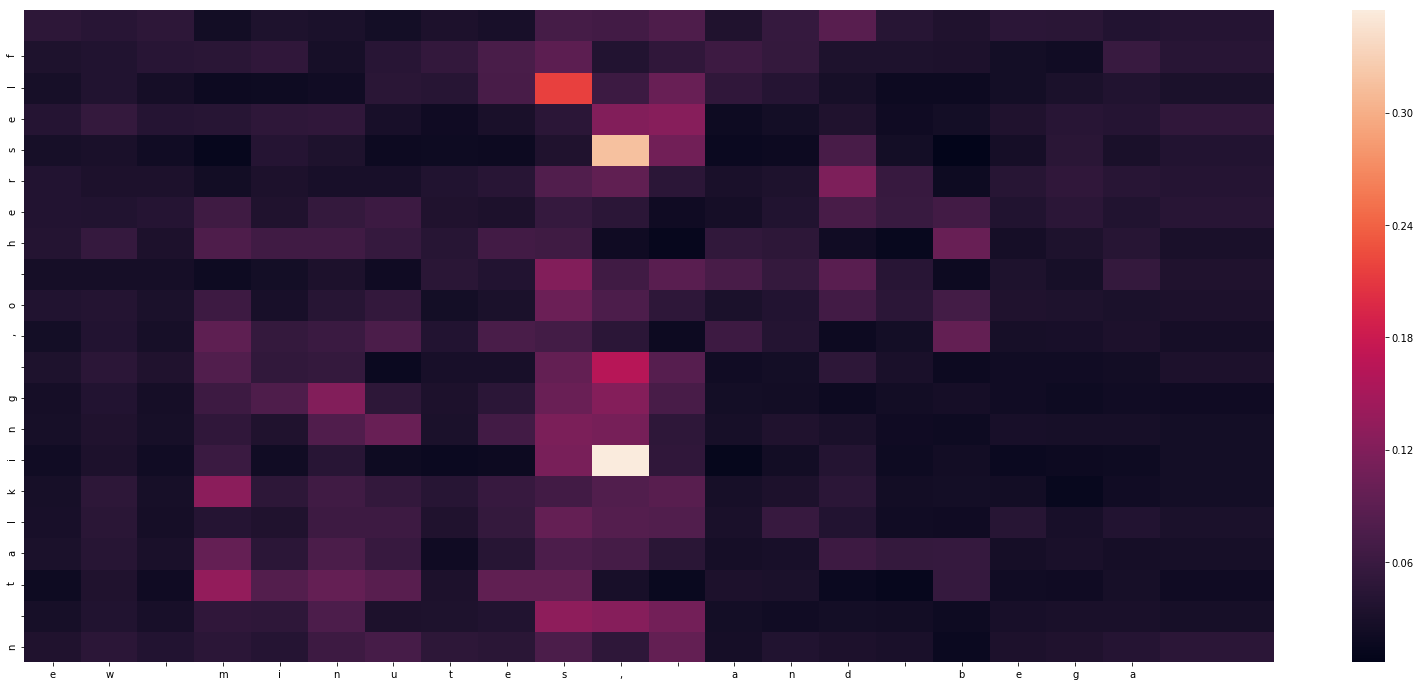

-
Input sentence: ew minutes,
and bega
GT sentence: n talking to herself
Decoded sentence: n talking ,o herself


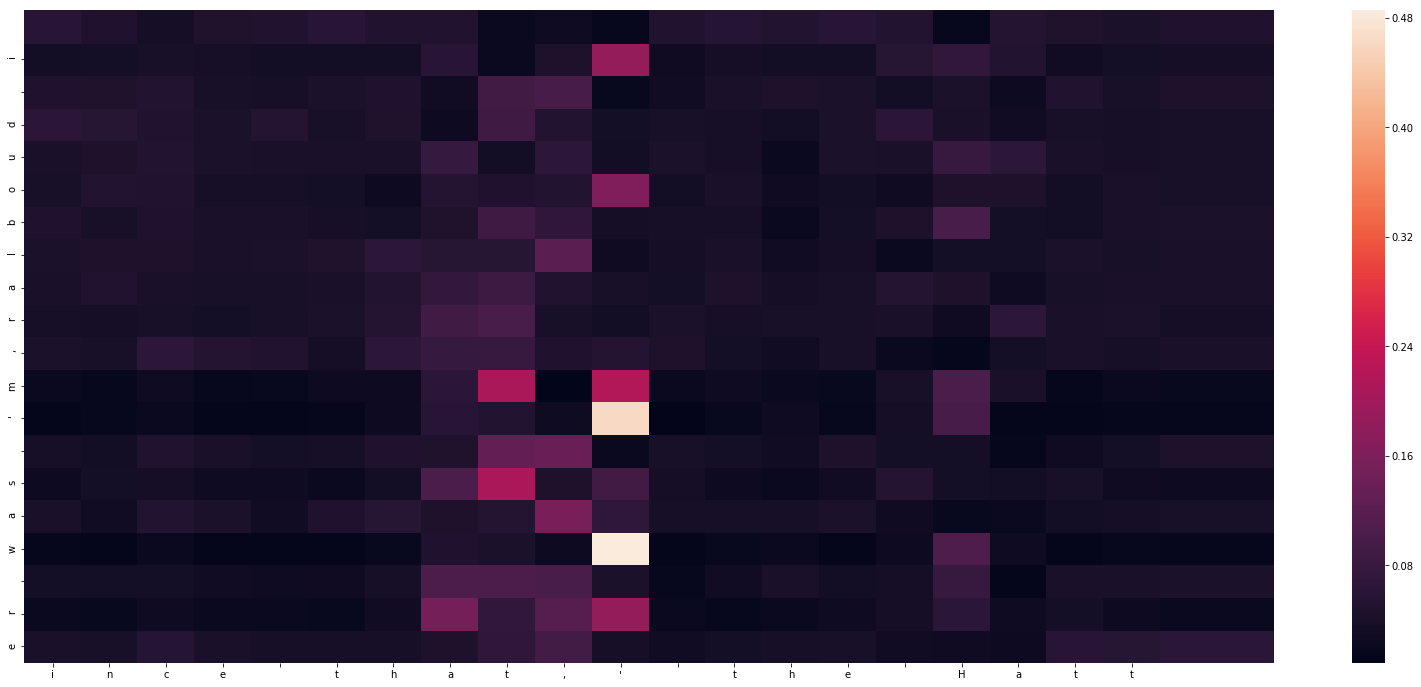

-
Input sentence: ince that,' the Hatt
GT sentence: er went on in a mour
Decoded sentence: er was 'm,ralboud i


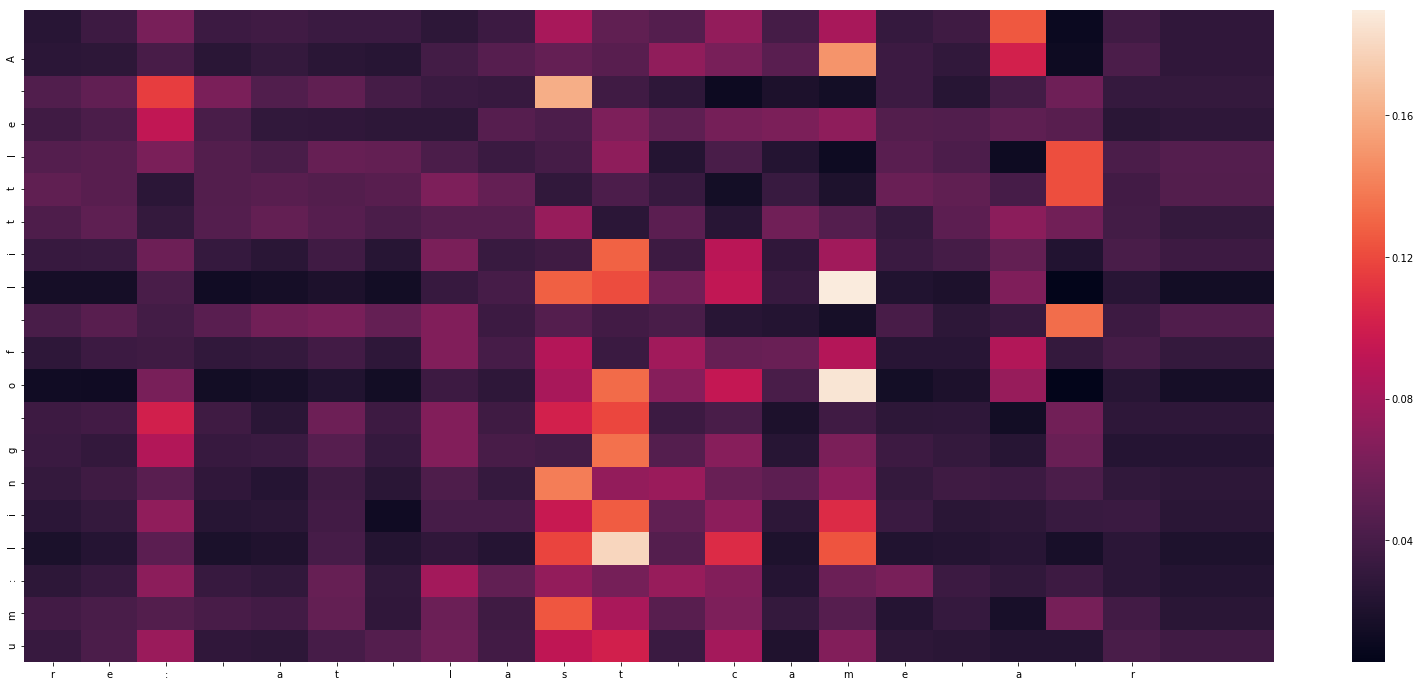

-
Input sentence: re: at last came a
r
GT sentence: umbling of little ca
Decoded sentence: um:ling of little A


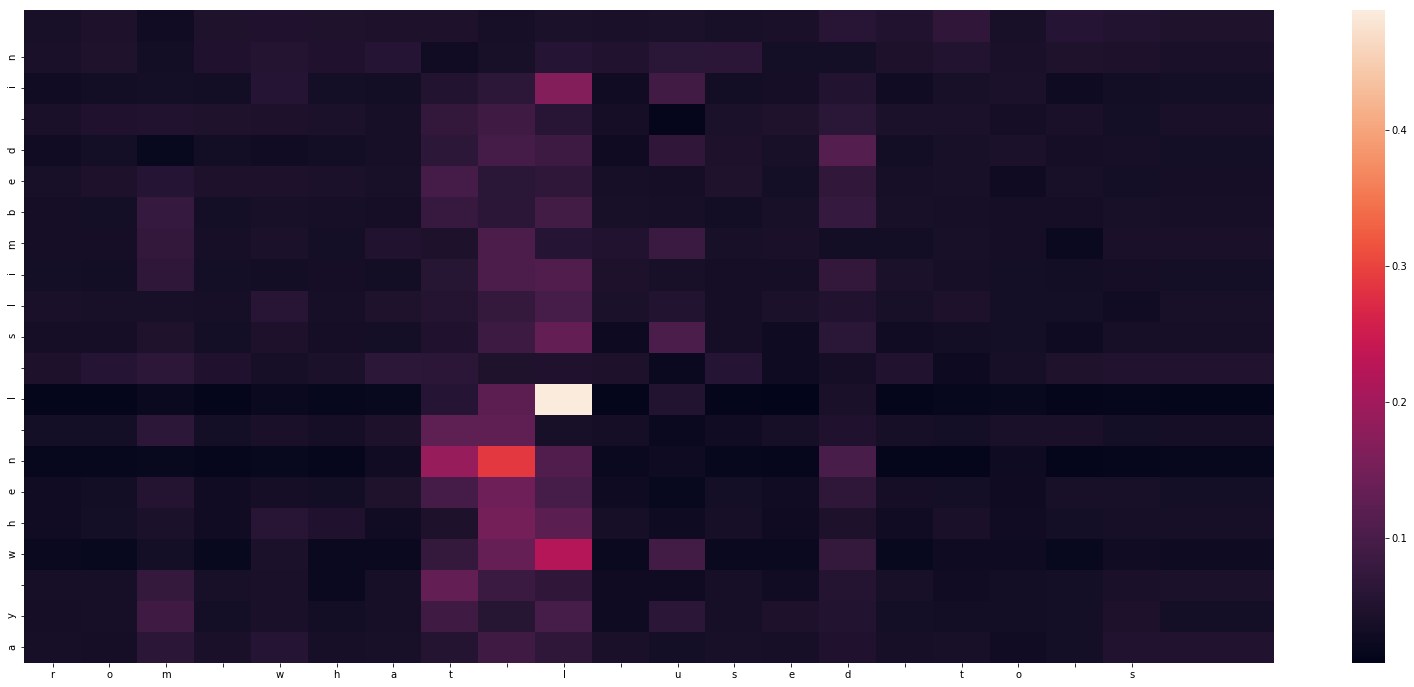

-
Input sentence: rom what I used to s
GT sentence: ay when I was a chil
Decoded sentence: ay when I slimbed in


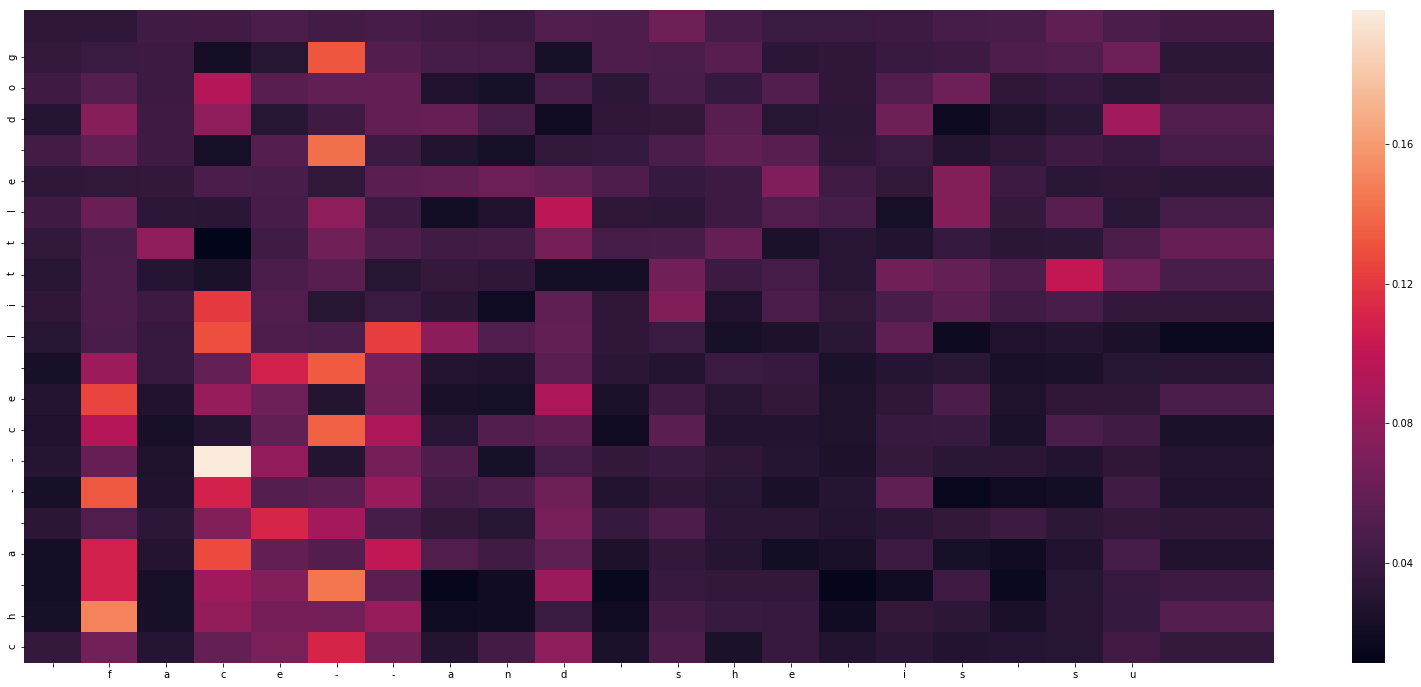

-
Input sentence:  face--and she is su
GT sentence: ch a nice soft thing
Decoded sentence: ch a --ce little dog


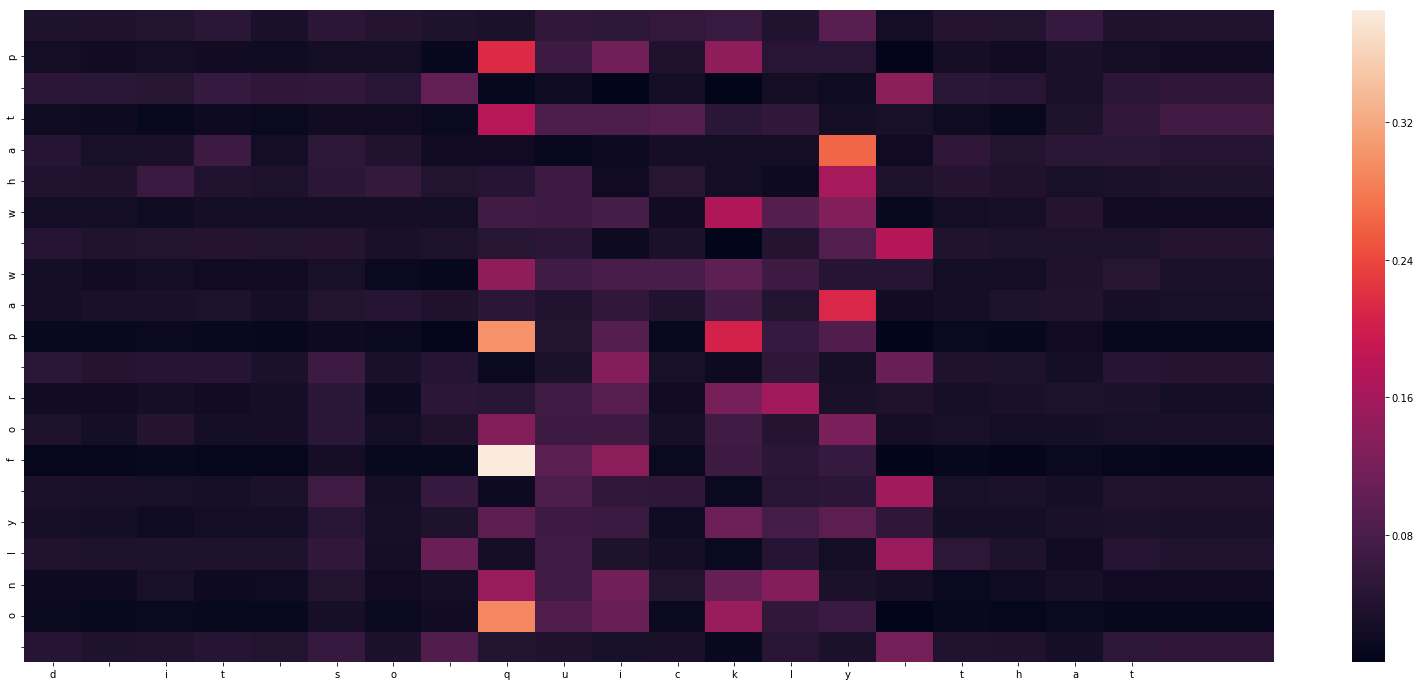

-
Input sentence: d it so quickly
that
GT sentence:  the poor little jur
Decoded sentence:  only for paw what p


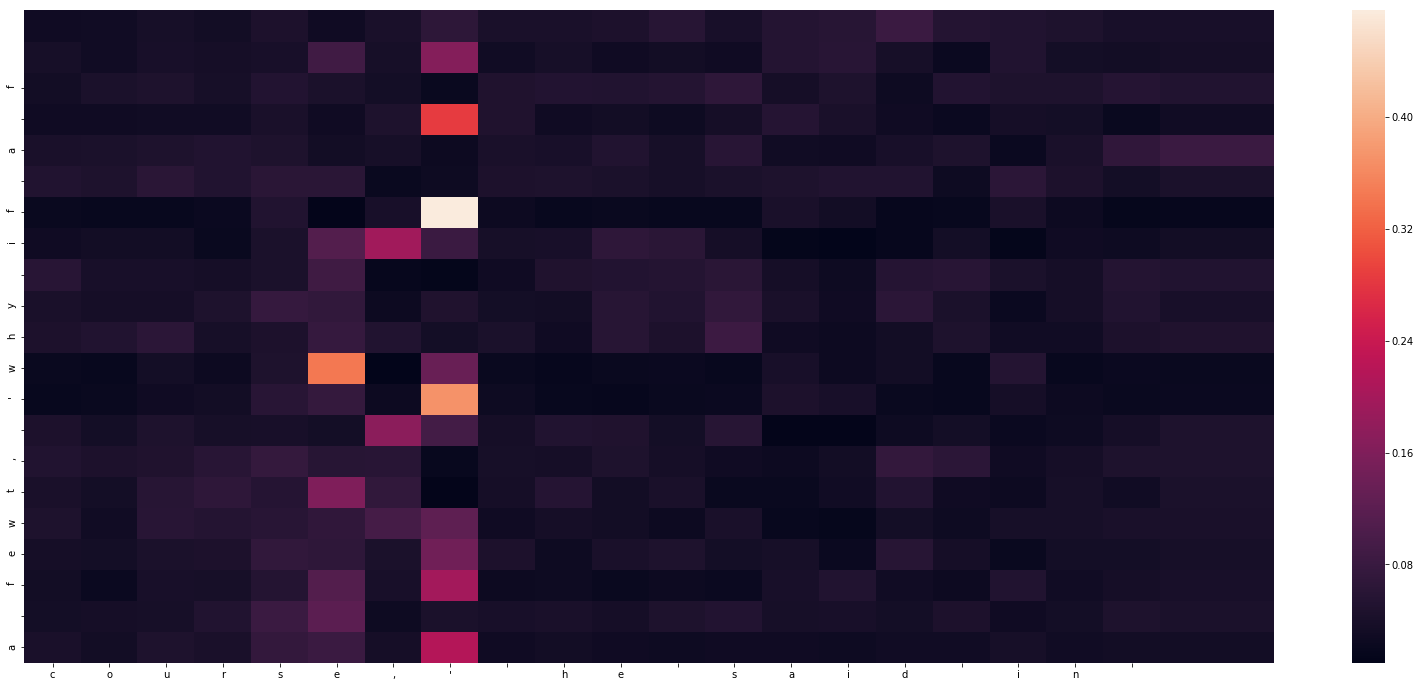

-
Input sentence: course,' he said in 
GT sentence: a
very respectful to
Decoded sentence: a fewt, 'why if a f


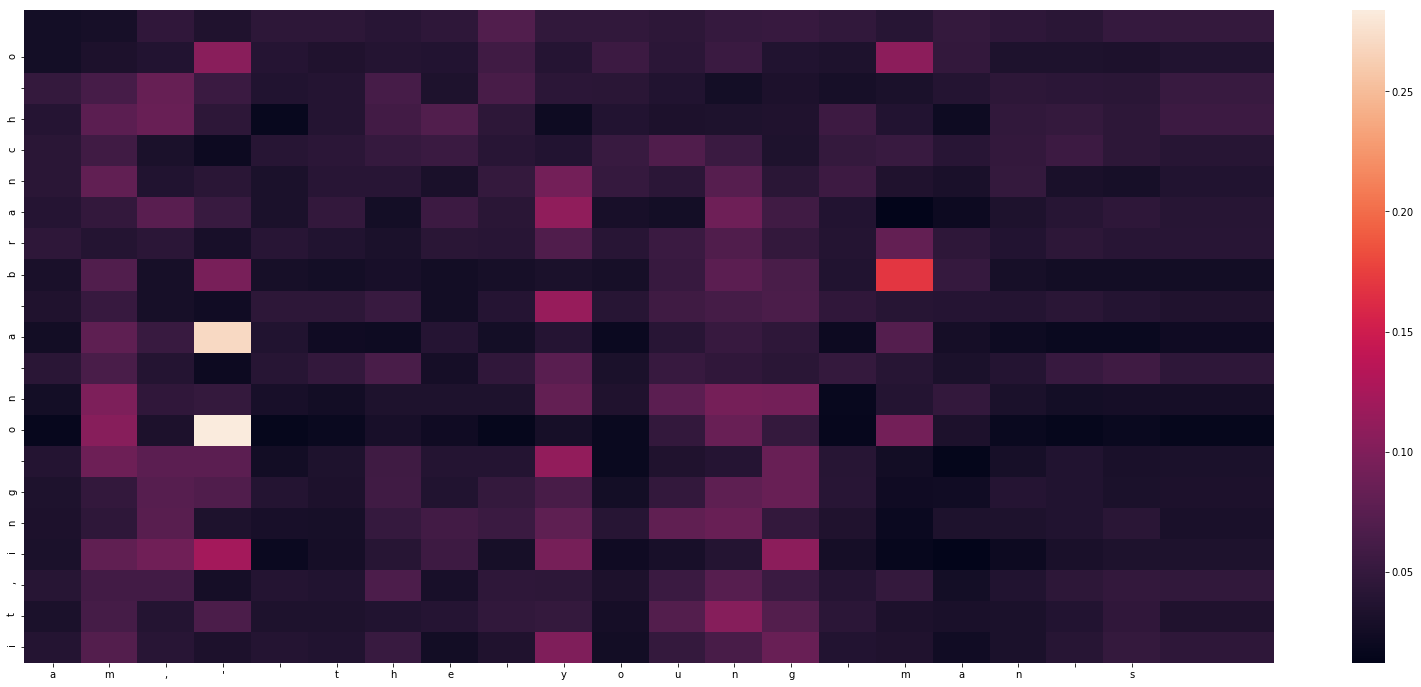

-
Input sentence: am,' the young man s
GT sentence: aid,
    'And your h
Decoded sentence: it,ing on a branch o


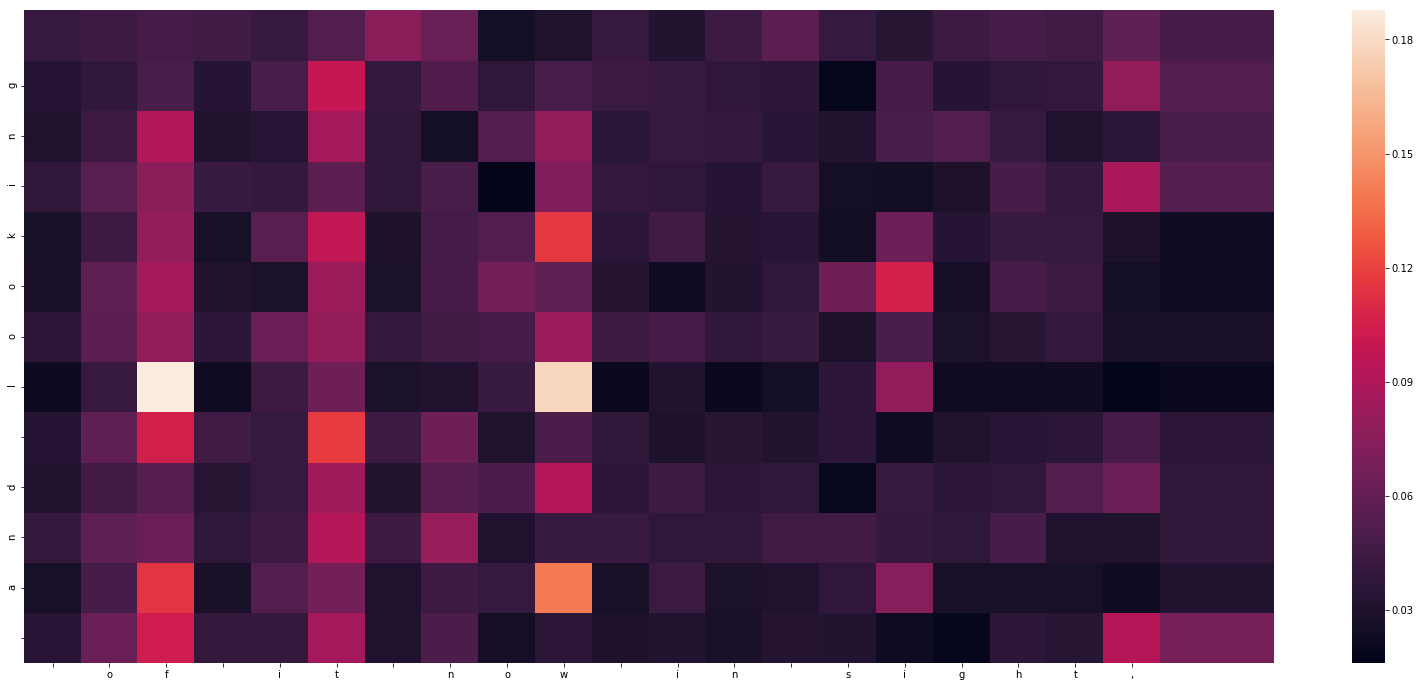

-
Input sentence:  of it now in sight,
GT sentence:  and no more of it a
Decoded sentence:  and looking


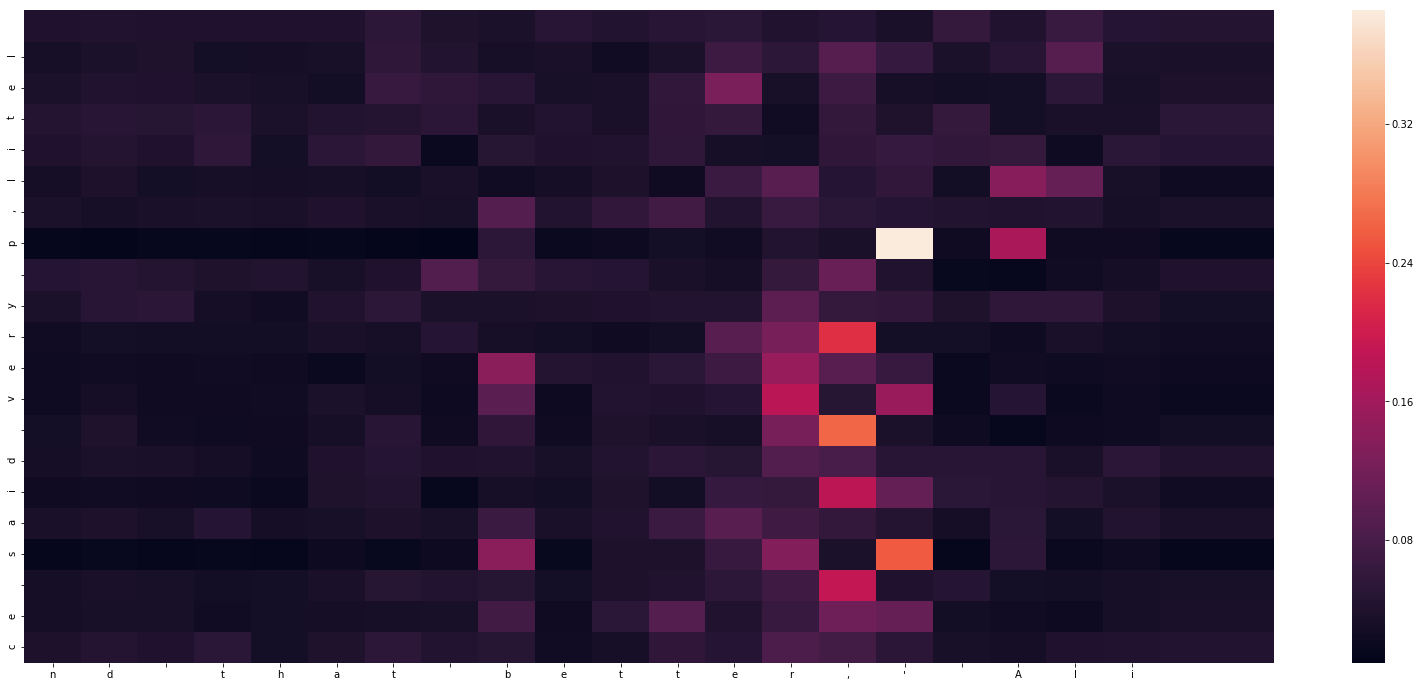

-
Input sentence: nd that better,' Ali
GT sentence: ce said very politel
Decoded sentence: ce said very p,litel


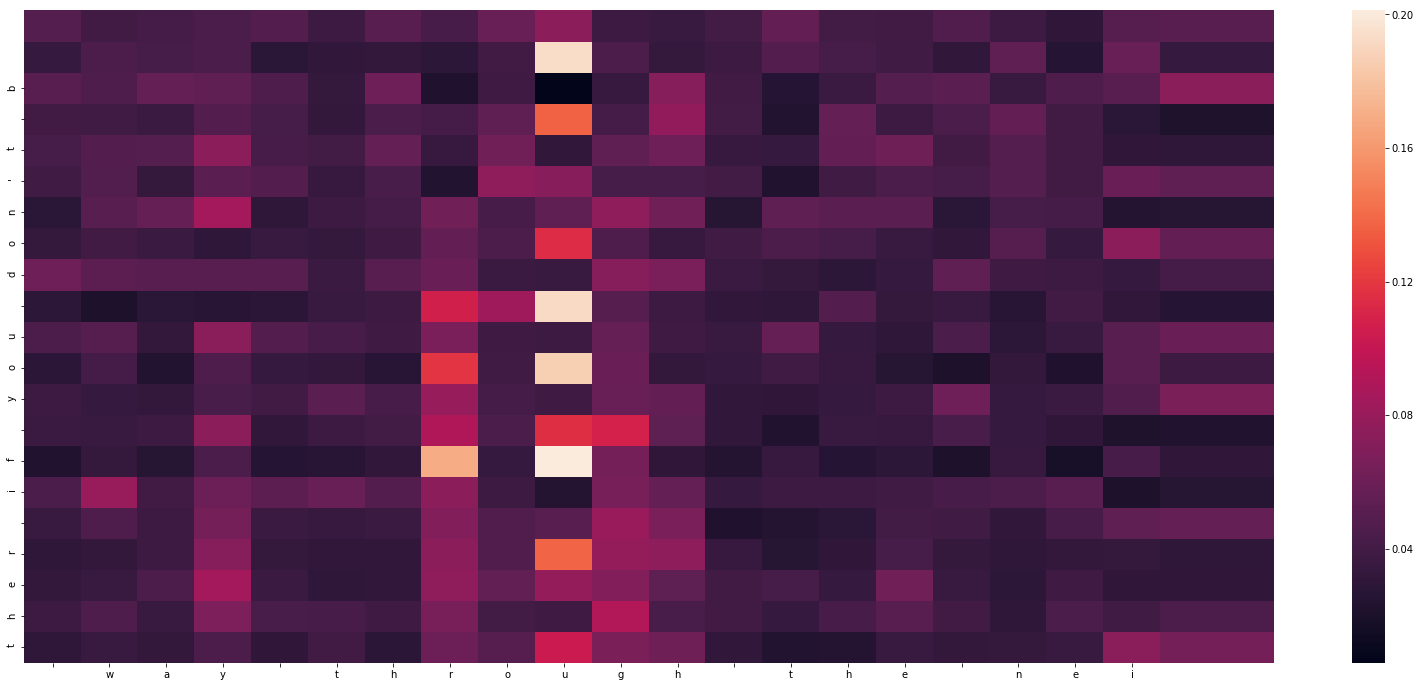

-
Input sentence:  way through the nei
GT sentence: ghbouring pool--she

Decoded sentence: ther if you don't b


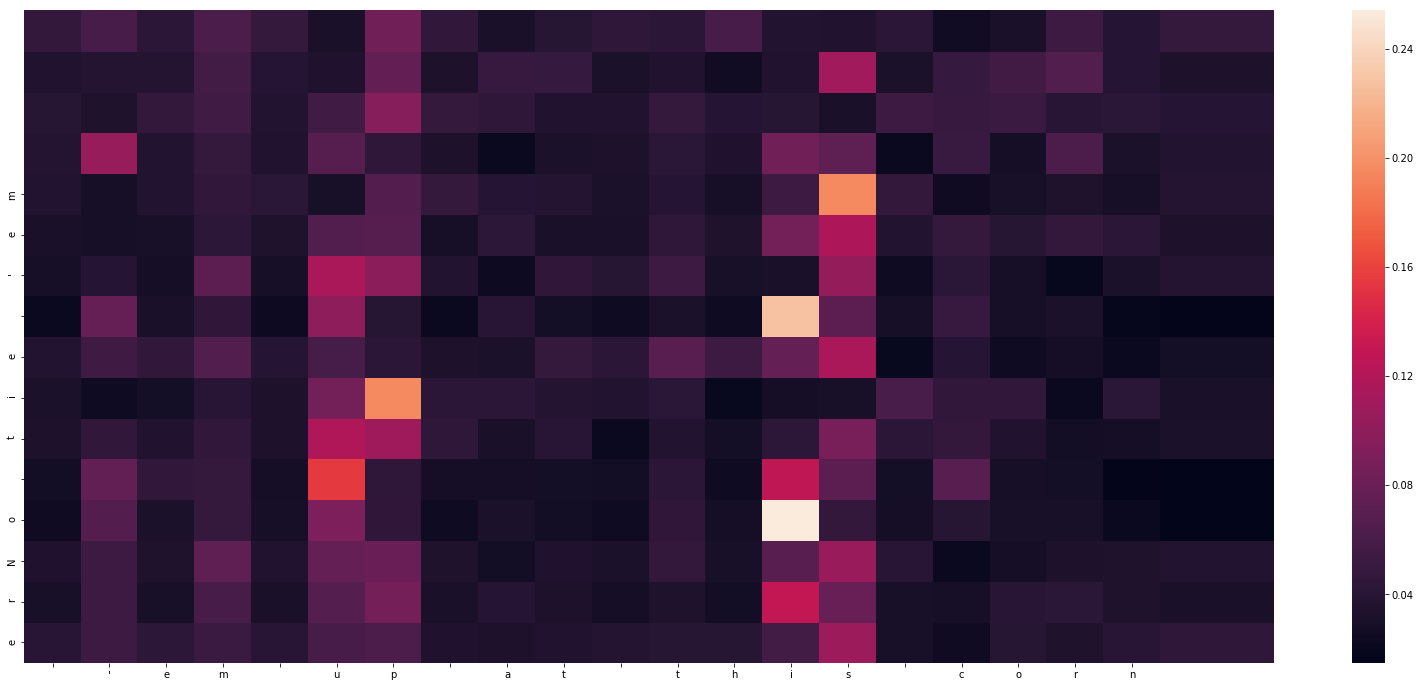

-
Input sentence:  'em up at this corn
GT sentence: er--No, tie 'em
toge
Decoded sentence: erNo tie 'em


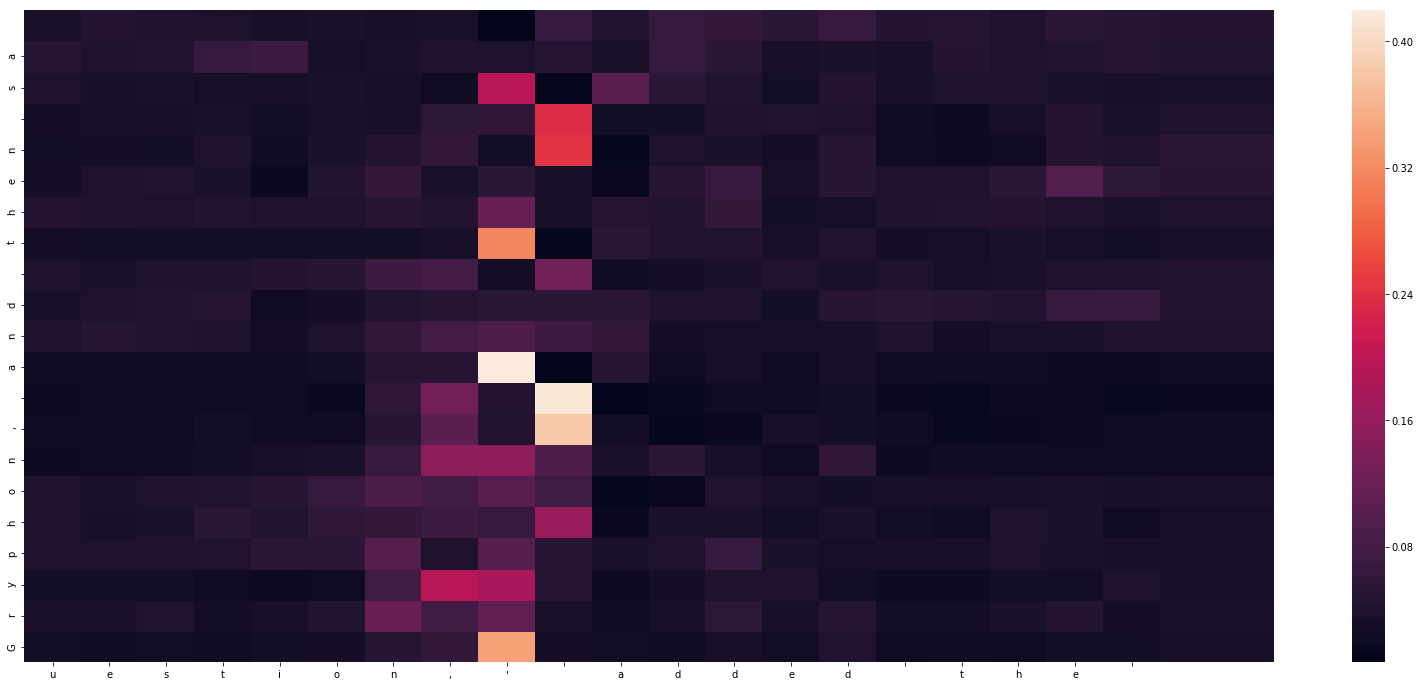

-
Input sentence: uestion,'
added the 
GT sentence: Gryphon; and then th
Decoded sentence: Gryphon, and then sa


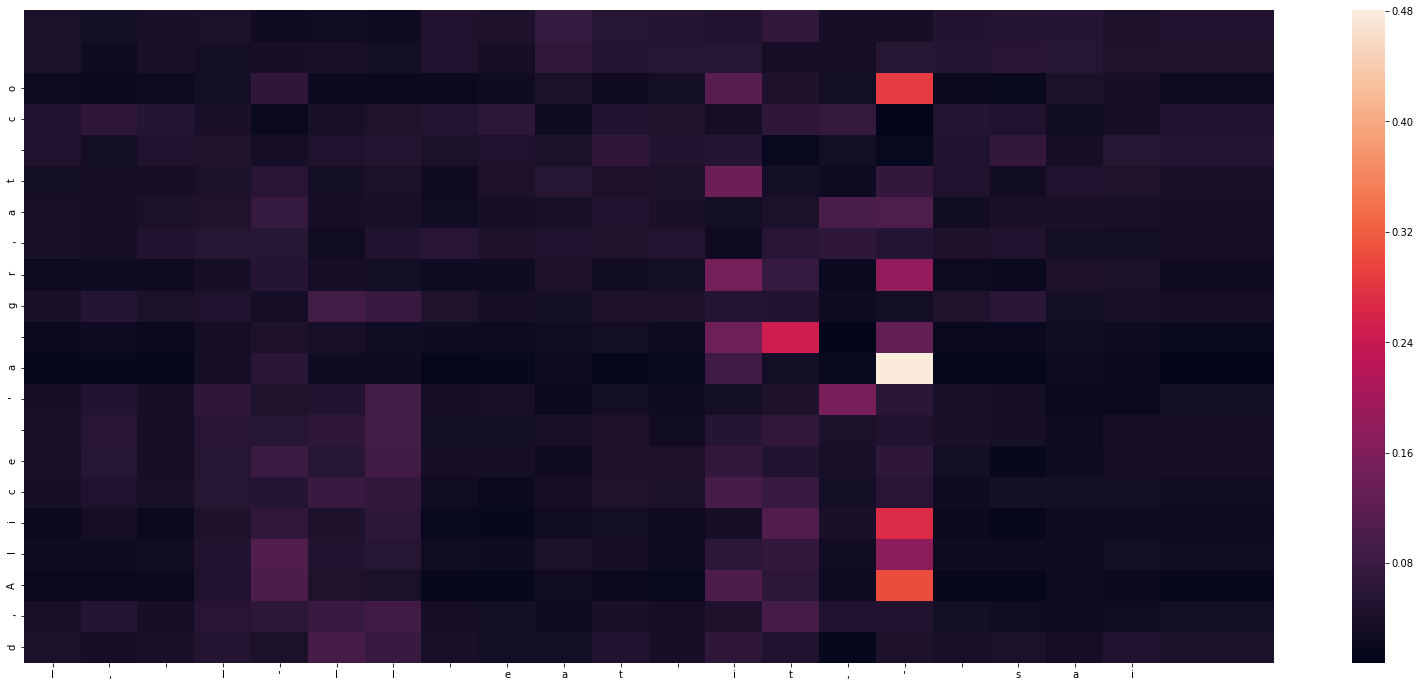

-
Input sentence: l, I'll eat it,' sai
GT sentence: d
Alice, 'and if it 
Decoded sentence: d,Alice 'a gr,at co


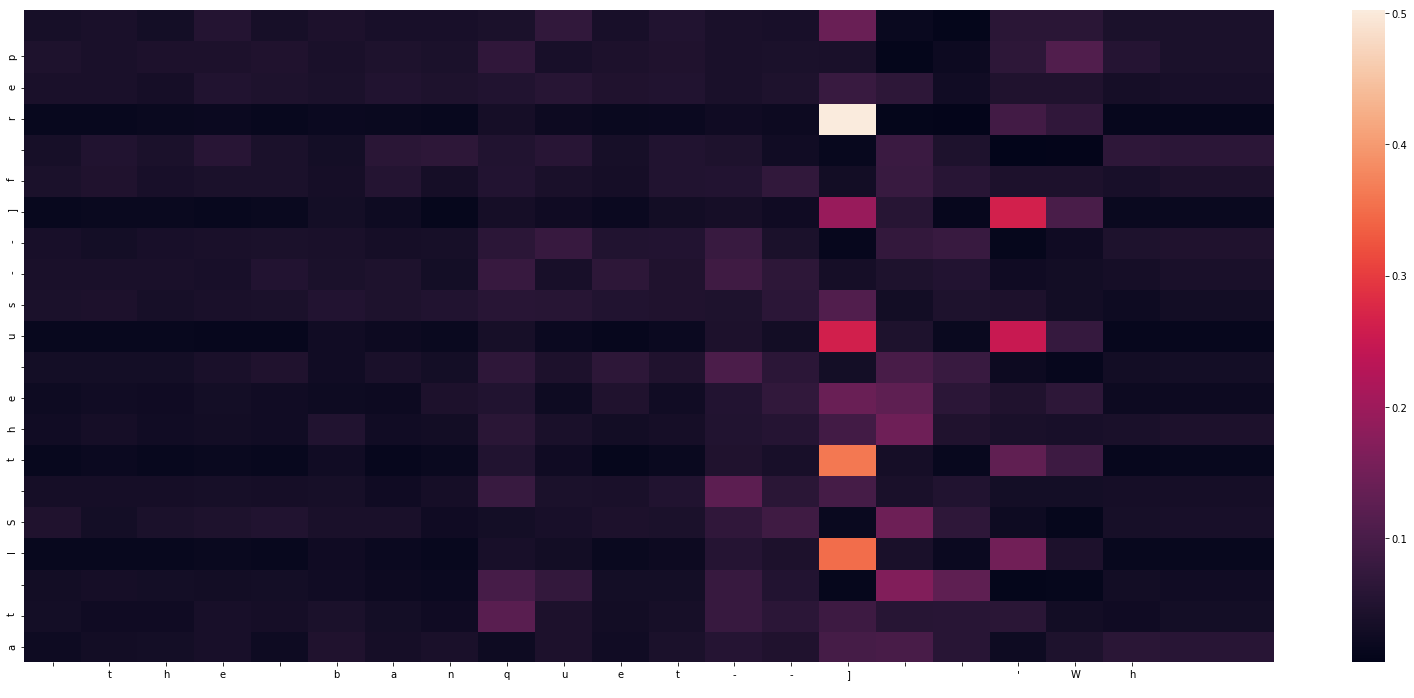

-
Input sentence:  the banquet--]

'Wh
GT sentence: at IS the use of rep
Decoded sentence: at IS the us--]f rep


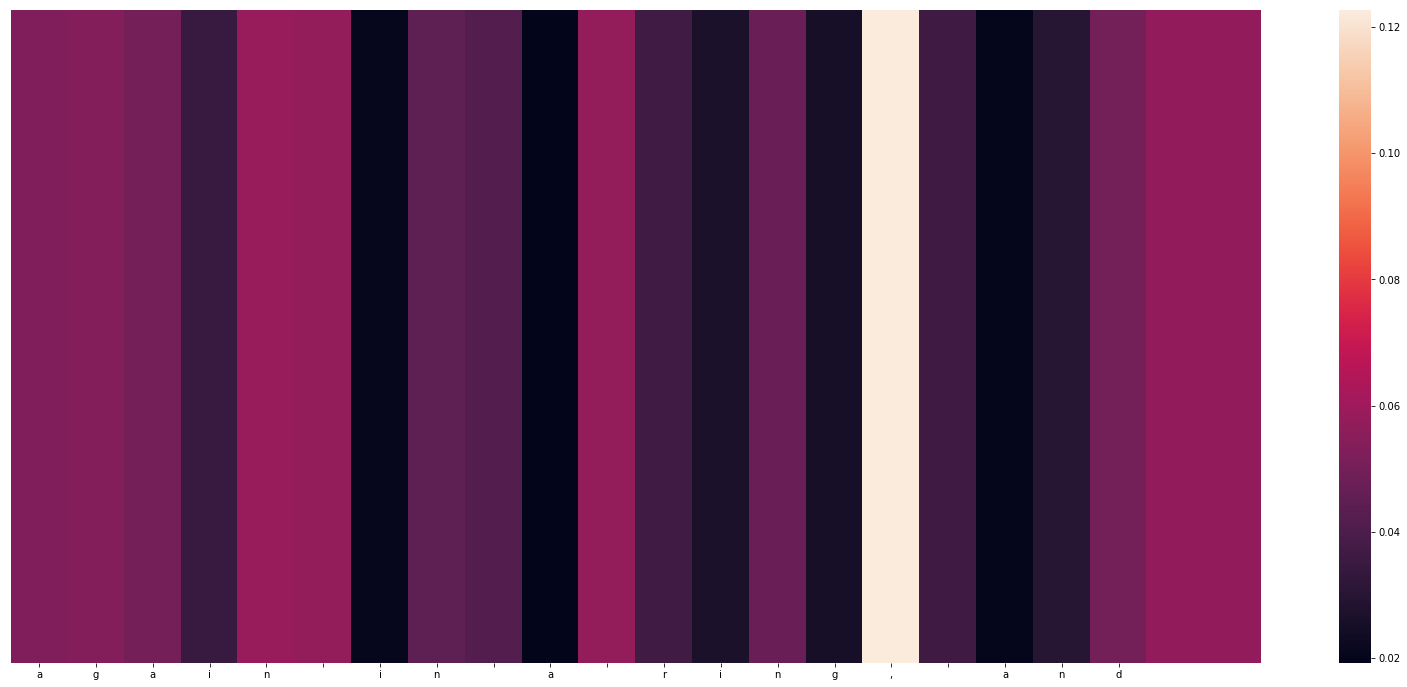

-
Input sentence: again in a ring, and
GT sentence: 
begged the Mouse to
Decoded sentence: 


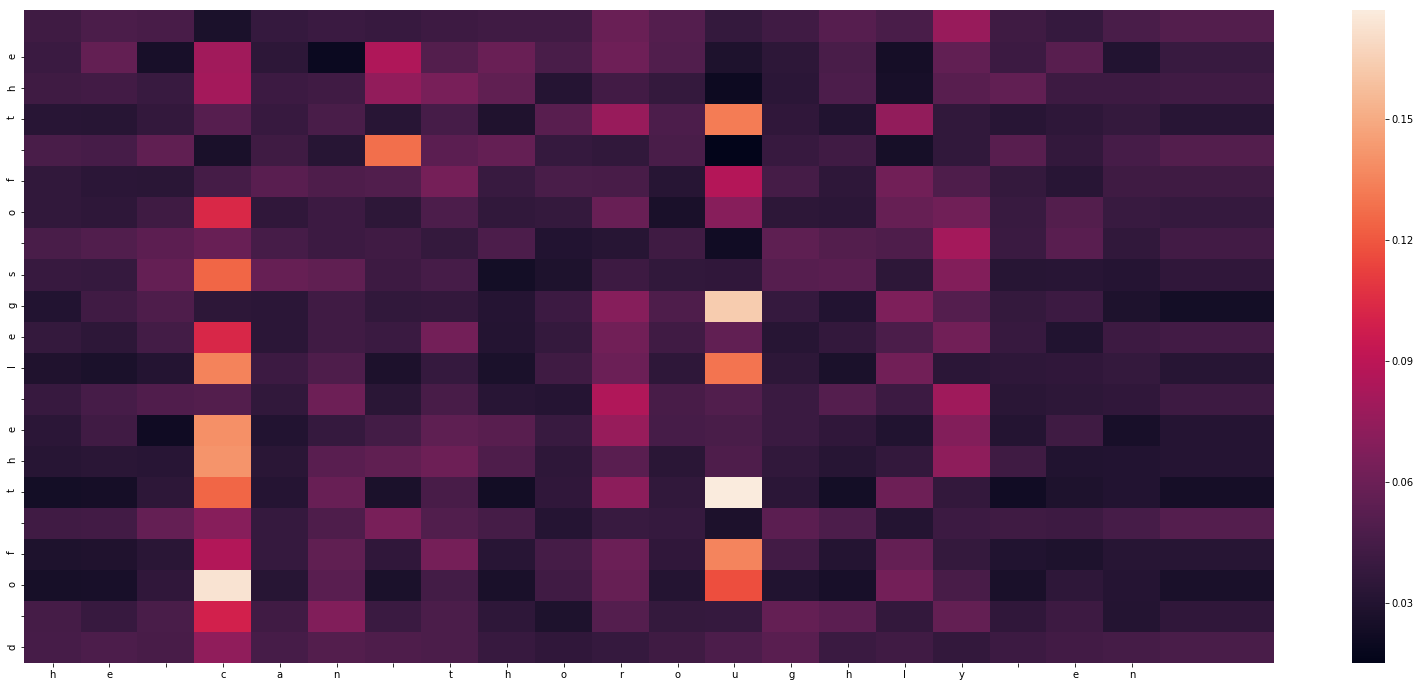

-
Input sentence: he can thoroughly en
GT sentence: joy
    The pepper w
Decoded sentence: d of the legs of the


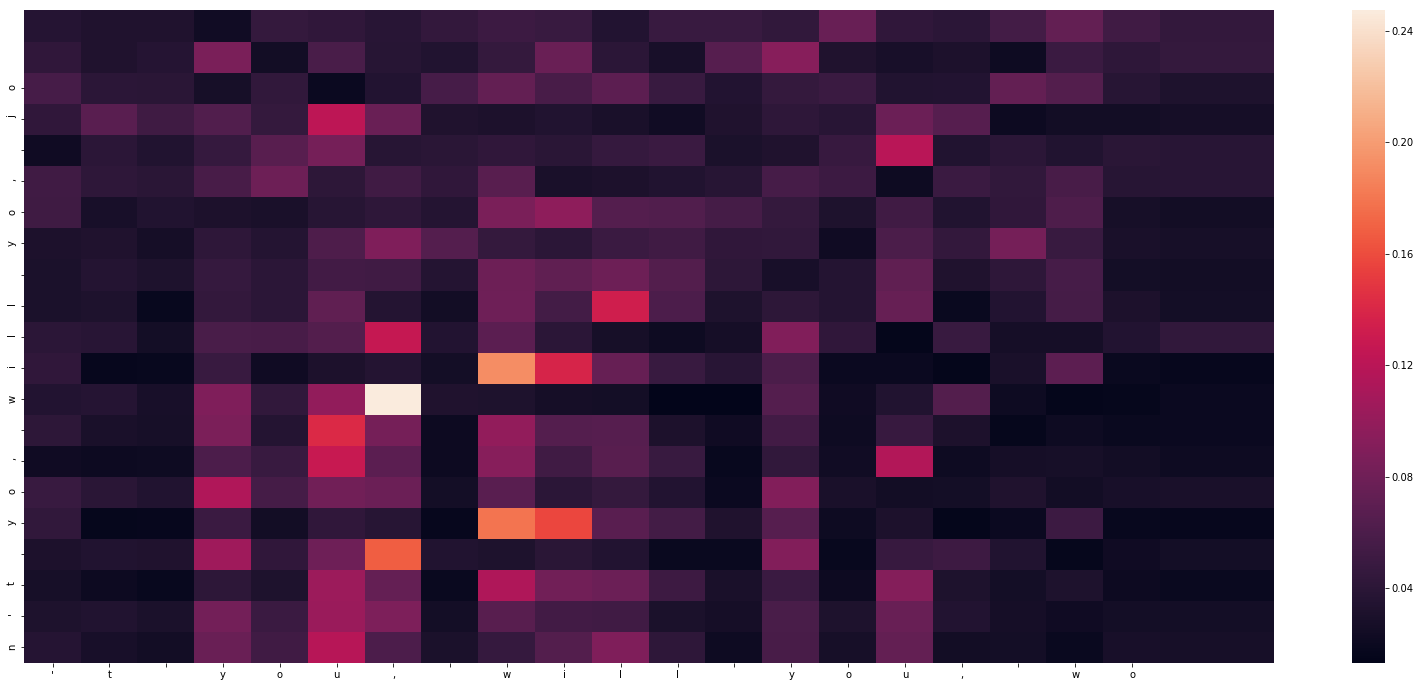

-
Input sentence: 't you, will you, wo
GT sentence: n't you, won't you j
Decoded sentence: n't yo, will yo, jo


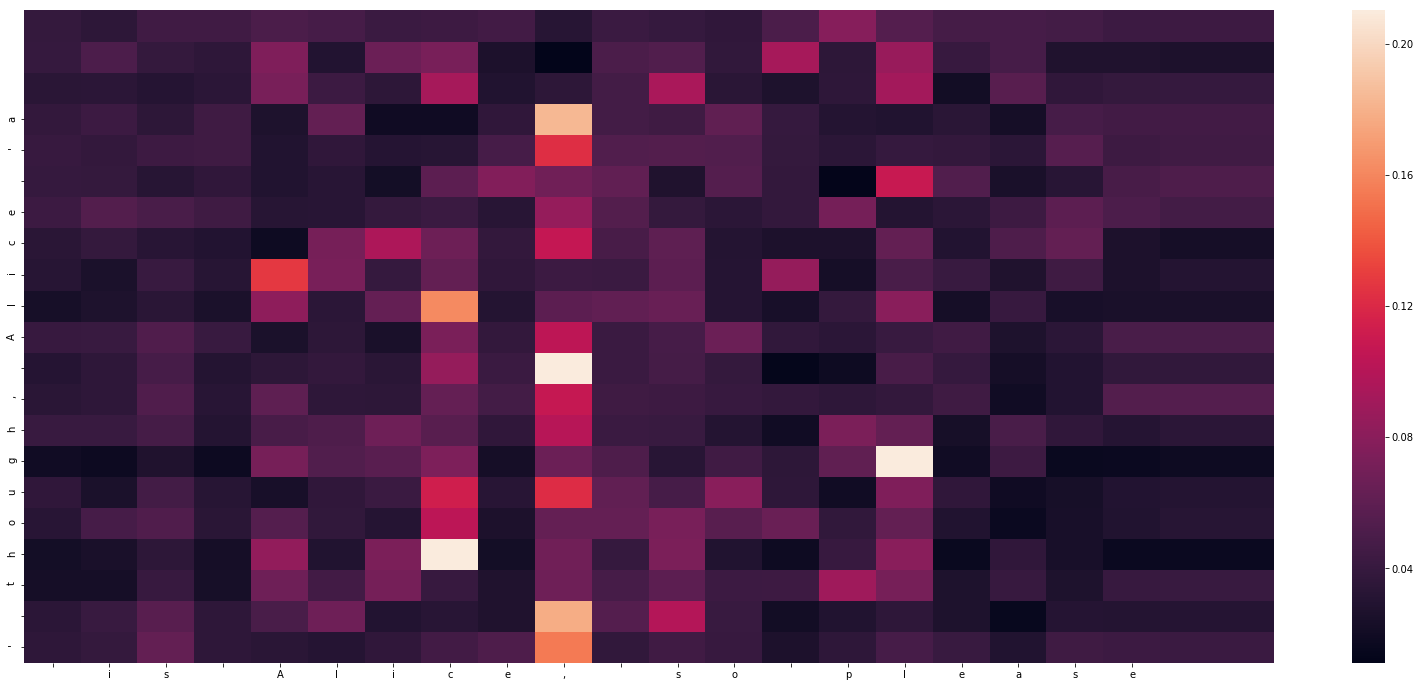

-
Input sentence:  is Alice, so please
GT sentence:  your Majesty,' said
Decoded sentence: ' though, Alice 'a


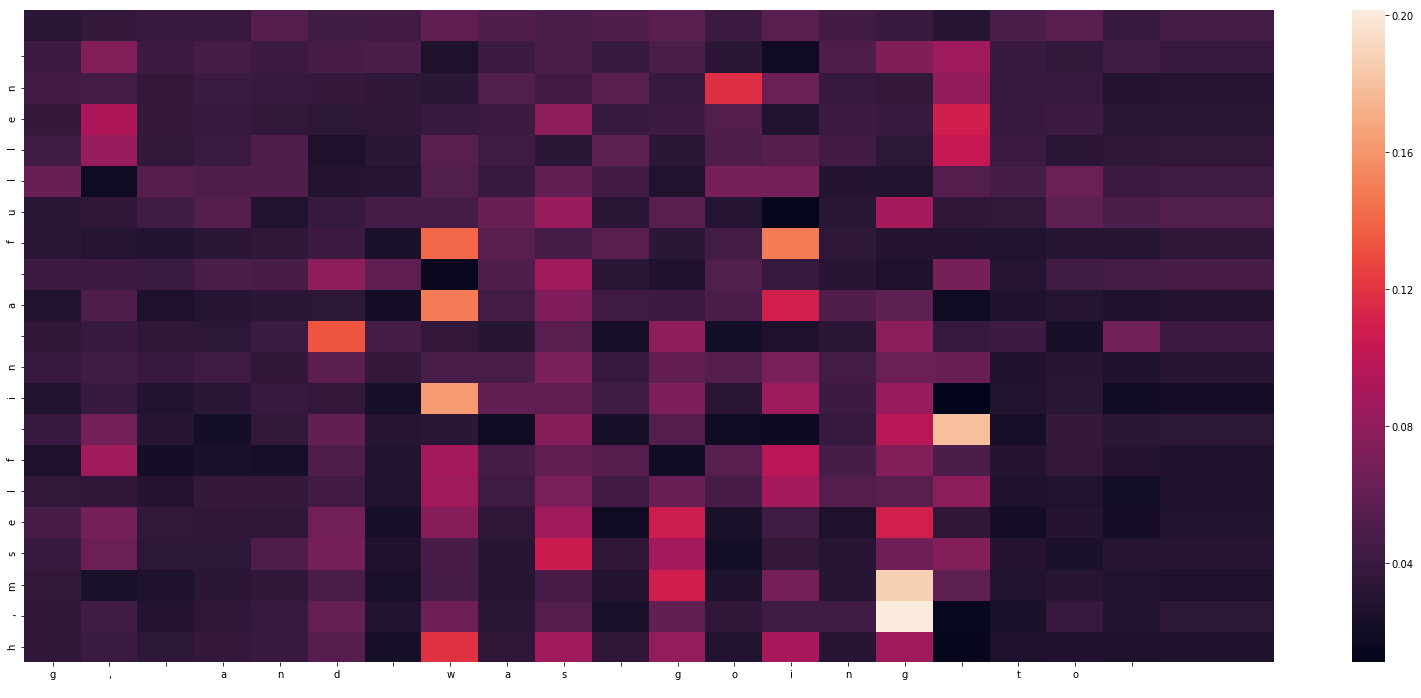

-
Input sentence: g, and was going
to 
GT sentence: dive in among the le
Decoded sentence: h,mself in a fullen 


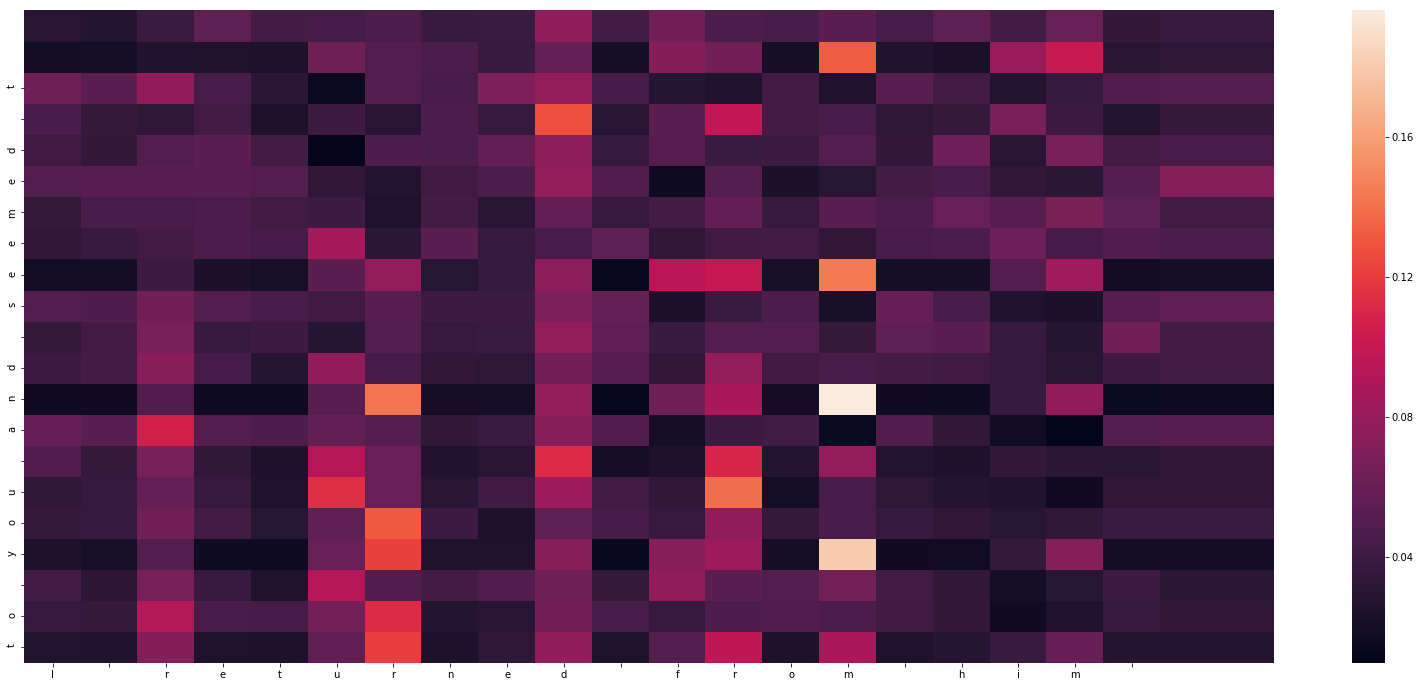

-
Input sentence: l returned from him 
GT sentence: to you,
    Though t
Decoded sentence: to you and seemed t


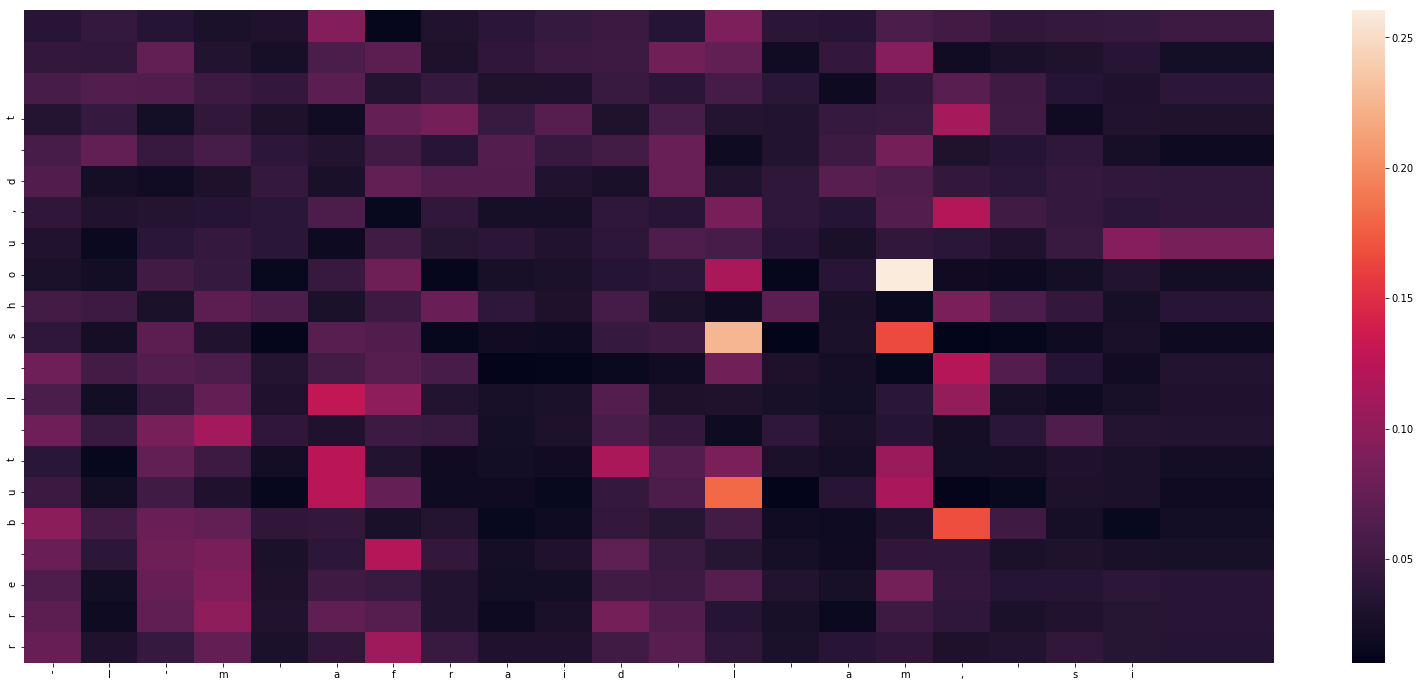

-
Input sentence: 'I'm afraid I am, si
GT sentence: r,' said Alice; 'I c
Decoded sentence: rre but I shou,d t


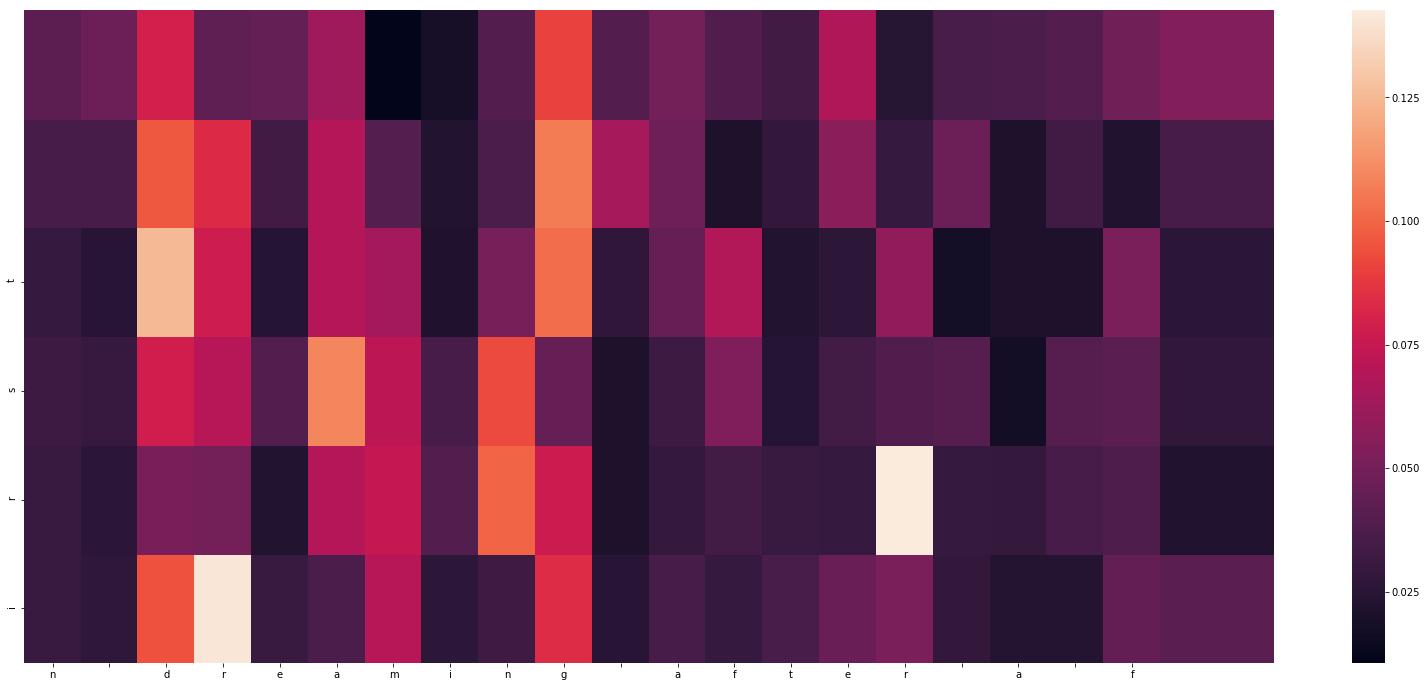

-
Input sentence: n dreaming after a f
GT sentence: ashion, and
this was
Decoded sentence: irst


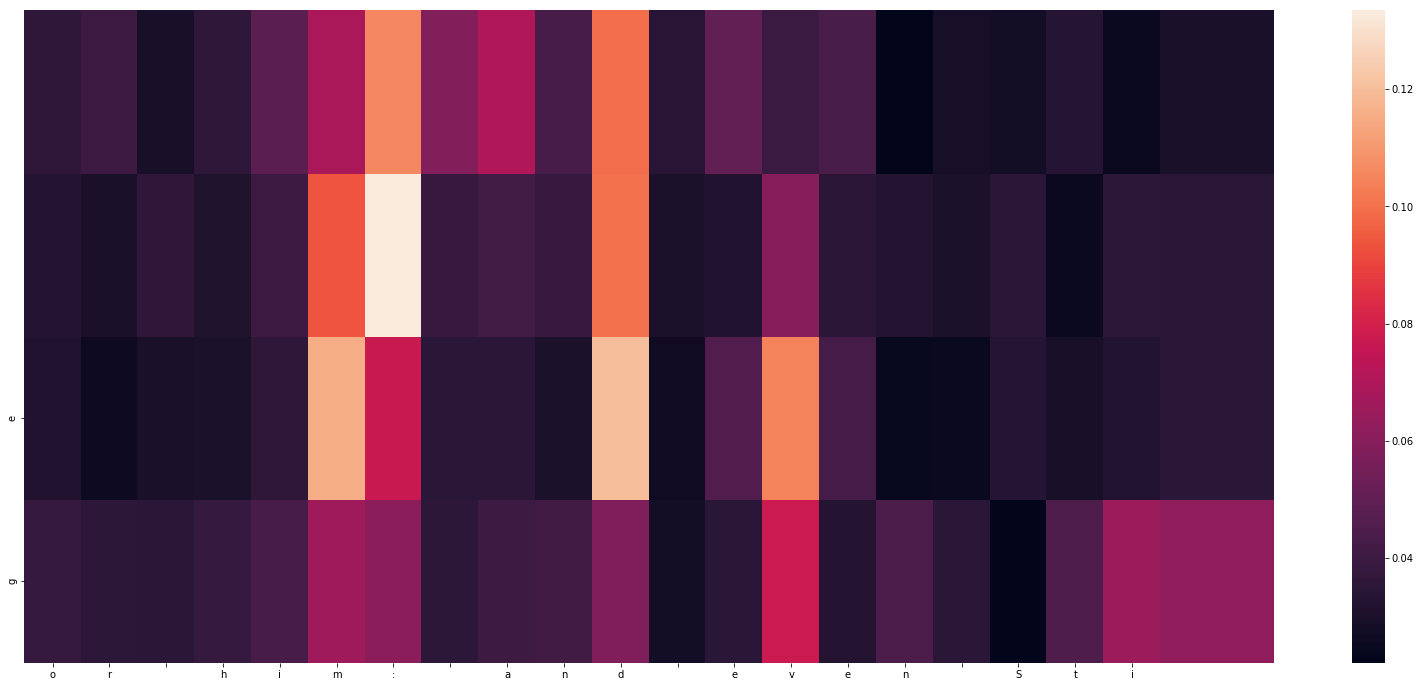

-
Input sentence: or him: and even Sti
GT sentence: gand,
the patriotic 
Decoded sentence: ge


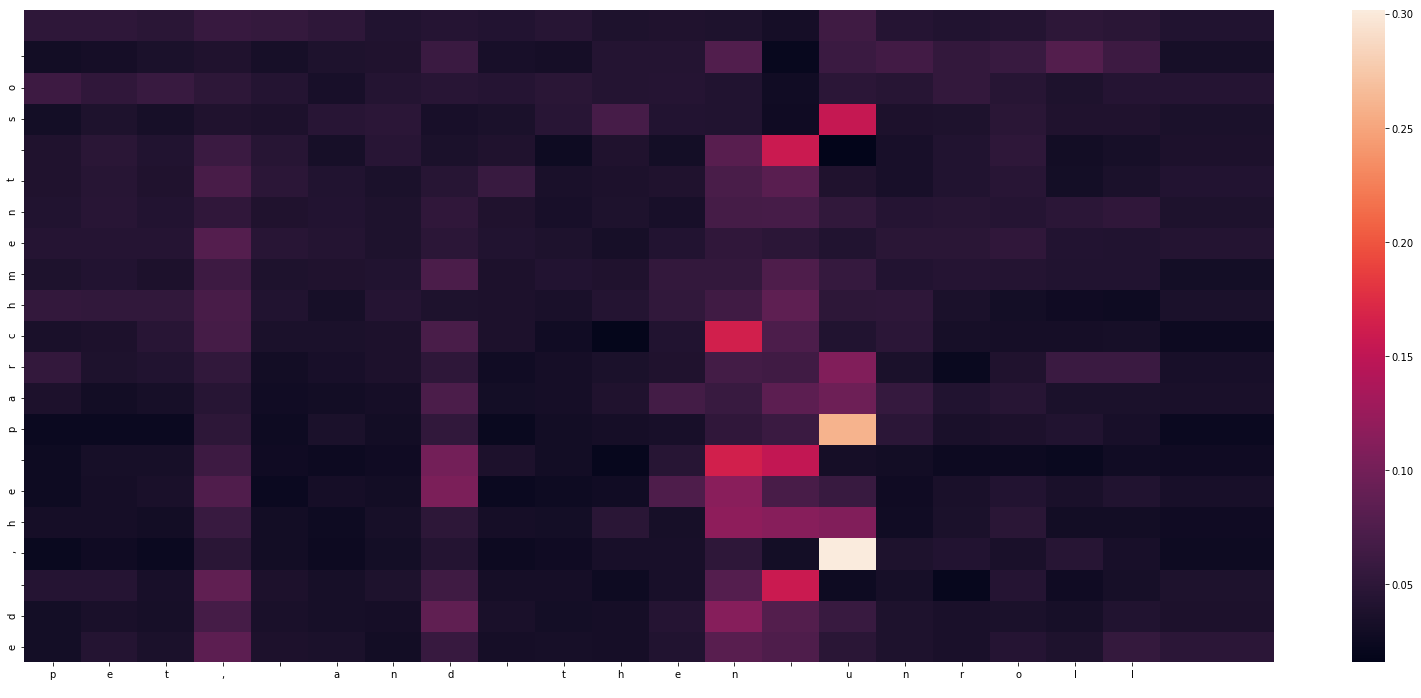

-
Input sentence: pet, and then
unroll
GT sentence: ed the parchment scr
Decoded sentence: ed ,he parchment so 


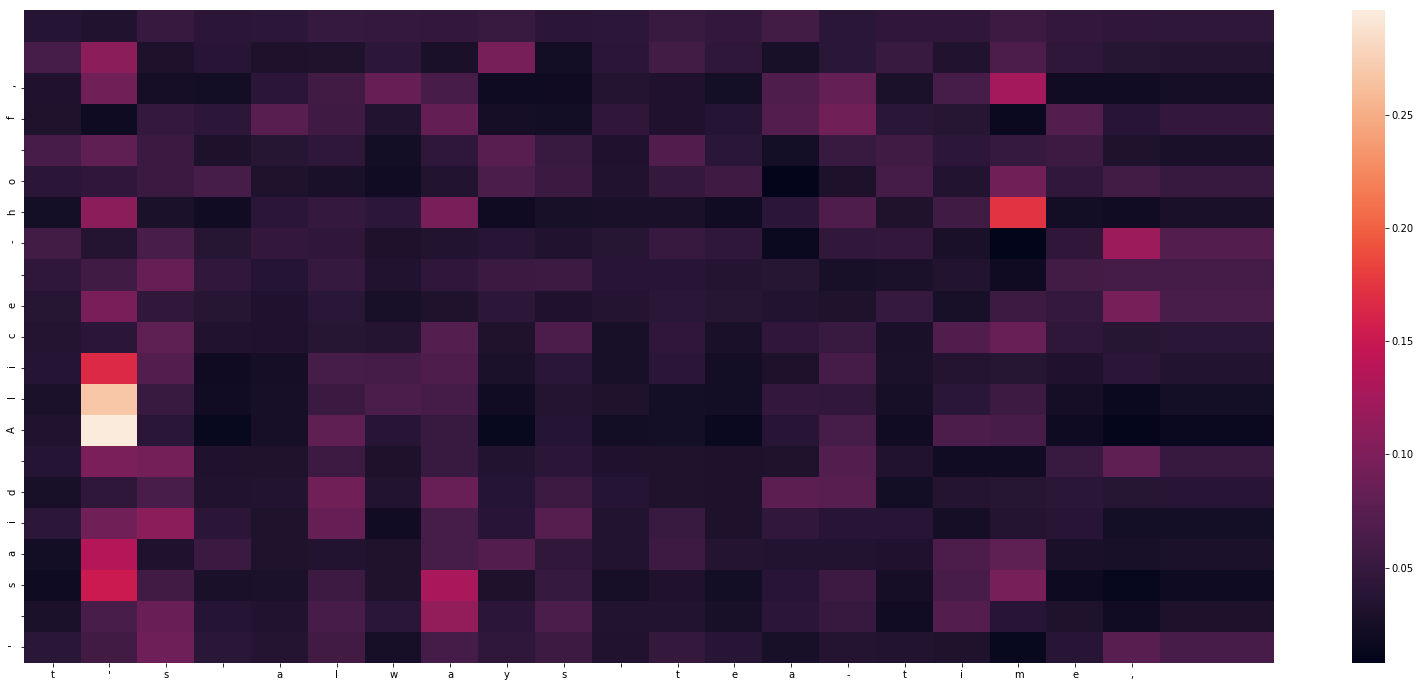

-
Input sentence: t's always tea-time,
GT sentence: 
and we've no time t
Decoded sentence: ' said Alice -ho f,


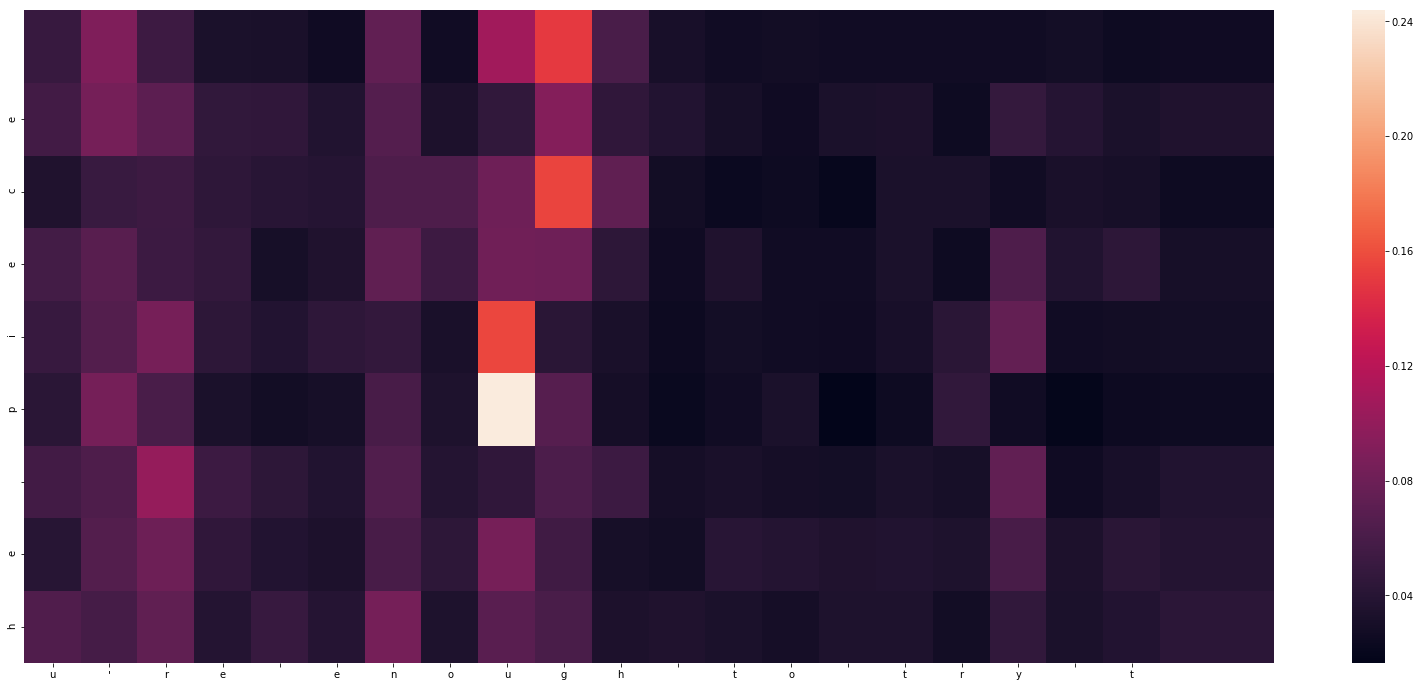

-
Input sentence: u're enough to try t
GT sentence: he patience of an oy
Decoded sentence: he piece


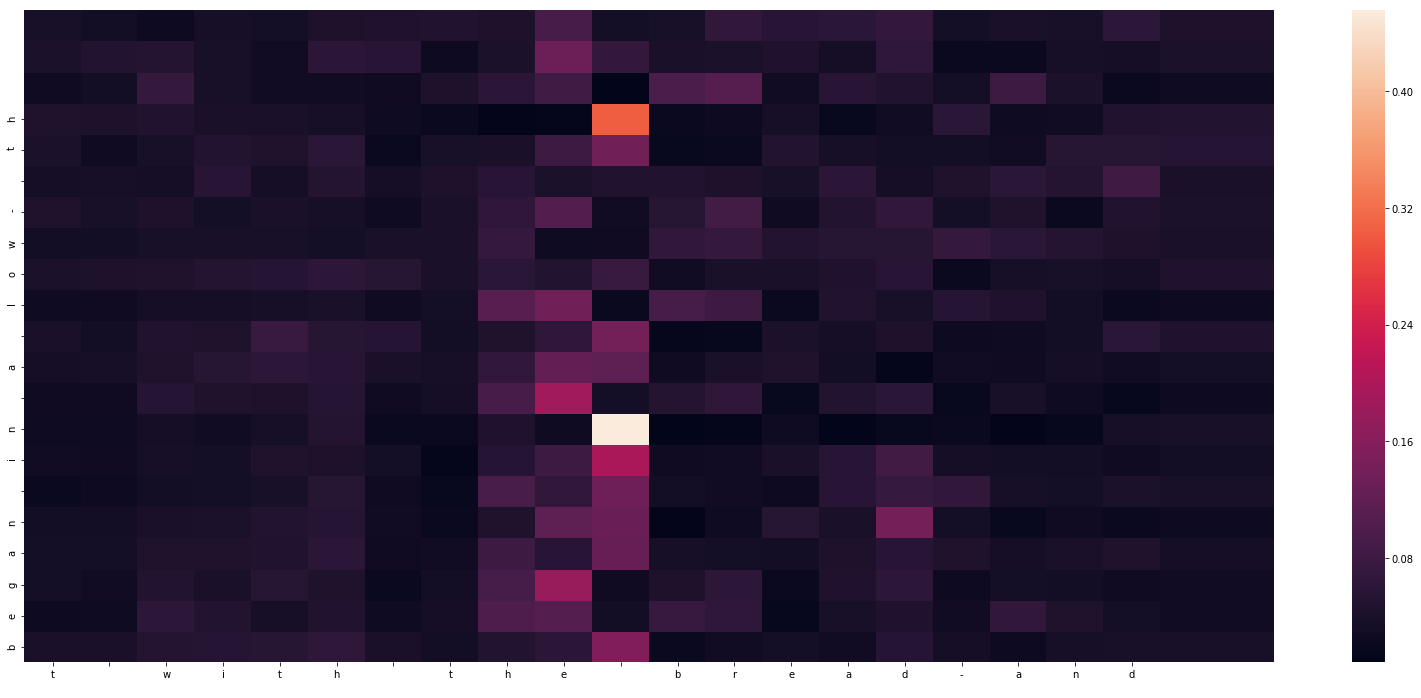

-
Input sentence: t with the
bread-and
GT sentence: -butter getting so t
Decoded sentence: began in a low- th


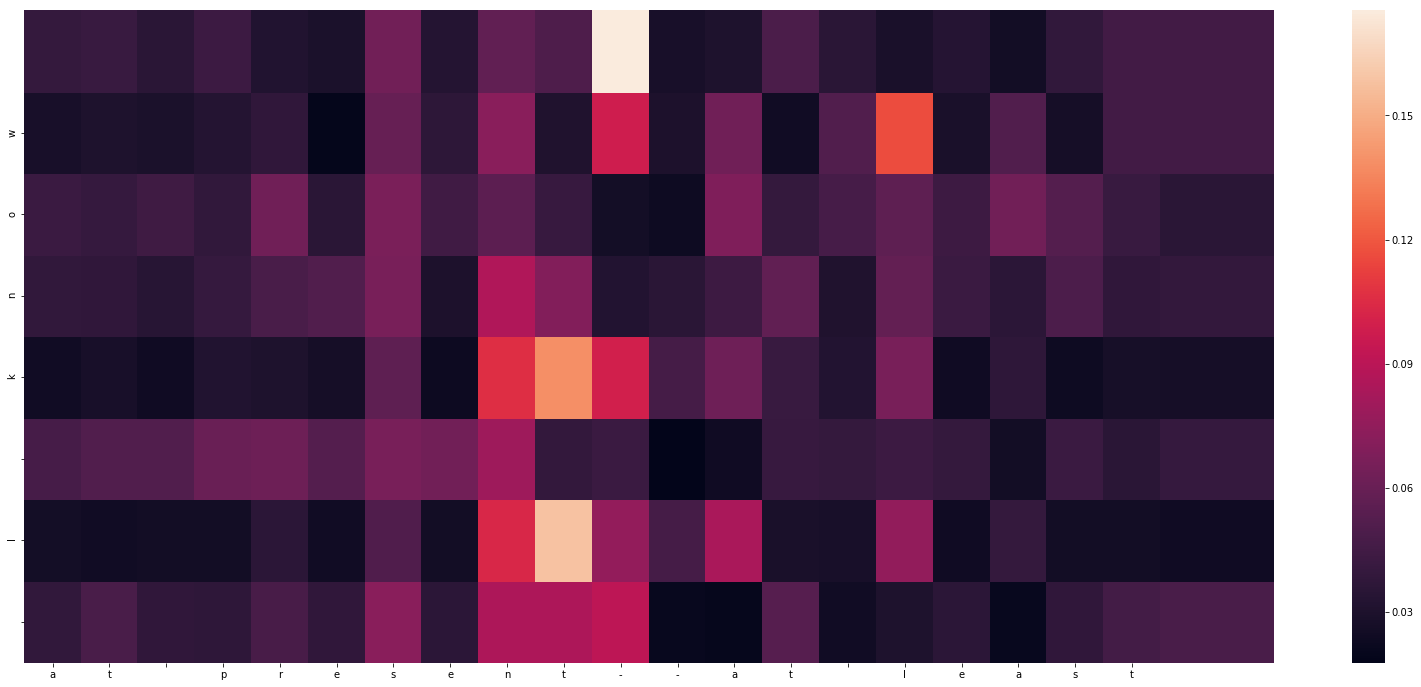

-
Input sentence: at present--at least
GT sentence:  I know
who I WAS wh
Decoded sentence:  I know


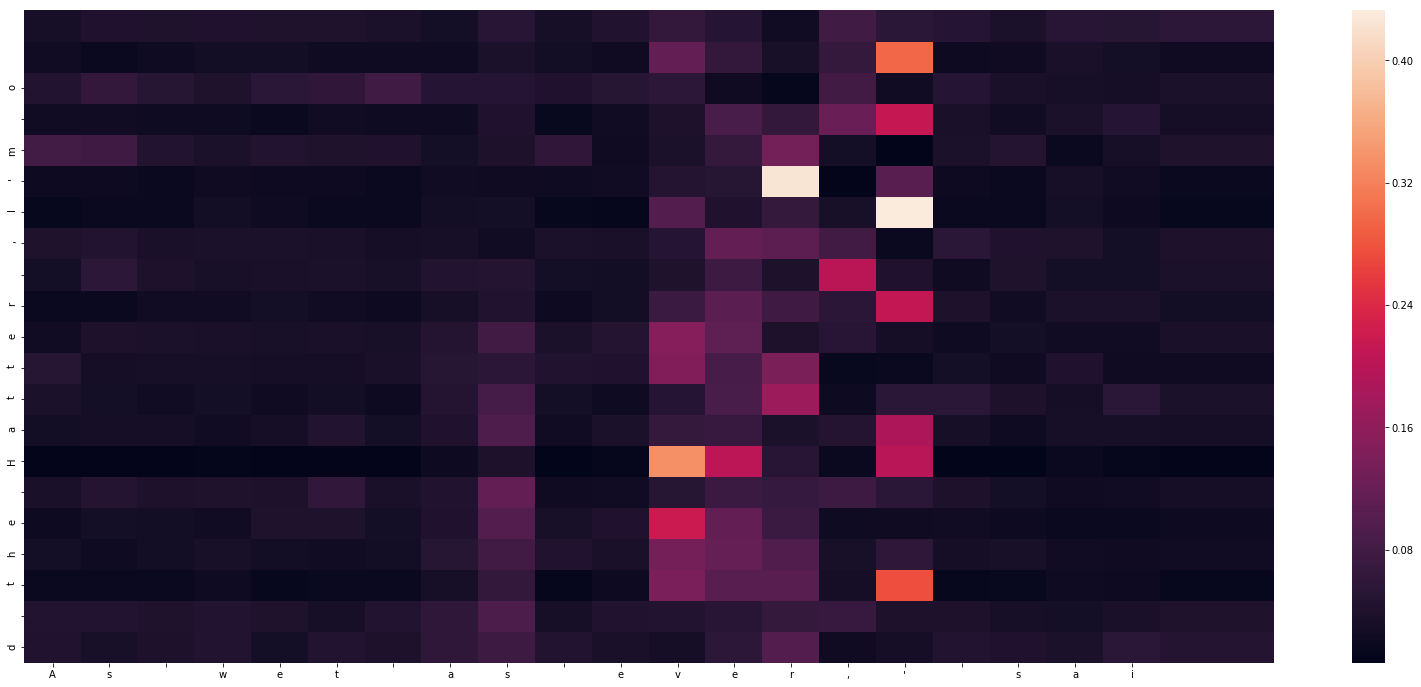

-
Input sentence: As wet as ever,' sai
GT sentence: d Alice in a melanch
Decoded sentence: d the Hatter ,I'm o


In [31]:
for seq_index in range(100):

    target_text = target_texts[seq_index][1:-1]
    text = input_texts[seq_index]
    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   


# Test - Short inference

In [44]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
corrected_sentences = []
corrected_input_sentences = []
results = open('RESULTS.md', 'w')
results.write('|OCR sentence|GT sentence|Decoded sentence|\n')
results.write('|------------|-----------|----------------|\n')
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_text = test_input_texts[seq_index]
    target_text = test_target_texts[seq_index][1:-1]

    encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=[input_text],
                                                                                 target_texts=[target_text], 
                                                                                 max_encoder_seq_length=max_encoder_seq_length, 
                                                                                 num_encoder_tokens=num_encoder_tokens, 
                                                                                 vocab_to_int=vocab_to_int)    

    input_seq = encoder_input_data
    #target_seq = np.argmax(decoder_target_data, axis=-1)
    #print(target_seq)
    decoded_sentence, _ = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, max_encoder_seq_length, int_to_vocab, vocab_to_int)
    print('-')
    print('Input sentence:', input_text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)
    results.write(' | ' + input_text + ' | ' + target_text.strip() + ' | ' + decoded_sentence + ' | \n')
    decoded_sentences.append(decoded_sentence)
    #corrected_sentences.append(corrected_sentence)
    #corrected_input_sentences.append(corrected_input_sentence)
    target_texts_.append(target_text)


encoder_input_data = vectorize_data(input_texts=input_texts, max_encoder_seq_length=max_encoder_seq_length, num_encoder_tokens=num_encoder_tokens, vocab_to_int=vocab_to_int)
    
results.close() 

-
Input sentence: e King; 'and don't b
GT sentence: e nervous, or I'll h
Decoded sentence: e no i;e in your in 
-
Input sentence:  her, and the Queen 
GT sentence: said severely 'Who i
Decoded sentence: she ,as coming
-
Input sentence: ight belong to one o
GT sentence: f the doors of the h
Decoded sentence: f the lefthand bit o
-
Input sentence: rprised at this, she
GT sentence:  was getting so used
Decoded sentence:  was treading o, a b
-
Input sentence:     And pour the wat
GT sentence: ers of the Nile
    
Decoded sentence:  one of the trees ta
-
Input sentence: 'It tells the day of
GT sentence:  the month, and does
Decoded sentence:  the March Hare '
-
Input sentence: es, I think--' (she 
GT sentence: was rather glad
ther
Decoded sentence: ra,her rath-- s(y
-
Input sentence: en reading about; an
GT sentence: d when she had
finis
Decoded sentence: d he
-
Input sentence: 
the verses to himse
GT sentence: lf: '"WE KNOW IT TO 
Decoded sentence:  than his first rema
-
Input sentence: he

-
Input sentence:  the words came
very
GT sentence:  queer indeed:--

  
Decoded sentence:  queer indering it i
-
Input sentence: d out a new kind of

GT sentence: rule, 'and vinegar t
Decoded sentence:       really this re
-
Input sentence:  suddenly upon an op
GT sentence: en
place, with a lit
Decoded sentence: portunity for croque
-
Input sentence:  was, that if someth
GT sentence: ing wasn't done abou
Decoded sentence: ing ,ith him well on
-
Input sentence: m, but they were
now
GT sentence: here to be seen--eve
Decoded sentence:  ,nd stick and seem
-
Input sentence: several
things of th
GT sentence: is sort in her lesso
Decoded sentence: e song she kept tos
-
Input sentence:  quite a crowd of li
GT sentence: ttle
animals and bir
Decoded sentence: ttle
-
Input sentence: d looked
at her, and
GT sentence:  the Queen said seve
Decoded sentence:  some of the Qu,en s
-
Input sentence:  not come the
same a
GT sentence: s they used to do:--
Decoded sentence:  little deep like a 
-
Input se

-
Input sentence: one would hardly sup
GT sentence: pose
    That your e
Decoded sentence: pryse to see it wros
-
Input sentence: om what I used to sa
GT sentence: y when I was a child
Decoded sentence: y when I was a child
-
Input sentence: ble enough hatching 
GT sentence: the eggs,' said the 
Decoded sentence: the nearer is to Fiv
-
Input sentence: at the March Hare, w
GT sentence: ho had followed him 
Decoded sentence: hile Alice had fo,lo
-
Input sentence: te or two, looking f
GT sentence: or them, and then qu
Decoded sentence: or her to,wine throu
-
Input sentence: ked at Alice, as the
GT sentence:  question was
eviden
Decoded sentence:  same thing,she was
-
Input sentence: un asking riddles.--
GT sentence: I believe I can gues
Decoded sentence: I can't
-
Input sentence:  White Rabbit hurrie
GT sentence: d by--the
frightened
Decoded sentence: dly left the guinea
-
Input sentence: ound it so yet,' sai
GT sentence: d Alice; 'but when y
Decoded sentence: d the White Ra,bit 
-
Input 

-
Input sentence: minute, while Alice

GT sentence: thought over all she
Decoded sentence: she sa, them they s
-
Input sentence: ch she had been wand
GT sentence: ering, when a sharp 
Decoded sentence: ering
-
Input sentence: t is wrong from begi
GT sentence: nning to end,' said 
Decoded sentence: nning to end' said 
-
Input sentence: YOU ARE OLD, FATHER 
GT sentence: WILLIAM,' to the Cat
Decoded sentence: WILLIAM' t, the Cat
-
Input sentence: ME, and
told me he w
GT sentence: as going a journey, 
Decoded sentence: ou,d go and live aft
-
Input sentence: ty

There was a tabl
GT sentence: e set out under a tr
Decoded sentence: e of soup off the le
-
Input sentence: er, and
tried to bea
GT sentence: t them off, and foun
Decoded sentence: ut,fully a frog or a
-
Input sentence: been would have appe
GT sentence: ared to them to be o
Decoded sentence: ared to them' thoug
-
Input sentence: the
Mouse heard this
GT sentence: , it turned round an
Decoded sentence: tle that She real
-
Input senten

-
Input sentence: re; the great wonder
GT sentence:  is, that there's an
Decoded sentence: in; hair that
-
Input sentence: ing, of course, to b
GT sentence: egin with,' the Mock
Decoded sentence: een,to her so,she
-
Input sentence: e little Bill had le
GT sentence: ft off writing on hi
Decoded sentence: ft off writing on hi
-
Input sentence: o the
court, arm-in-
GT sentence: arm with the Dormous
Decoded sentence: the Dormou,e sa-d -
-
Input sentence: h the Duchess, it ha
GT sentence: d entirely
disappear
Decoded sentence: d
-
Input sentence: r she was beginning 
GT sentence: to
feel a little wor
Decoded sentence: to encided a little
-
Input sentence: g of little Alice an
GT sentence: d all her
wonderful 
Decoded sentence: d the other queer li
-
Input sentence: Said his father; 'do
GT sentence: n't give yourself ai
Decoded sentence:  the two sides;of i
-
Input sentence: ent slowly
after it:
GT sentence:  'I never was so ord
Decoded sentence:  neverlike a wild :
-
Input sentence: e March

-
Input sentence: self, (not in a very
GT sentence:  hopeful tone
though
Decoded sentence:  how,
-
Input sentence: d when she had got i
GT sentence: ts head down, and wa
Decoded sentence: ts head to hide a gr
-
Input sentence: repeating 'YOU ARE O
GT sentence: LD, FATHER WILLIAM,'
Decoded sentence: t WAISTCOAT WAISTCOA
-
Input sentence: owed one of the cake
GT sentence: s, and was delighted
Decoded sentence: tas of her shoulders
-
Input sentence: alk: at any rate, th
GT sentence: ere's no harm in try
Decoded sentence: ere:s no harm in,her
-
Input sentence: o her feet, for it f
GT sentence: lashed across her mi
Decoded sentence: irst or a ,reat crow
-
Input sentence: ey, though she felt 
GT sentence: sure it would all co
Decoded sentence: su,e she would not s
-
Input sentence: e one--but I'm grown
GT sentence:  up now,' she added 
Decoded sentence: ' th--ght Alice 't
-
Input sentence:  being that person, 
GT sentence: I'll come up: if not
Decoded sentence: with a yelp of del,g
-
Input s

-
Input sentence: half hoping that the
GT sentence:  Mouse had changed h
Decoded sentence:  Mouse had change i
-
Input sentence: l dry, he is gay as 
GT sentence: a lark,
  And will t
Decoded sentence: looki,g for the end 
-
Input sentence:  of her head to keep
GT sentence:  back the wandering 
Decoded sentence:  in her hands and fe
-
Input sentence: ttle recovered from 
GT sentence: the shock of being
u
Decoded sentence: the smallest she sho
-
Input sentence:  to herself, 'Why, t
GT sentence: hey're only a pack o
Decoded sentence: hey had any,one o, y
-
Input sentence: ller, and the other 
GT sentence: side will make you
g
Decoded sentence: Will,am curious sens
-
Input sentence: a large caterpillar,
GT sentence: 
that was sitting on
Decoded sentence: 
-
Input sentence: ke to have it explai
GT sentence: ned,' said the Mock 
Decoded sentence: n'and most in sig
-
Input sentence: er;
and the whole pa
GT sentence: rty at once crowded 
Decoded sentence: cr;res rather curiou
-
Input sentence

-
Input sentence: e to say whether the
GT sentence:  blows hurt it or no
Decoded sentence:  little golden key 
-
Input sentence: table,' said Alice; 
GT sentence: 'it's laid for a gre
Decoded sentence: 'and ,hen' the Ki;g
-
Input sentence:      'Fury said to a
GT sentence: 
         mouse, Tha
Decoded sentence: 
-
Input sentence:  to her ear, and whi
GT sentence: spered 'She's under

Decoded sentence: le the rest,of a
-
Input sentence: htful it will be
 Wh
GT sentence: en they take us up a
Decoded sentence: et your Majesty must
-
Input sentence: is they slipped the 
GT sentence: guinea-pig,
head fir
Decoded sentence: Cheshire Cat' said 
-
Input sentence: inish my tea,' said 
GT sentence: the Hatter, with an 
Decoded sentence: the Hatter ,ith an 
-
Input sentence: uld you
tell me, ple
GT sentence: ase, which way I oug
Decoded sentence: ar I will you ,r wh
-
Input sentence:  the heads of the cr
GT sentence: owd below, and there
Decoded sentence: oquet with a kind of
-
Input sentence: r,


-
Input sentence: f her head to keep b
GT sentence: ack the wandering ha
Decoded sentence: ack for a little rec
-
Input sentence: before,' she
said to
GT sentence:  herself; 'the March
Decoded sentence:  herse,f 'his eyes 
-
Input sentence: o--oop of the e--e--
GT sentence: evening,
     Beauti
Decoded sentence: e-- I donw Bill--w--
-
Input sentence: led the
way, and the
GT sentence:  whole party swam to
Decoded sentence:  whole part, swam to
-
Input sentence: d this, it turned ro
GT sentence: und and swam slowly 
Decoded sentence: und he, any
-
Input sentence: he players to be
exe
GT sentence: cuted for having mis
Decoded sentence: cuted for her Froner
-
Input sentence: it; and while she wa
GT sentence: s peering about anxi
Decoded sentence: s ;eading
-
Input sentence:  shutting people up 
GT sentence: like telescopes: thi
Decoded sentence: to the other the Qu
-
Input sentence: n
in a great hurry; 
GT sentence: 'and their names wer
Decoded sentence: and the parth
-
Input sentence: , a

-
Input sentence: ME,' said Alice hast
GT sentence: ily; 'but I'm not lo
Decoded sentence: il, 'but thenall 
-
Input sentence: 
    Said his father
GT sentence: ; 'don't give yourse
Decoded sentence:  for the flame of a
-
Input sentence: closed its eyes by t
GT sentence: his time, and was go
Decoded sentence: he Queen who was a 
-
Input sentence: 'either you or your 
GT sentence: head must be off, an
Decoded sentence: you' said Alice wh
-
Input sentence: ry sulkily and cross
GT sentence: ed over to the
other
Decoded sentence: ed over to the
-
Input sentence: who might do very we
GT sentence: ll as pigs, and was 
Decoded sentence: re alwhily with the 
-
Input sentence: o Alice,
flinging th
GT sentence: e baby at her as she
Decoded sentence: at she ,ad asked int
-
Input sentence:  grunted again, and 
GT sentence: Alice looked very an
Decoded sentence: then
-
Input sentence:  deeply, and drew th
GT sentence: e back of one flappe
Decoded sentence: e cook ,f the crowd 
-
Input sentence: e s

-
Input sentence:  of the room
again, 
GT sentence: no wonder she felt u
Decoded sentence: when the Monst was,f
-
Input sentence: rch Hare and the Hat
GT sentence: ter were having tea 
Decoded sentence: ter were three littl
-
Input sentence: he Lizard) could not
GT sentence:  make out
at all wha
Decoded sentence:  tasted a)out makes
-
Input sentence:  no mark; but he now
GT sentence:  hastily
began again
Decoded sentence:  I
-
Input sentence: it belongs to a farm
GT sentence: er,
you know, and he
Decoded sentence: '
-
Input sentence: ld not make out
at a
GT sentence: ll what had become o
Decoded sentence: ll the whiticug as i
-
Input sentence: t: it was neither mo
GT sentence: re nor less than a p
Decoded sentence: r: breath and she t
-
Input sentence:  may not have lived 
GT sentence: much under the sea--
Decoded sentence: up to uened up and s
-
Input sentence: eing arches to do th
GT sentence: is, so that by
the e
Decoded sentence: e way of expecting t
-
Input sentence: s all his
fan

-
Input sentence: se before she had fo
GT sentence: und the
fan and glov
Decoded sentence: llowed it 
-
Input sentence: hought it had some k
GT sentence: ind of
authority ove
Decoded sentence: nown tone I wish th
-
Input sentence: nd how she would fee
GT sentence: l with
all their sim
Decoded sentence: l of the legs of the
-
Input sentence:  are so VERY nearly 
GT sentence: at the top of his he
Decoded sentence: to talk to find anot
-
Input sentence: l

It was the White 
GT sentence: Rabbit, trotting slo
Decoded sentence: Rabbit trying to bo
-
Input sentence: ONE, THEY GAVE HIM T
GT sentence: WO--" why, that must
Decoded sentence: HE ,ITTLE HIM TO YOU
-
Input sentence: ul garden, among the
GT sentence:  bright flower-beds 
Decoded sentence:  distant ,t
-
Input sentence: econdly, because the
GT sentence: y're making such a n
Decoded sentence: y were ,e
-
Input sentence:  thought it would
be
GT sentence:  as well to introduc
Decoded sentence:  like and the words
-
Input sentence: sed; it

-
Input sentence: took the hookah out 
GT sentence: of its mouth
and yaw
Decoded sentence: of its mouth
-
Input sentence: 
inquisitively, and 
GT sentence: seemed to her to win
Decoded sentence: trembling voic, 'th
-
Input sentence:  took down a jar fro
GT sentence: m one of the shelves
Decoded sentence: wning 'What IS the p
-
Input sentence:  said Alice in a soo
GT sentence: thing tone: 'don't b
Decoded sentence: m with the bones and
-
Input sentence: p and
straightening 
GT sentence: itself out again, so
Decoded sentence: to itself in a very 
-
Input sentence: e put a white one in
GT sentence:  by mistake; and if 
Decoded sentence:  a pleasant a people
-
Input sentence: a minute or two she 
GT sentence: stood looking at the
Decoded sentence: to herself as she w
-
Input sentence: as well as she could
GT sentence: , for the
hot day ma
Decoded sentence:  for the
-
Input sentence:  carried the pepper-
GT sentence: box in
her hand, and
Decoded sentence: pig
-
Input sentence: 
cushion, res

-
Input sentence: lied rather crossly:
GT sentence:  'of course you know
Decoded sentence:  'creeness of the g:
-
Input sentence:  and tried to open i
GT sentence: t; but, as
the door 
Decoded sentence: n a furiows
-
Input sentence: and, last of all thi
GT sentence: s grand
procession, 
Decoded sentence: s c,eatures or conve
-
Input sentence: using it as a
cushio
GT sentence: n, resting their elb
Decoded sentence: n rising to her li
-
Input sentence: e Pigeon;
'but I mus
GT sentence: t be on the look-out
Decoded sentence: t be on ;he lookout
-
Input sentence: versations in
it, 'a
GT sentence: nd what is the use o
Decoded sentence: nd that's all I ,an 
-
Input sentence: ck to the table, hal
GT sentence: f hoping she might f
Decoded sentence: f of found that,it m
-
Input sentence: said, turning to Ali
GT sentence: ce: he had taken his
Decoded sentence: ce ,he sat
-
Input sentence: eople began running 
GT sentence: about in all directi
Decoded sentence: in a hurry all dry
-
Input sentence

KeyboardInterrupt: 

In [46]:
test_input_texts[100]

"ow you ask me,' said"

In [ ]:

for seq_index in range(100):
    target_text = test_target_texts[seq_index][1:-1]
    text = test_input_texts[seq_index]

    decoded_sentence = visualize_attention(text, encoder_model, decoder_model, max_encoder_seq_length, num_decoder_tokens, vocab_to_int, int_to_vocab)
    print('-')
    print('Input sentence:', text)
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)  
